In [56]:
from load_data import load
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from keras.utils import plot_model

In [2]:
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LeakyReLU, Activation, Reshape, UpSampling2D

In [3]:
def create_discriminator():
    discrim = Sequential()

    discrim.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discrim.add(BatchNormalization(momentum=0.8))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discrim.add(BatchNormalization(momentum=0.8))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    discrim.add(BatchNormalization(momentum=0.8))
    discrim.add(LeakyReLU(alpha=0.2))
    discrim.add(Dropout(0.2))

    discrim.add(Flatten())
    discrim.add(Dense(1, activation='sigmoid'))
    
    discrim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return discrim

In [4]:
def create_generator():
    gen = Sequential()

    gen.add(Dense(128 * 8 * 8, activation='relu', input_dim=100))
    gen.add(Reshape((8, 8, 128)))
    gen.add(UpSampling2D())

    gen.add(Conv2D(128, kernel_size=3, padding='same'))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Activation('relu'))
    gen.add(UpSampling2D())

    gen.add(Conv2D(64, kernel_size=3, padding='same'))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Activation('relu'))

    gen.add(Conv2D(3, kernel_size=3, padding='same'))
    gen.add(Activation('sigmoid'))
    
    return gen

In [5]:
def create_gan(discrim, gen):
    discrim.trainable = False
    gan_input = Input(shape=(100,))
    x = gen(gan_input)
    gan_output = discrim(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [6]:
def plot_imgs(epoch, generator):
    noise = np.random.normal(0, 1, [25, 100])
    gen_imgs = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    for i in range(gen_imgs.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('../samples/generated_epoch_%d.png' %epoch)
    plt.close()

In [7]:
data = load()
data.shape

(486377, 3, 32, 32)

In [8]:
clean_data = np.empty((486377, 32, 32, 3))
for i in range(len(data)):
    clean_data[i] = np.dstack((data[i][0], data[i][1], data[i][2]))
clean_data = clean_data / 255
clean_data.shape

(486377, 32, 32, 3)

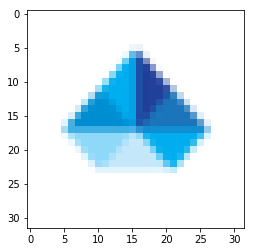

In [9]:
plt.imshow(clean_data[5])

In [10]:
discrim = create_discriminator()
discrim.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0

In [11]:
gen = create_generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)      

In [12]:
gan = create_gan(discrim, gen)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         1051267   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 394305    
Total params: 1,445,572
Trainable params: 1,050,883
Non-trainable params: 394,689
_________________________________________________________________


In [19]:
batch_count = clean_data.shape[0] // 128
for epoch in range(1, 500):
    d_loss = 0.0
    d_acc = 0.0
    g_loss = 0.0
    for _ in trange(200):
        noise = np.random.normal(0, 1, [128, 100])
        gen_imgs = gen.predict(noise)
        img_batch = clean_data[np.random.randint(low=0, high=clean_data.shape[0], size=128)]
        X = np.concatenate([img_batch, gen_imgs])
        y_dis = np.zeros(2 * 128)
        y_dis[:128] = 1
        
        discrim.trainable = True
        d_train = discrim.train_on_batch(X, y_dis)
        d_loss += d_train[0]
        d_acc += d_train[1]
        
        noise = np.random.normal(0, 1, [128, 100])
        y_gen = np.ones(128)
        
        discrim.trainable = False
        g_loss = g_loss + gan.train_on_batch(noise, y_gen)
        
    print("Epoch %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc/200, g_loss))
    if epoch == 1 or epoch % 5 == 0:
        plot_imgs(epoch, gen)


Epoch 1 [D loss: 80.398406, acc: 85.04%] [G loss: 435.920545]



Epoch 2 [D loss: 72.129222, acc: 84.98%] [G loss: 399.697682]



Epoch 3 [D loss: 71.810008, acc: 84.89%] [G loss: 421.271952]



Epoch 4 [D loss: 70.106766, acc: 84.84%] [G loss: 376.687758]



Epoch 5 [D loss: 89.380543, acc: 79.72%] [G loss: 289.395376]



Epoch 6 [D loss: 100.595909, acc: 76.51%] [G loss: 269.617721]



Epoch 7 [D loss: 95.217518, acc: 77.82%] [G loss: 280.406546]



Epoch 8 [D loss: 101.967058, acc: 75.76%] [G loss: 294.395470]



Epoch 9 [D loss: 104.662850, acc: 74.81%] [G loss: 252.902791]



Epoch 10 [D loss: 101.919855, acc: 75.01%] [G loss: 260.019682]



Epoch 11 [D loss: 106.356544, acc: 73.02%] [G loss: 245.397429]



Epoch 12 [D loss: 106.528949, acc: 73.35%] [G loss: 218.344468]



Epoch 13 [D loss: 111.270433, acc: 71.39%] [G loss: 243.206118]



Epoch 14 [D loss: 105.498610, acc: 73.69%] [G loss: 253.423514]



Epoch 15 [D loss: 103.242216, acc: 74.28%] [G loss: 232.496158]



Epoch 16 [D loss: 109.189312, acc: 71.76%] [G loss: 220.999347]



Epoch 17 [D loss: 109.465207, acc: 71.86%] [G loss: 234.294194]



Epoch 18 [D loss: 104.346037, acc: 74.01%] [G loss: 242.739678]



Epoch 19 [D loss: 109.586362, acc: 71.71%] [G loss: 227.195623]



Epoch 20 [D loss: 108.930565, acc: 72.34%] [G loss: 230.558905]



Epoch 21 [D loss: 113.566388, acc: 69.95%] [G loss: 218.913544]



Epoch 22 [D loss: 109.400187, acc: 71.79%] [G loss: 216.289784]



Epoch 23 [D loss: 106.972329, acc: 72.56%] [G loss: 218.436059]



Epoch 24 [D loss: 106.965635, acc: 72.35%] [G loss: 223.235121]



Epoch 25 [D loss: 107.755319, acc: 71.88%] [G loss: 225.127328]



Epoch 26 [D loss: 103.818851, acc: 73.42%] [G loss: 233.944912]



Epoch 27 [D loss: 105.001130, acc: 73.10%] [G loss: 240.792560]



Epoch 28 [D loss: 98.313010, acc: 75.84%] [G loss: 253.501316]



Epoch 29 [D loss: 100.365725, acc: 74.95%] [G loss: 239.878388]



Epoch 30 [D loss: 103.111445, acc: 74.28%] [G loss: 253.043906]



Epoch 31 [D loss: 103.330815, acc: 73.83%] [G loss: 247.182715]



Epoch 32 [D loss: 103.225778, acc: 74.25%] [G loss: 244.060404]



Epoch 33 [D loss: 102.480369, acc: 74.43%] [G loss: 231.372146]



Epoch 34 [D loss: 101.684977, acc: 74.81%] [G loss: 253.020333]



Epoch 35 [D loss: 95.509006, acc: 76.98%] [G loss: 258.426001]



Epoch 36 [D loss: 97.744957, acc: 76.00%] [G loss: 255.665779]



Epoch 37 [D loss: 96.366587, acc: 76.44%] [G loss: 258.098515]



Epoch 38 [D loss: 97.361415, acc: 76.15%] [G loss: 250.603250]



Epoch 39 [D loss: 98.935035, acc: 75.79%] [G loss: 246.979527]



Epoch 40 [D loss: 95.172190, acc: 76.97%] [G loss: 267.074516]



Epoch 41 [D loss: 91.662109, acc: 78.05%] [G loss: 267.179846]



Epoch 42 [D loss: 90.371910, acc: 78.53%] [G loss: 298.410128]



Epoch 43 [D loss: 86.414355, acc: 79.92%] [G loss: 303.714254]



Epoch 44 [D loss: 87.258993, acc: 79.60%] [G loss: 310.981346]



Epoch 45 [D loss: 87.393294, acc: 79.34%] [G loss: 292.383220]



Epoch 46 [D loss: 87.038586, acc: 79.64%] [G loss: 301.264320]



Epoch 47 [D loss: 86.619657, acc: 79.68%] [G loss: 310.766867]



Epoch 48 [D loss: 87.159120, acc: 79.35%] [G loss: 295.394973]



Epoch 49 [D loss: 87.139685, acc: 79.36%] [G loss: 296.031871]



Epoch 50 [D loss: 87.680685, acc: 79.37%] [G loss: 293.004662]



Epoch 51 [D loss: 89.831675, acc: 78.77%] [G loss: 284.552364]



Epoch 52 [D loss: 87.216838, acc: 79.49%] [G loss: 294.975792]



Epoch 53 [D loss: 87.898618, acc: 79.37%] [G loss: 303.386156]



Epoch 54 [D loss: 88.777448, acc: 78.81%] [G loss: 293.563423]



Epoch 55 [D loss: 87.784430, acc: 79.16%] [G loss: 298.416149]



Epoch 56 [D loss: 87.470786, acc: 79.21%] [G loss: 287.239923]



Epoch 57 [D loss: 87.955925, acc: 79.19%] [G loss: 288.576873]



Epoch 58 [D loss: 87.409814, acc: 79.44%] [G loss: 288.802239]



Epoch 59 [D loss: 88.727559, acc: 79.08%] [G loss: 291.358526]



Epoch 60 [D loss: 88.474651, acc: 79.14%] [G loss: 282.931865]



Epoch 61 [D loss: 87.444233, acc: 79.42%] [G loss: 293.377767]



Epoch 62 [D loss: 88.100414, acc: 79.38%] [G loss: 283.658278]



Epoch 63 [D loss: 86.927020, acc: 79.49%] [G loss: 291.793829]



Epoch 64 [D loss: 86.661005, acc: 79.77%] [G loss: 294.561890]



Epoch 65 [D loss: 87.847658, acc: 79.16%] [G loss: 292.720231]



Epoch 66 [D loss: 88.114604, acc: 79.08%] [G loss: 288.083672]



Epoch 67 [D loss: 88.862457, acc: 78.94%] [G loss: 293.088389]



Epoch 68 [D loss: 88.038249, acc: 79.22%] [G loss: 293.217436]



Epoch 69 [D loss: 91.086462, acc: 78.30%] [G loss: 276.129714]



Epoch 70 [D loss: 89.790535, acc: 78.69%] [G loss: 282.477733]



Epoch 71 [D loss: 88.409012, acc: 79.13%] [G loss: 280.289959]



Epoch 72 [D loss: 89.407279, acc: 78.84%] [G loss: 283.380070]



Epoch 73 [D loss: 90.547979, acc: 78.25%] [G loss: 275.325298]



Epoch 74 [D loss: 90.899185, acc: 78.32%] [G loss: 277.714864]



Epoch 75 [D loss: 91.367454, acc: 77.93%] [G loss: 267.289636]



Epoch 76 [D loss: 89.663323, acc: 78.71%] [G loss: 273.700381]



Epoch 77 [D loss: 91.394144, acc: 78.20%] [G loss: 274.894313]



Epoch 78 [D loss: 90.147253, acc: 78.33%] [G loss: 287.717748]



Epoch 79 [D loss: 91.485520, acc: 77.97%] [G loss: 271.315739]



Epoch 80 [D loss: 90.282868, acc: 78.36%] [G loss: 282.028604]



Epoch 81 [D loss: 90.735089, acc: 78.08%] [G loss: 269.863057]



Epoch 82 [D loss: 89.535667, acc: 78.90%] [G loss: 283.678205]



Epoch 83 [D loss: 89.630366, acc: 78.56%] [G loss: 279.689518]



Epoch 84 [D loss: 90.236352, acc: 78.60%] [G loss: 266.061773]



Epoch 85 [D loss: 88.675309, acc: 78.83%] [G loss: 272.855022]



Epoch 86 [D loss: 90.256899, acc: 78.38%] [G loss: 270.213480]



Epoch 87 [D loss: 89.063124, acc: 78.81%] [G loss: 275.353799]



Epoch 88 [D loss: 89.045247, acc: 78.90%] [G loss: 276.194060]



Epoch 89 [D loss: 90.038227, acc: 78.46%] [G loss: 275.079071]



Epoch 90 [D loss: 89.349651, acc: 78.75%] [G loss: 259.093224]



Epoch 91 [D loss: 90.193541, acc: 78.41%] [G loss: 279.227955]



Epoch 92 [D loss: 89.467612, acc: 78.66%] [G loss: 280.588574]



Epoch 93 [D loss: 88.703829, acc: 78.92%] [G loss: 275.648180]



Epoch 94 [D loss: 89.749720, acc: 78.53%] [G loss: 273.376149]



Epoch 95 [D loss: 88.549607, acc: 78.80%] [G loss: 278.214193]



Epoch 96 [D loss: 87.456199, acc: 79.28%] [G loss: 269.826240]



Epoch 97 [D loss: 87.011813, acc: 79.38%] [G loss: 281.836890]



Epoch 98 [D loss: 86.935010, acc: 79.35%] [G loss: 288.913839]



Epoch 99 [D loss: 86.778365, acc: 79.40%] [G loss: 278.817859]



Epoch 100 [D loss: 87.248933, acc: 79.17%] [G loss: 275.248267]



Epoch 101 [D loss: 85.746586, acc: 79.86%] [G loss: 289.294558]



Epoch 102 [D loss: 86.536100, acc: 79.59%] [G loss: 276.642887]



Epoch 103 [D loss: 86.855017, acc: 79.48%] [G loss: 286.988081]



Epoch 104 [D loss: 87.463763, acc: 79.10%] [G loss: 289.970850]



Epoch 105 [D loss: 86.804247, acc: 79.40%] [G loss: 279.113967]



Epoch 106 [D loss: 84.828934, acc: 80.02%] [G loss: 282.588830]



Epoch 107 [D loss: 85.048035, acc: 80.17%] [G loss: 281.896703]



Epoch 108 [D loss: 85.508472, acc: 79.83%] [G loss: 273.897843]



Epoch 109 [D loss: 85.352152, acc: 79.78%] [G loss: 279.516214]



Epoch 110 [D loss: 84.665699, acc: 80.13%] [G loss: 279.082731]



Epoch 111 [D loss: 83.525701, acc: 80.65%] [G loss: 273.187460]



Epoch 112 [D loss: 85.162905, acc: 79.92%] [G loss: 290.726377]



Epoch 113 [D loss: 85.569984, acc: 79.83%] [G loss: 275.817960]



Epoch 114 [D loss: 86.099745, acc: 79.65%] [G loss: 283.193654]



Epoch 115 [D loss: 85.153804, acc: 79.98%] [G loss: 278.106038]



Epoch 116 [D loss: 85.194121, acc: 79.82%] [G loss: 285.337430]



Epoch 117 [D loss: 86.316408, acc: 79.57%] [G loss: 282.018863]



Epoch 118 [D loss: 85.295693, acc: 79.82%] [G loss: 286.424890]



Epoch 119 [D loss: 84.184743, acc: 80.28%] [G loss: 284.683963]



Epoch 120 [D loss: 84.969559, acc: 79.93%] [G loss: 286.267658]



Epoch 121 [D loss: 84.604961, acc: 80.12%] [G loss: 274.717156]



Epoch 122 [D loss: 84.548496, acc: 80.07%] [G loss: 293.026874]



Epoch 123 [D loss: 85.642617, acc: 79.71%] [G loss: 281.426332]



Epoch 124 [D loss: 83.865208, acc: 80.28%] [G loss: 288.406662]



Epoch 125 [D loss: 82.549419, acc: 80.72%] [G loss: 298.409214]



Epoch 126 [D loss: 84.100066, acc: 80.46%] [G loss: 279.292471]



Epoch 127 [D loss: 83.658127, acc: 80.43%] [G loss: 285.798978]



Epoch 128 [D loss: 82.768432, acc: 80.52%] [G loss: 271.005300]



Epoch 129 [D loss: 84.257766, acc: 80.22%] [G loss: 289.595686]



Epoch 130 [D loss: 84.584185, acc: 80.15%] [G loss: 287.385584]



Epoch 131 [D loss: 82.863820, acc: 80.47%] [G loss: 288.419900]



Epoch 132 [D loss: 83.856558, acc: 80.31%] [G loss: 295.013623]



Epoch 133 [D loss: 82.666023, acc: 80.67%] [G loss: 291.996406]



Epoch 134 [D loss: 83.261096, acc: 80.43%] [G loss: 287.118610]



Epoch 135 [D loss: 83.852983, acc: 80.45%] [G loss: 292.152476]



Epoch 136 [D loss: 82.186191, acc: 80.78%] [G loss: 279.296544]



Epoch 137 [D loss: 82.556694, acc: 80.75%] [G loss: 288.702301]



Epoch 138 [D loss: 82.396225, acc: 80.83%] [G loss: 266.034230]



Epoch 139 [D loss: 82.581038, acc: 80.62%] [G loss: 297.935839]



Epoch 140 [D loss: 82.295841, acc: 80.96%] [G loss: 302.489537]



Epoch 141 [D loss: 83.505727, acc: 80.56%] [G loss: 284.914962]



Epoch 142 [D loss: 83.058218, acc: 80.77%] [G loss: 286.694551]



Epoch 143 [D loss: 82.824596, acc: 80.50%] [G loss: 288.275270]



Epoch 144 [D loss: 81.679650, acc: 80.99%] [G loss: 293.698283]



Epoch 145 [D loss: 83.318637, acc: 80.48%] [G loss: 298.144953]



Epoch 146 [D loss: 82.262961, acc: 80.72%] [G loss: 301.090194]



Epoch 147 [D loss: 82.501084, acc: 80.58%] [G loss: 287.102352]



Epoch 148 [D loss: 80.764378, acc: 81.40%] [G loss: 287.284082]



Epoch 149 [D loss: 81.840036, acc: 80.91%] [G loss: 296.811452]



Epoch 150 [D loss: 83.129030, acc: 80.54%] [G loss: 289.161589]



Epoch 151 [D loss: 81.316020, acc: 81.01%] [G loss: 304.241609]



Epoch 152 [D loss: 80.578196, acc: 81.15%] [G loss: 300.022053]



Epoch 153 [D loss: 81.964745, acc: 80.98%] [G loss: 287.260699]



Epoch 154 [D loss: 81.576477, acc: 81.00%] [G loss: 292.155318]



Epoch 155 [D loss: 81.860235, acc: 81.05%] [G loss: 300.862999]



Epoch 156 [D loss: 81.700053, acc: 81.10%] [G loss: 291.574345]



Epoch 157 [D loss: 82.155056, acc: 80.70%] [G loss: 294.496745]



Epoch 158 [D loss: 82.477083, acc: 80.93%] [G loss: 281.701961]



Epoch 159 [D loss: 82.697182, acc: 80.68%] [G loss: 302.418543]



Epoch 160 [D loss: 82.908526, acc: 80.61%] [G loss: 298.813186]



Epoch 161 [D loss: 81.049243, acc: 81.17%] [G loss: 300.760945]



Epoch 162 [D loss: 81.992277, acc: 81.08%] [G loss: 293.348257]



Epoch 163 [D loss: 81.960104, acc: 80.82%] [G loss: 304.193405]



Epoch 164 [D loss: 79.771898, acc: 81.55%] [G loss: 287.521708]



Epoch 165 [D loss: 81.511990, acc: 81.03%] [G loss: 292.033681]



Epoch 166 [D loss: 81.036665, acc: 81.21%] [G loss: 295.038371]



Epoch 167 [D loss: 81.126217, acc: 81.27%] [G loss: 300.595360]



Epoch 168 [D loss: 79.512967, acc: 81.85%] [G loss: 293.557227]



Epoch 169 [D loss: 80.038726, acc: 81.66%] [G loss: 290.305404]



Epoch 170 [D loss: 80.960159, acc: 81.35%] [G loss: 299.383824]



Epoch 171 [D loss: 81.678210, acc: 81.09%] [G loss: 294.253685]



Epoch 172 [D loss: 80.504796, acc: 81.32%] [G loss: 299.914141]



Epoch 173 [D loss: 82.871303, acc: 80.73%] [G loss: 299.946532]



Epoch 174 [D loss: 82.182132, acc: 80.94%] [G loss: 303.636326]



Epoch 175 [D loss: 80.758892, acc: 81.29%] [G loss: 289.372203]



Epoch 176 [D loss: 81.607337, acc: 80.96%] [G loss: 301.692352]



Epoch 177 [D loss: 80.988659, acc: 81.11%] [G loss: 283.099587]



Epoch 178 [D loss: 81.044361, acc: 81.42%] [G loss: 296.041237]



Epoch 179 [D loss: 80.178017, acc: 81.52%] [G loss: 307.644832]



Epoch 180 [D loss: 81.621714, acc: 81.01%] [G loss: 302.705795]



Epoch 181 [D loss: 81.824179, acc: 81.04%] [G loss: 295.220728]



Epoch 182 [D loss: 82.263672, acc: 80.64%] [G loss: 285.541895]



Epoch 183 [D loss: 80.560119, acc: 81.36%] [G loss: 282.047809]



Epoch 184 [D loss: 80.560248, acc: 81.39%] [G loss: 299.190501]



Epoch 185 [D loss: 80.693761, acc: 81.30%] [G loss: 291.628184]



Epoch 186 [D loss: 78.995900, acc: 81.82%] [G loss: 282.779770]



Epoch 187 [D loss: 80.282114, acc: 81.44%] [G loss: 310.576584]



Epoch 188 [D loss: 81.728970, acc: 80.98%] [G loss: 293.631813]



Epoch 189 [D loss: 80.652648, acc: 81.23%] [G loss: 299.092736]



Epoch 190 [D loss: 81.326942, acc: 81.13%] [G loss: 295.074684]



Epoch 191 [D loss: 81.119265, acc: 81.25%] [G loss: 309.989985]



Epoch 192 [D loss: 79.927895, acc: 81.54%] [G loss: 303.719641]



Epoch 193 [D loss: 80.018614, acc: 81.60%] [G loss: 313.533586]



Epoch 194 [D loss: 81.064356, acc: 81.00%] [G loss: 287.384364]



Epoch 195 [D loss: 80.375346, acc: 81.53%] [G loss: 290.409419]



Epoch 196 [D loss: 81.263879, acc: 81.09%] [G loss: 306.087246]



Epoch 197 [D loss: 81.202162, acc: 81.01%] [G loss: 287.295810]



Epoch 198 [D loss: 79.497032, acc: 81.62%] [G loss: 294.057689]



Epoch 199 [D loss: 81.088390, acc: 81.24%] [G loss: 306.979601]



Epoch 200 [D loss: 79.461056, acc: 81.68%] [G loss: 282.984453]



Epoch 201 [D loss: 79.986408, acc: 81.57%] [G loss: 295.226461]



Epoch 202 [D loss: 80.104323, acc: 81.56%] [G loss: 303.840733]



Epoch 203 [D loss: 80.575783, acc: 81.40%] [G loss: 304.695490]



Epoch 204 [D loss: 80.075912, acc: 81.42%] [G loss: 297.652708]



Epoch 205 [D loss: 80.754793, acc: 81.29%] [G loss: 306.576835]



Epoch 206 [D loss: 81.157692, acc: 81.30%] [G loss: 306.345024]



Epoch 207 [D loss: 81.870123, acc: 81.00%] [G loss: 310.483119]



Epoch 208 [D loss: 80.442754, acc: 81.30%] [G loss: 309.483064]



Epoch 209 [D loss: 81.073078, acc: 81.14%] [G loss: 298.864878]



Epoch 210 [D loss: 81.690792, acc: 80.90%] [G loss: 310.237428]



Epoch 211 [D loss: 80.599640, acc: 81.27%] [G loss: 307.758628]



Epoch 212 [D loss: 80.404659, acc: 81.29%] [G loss: 305.088692]



Epoch 213 [D loss: 81.126585, acc: 81.33%] [G loss: 300.063975]



Epoch 214 [D loss: 79.094328, acc: 81.84%] [G loss: 299.465164]



Epoch 215 [D loss: 79.618011, acc: 81.65%] [G loss: 291.317728]



Epoch 216 [D loss: 79.471987, acc: 81.66%] [G loss: 293.473671]



Epoch 217 [D loss: 80.139142, acc: 81.58%] [G loss: 305.440149]



Epoch 218 [D loss: 80.349654, acc: 81.41%] [G loss: 306.703094]



Epoch 219 [D loss: 78.871621, acc: 81.94%] [G loss: 292.537392]



Epoch 220 [D loss: 79.433231, acc: 81.90%] [G loss: 291.622314]



Epoch 221 [D loss: 79.416979, acc: 81.93%] [G loss: 303.057409]



Epoch 222 [D loss: 79.780370, acc: 81.58%] [G loss: 315.531606]



Epoch 223 [D loss: 79.872248, acc: 81.61%] [G loss: 306.261767]



Epoch 224 [D loss: 80.399476, acc: 81.37%] [G loss: 297.923078]



Epoch 225 [D loss: 79.419440, acc: 81.53%] [G loss: 307.445223]



Epoch 226 [D loss: 80.207740, acc: 81.41%] [G loss: 301.244281]



Epoch 227 [D loss: 81.549311, acc: 81.10%] [G loss: 304.468581]



Epoch 228 [D loss: 78.959447, acc: 81.82%] [G loss: 301.894395]



Epoch 229 [D loss: 80.178956, acc: 81.47%] [G loss: 302.108213]



Epoch 230 [D loss: 79.732343, acc: 81.63%] [G loss: 305.162548]



Epoch 231 [D loss: 78.431733, acc: 81.98%] [G loss: 303.907553]



Epoch 232 [D loss: 79.776189, acc: 81.62%] [G loss: 310.770900]



Epoch 233 [D loss: 79.687678, acc: 81.74%] [G loss: 289.136786]



Epoch 234 [D loss: 79.372543, acc: 81.81%] [G loss: 316.170818]



Epoch 235 [D loss: 79.050066, acc: 81.76%] [G loss: 298.167146]



Epoch 236 [D loss: 78.410434, acc: 81.96%] [G loss: 291.593744]



Epoch 237 [D loss: 79.326623, acc: 81.79%] [G loss: 308.947053]



Epoch 238 [D loss: 80.342688, acc: 81.54%] [G loss: 309.874573]



Epoch 239 [D loss: 81.444836, acc: 81.07%] [G loss: 306.699681]



Epoch 240 [D loss: 80.158127, acc: 81.34%] [G loss: 317.063034]



Epoch 241 [D loss: 79.075425, acc: 81.86%] [G loss: 306.492139]



Epoch 242 [D loss: 79.353506, acc: 81.72%] [G loss: 307.495364]



Epoch 243 [D loss: 77.648296, acc: 82.25%] [G loss: 306.714654]



Epoch 244 [D loss: 79.368623, acc: 81.47%] [G loss: 298.727079]



Epoch 245 [D loss: 79.063927, acc: 81.67%] [G loss: 314.211997]



Epoch 246 [D loss: 78.758271, acc: 81.99%] [G loss: 305.015316]



Epoch 247 [D loss: 78.781785, acc: 81.93%] [G loss: 307.748449]



Epoch 248 [D loss: 78.269488, acc: 82.10%] [G loss: 306.531932]



Epoch 249 [D loss: 78.473467, acc: 82.11%] [G loss: 317.660704]



Epoch 250 [D loss: 78.824626, acc: 82.04%] [G loss: 308.902723]



Epoch 251 [D loss: 78.868021, acc: 81.84%] [G loss: 307.404781]



Epoch 252 [D loss: 77.583615, acc: 82.22%] [G loss: 306.477560]



Epoch 253 [D loss: 79.702837, acc: 81.71%] [G loss: 295.553234]



Epoch 254 [D loss: 78.159859, acc: 82.03%] [G loss: 297.186764]



Epoch 255 [D loss: 77.540357, acc: 82.14%] [G loss: 297.035012]



Epoch 256 [D loss: 78.744251, acc: 81.79%] [G loss: 309.776695]



Epoch 257 [D loss: 79.390533, acc: 81.66%] [G loss: 298.630528]



Epoch 258 [D loss: 78.009218, acc: 82.03%] [G loss: 311.031984]



Epoch 259 [D loss: 79.348694, acc: 81.77%] [G loss: 300.935675]



Epoch 260 [D loss: 78.166242, acc: 82.16%] [G loss: 298.820078]



Epoch 261 [D loss: 79.230075, acc: 81.73%] [G loss: 304.290235]



Epoch 262 [D loss: 77.685932, acc: 82.16%] [G loss: 310.110140]



Epoch 263 [D loss: 79.102676, acc: 81.78%] [G loss: 309.544318]



Epoch 264 [D loss: 76.999515, acc: 82.46%] [G loss: 296.399049]



Epoch 265 [D loss: 77.125078, acc: 82.41%] [G loss: 305.053357]



Epoch 266 [D loss: 78.382950, acc: 82.08%] [G loss: 313.799828]



Epoch 267 [D loss: 79.912493, acc: 81.54%] [G loss: 308.387635]



Epoch 268 [D loss: 78.873853, acc: 81.93%] [G loss: 312.172839]



Epoch 269 [D loss: 77.746378, acc: 82.34%] [G loss: 313.575925]



Epoch 270 [D loss: 77.699849, acc: 82.49%] [G loss: 304.704551]



Epoch 271 [D loss: 78.576359, acc: 81.79%] [G loss: 311.962121]



Epoch 272 [D loss: 77.166219, acc: 82.38%] [G loss: 308.142541]



Epoch 273 [D loss: 77.806923, acc: 82.28%] [G loss: 299.280039]



Epoch 274 [D loss: 79.084838, acc: 81.85%] [G loss: 316.442207]



Epoch 275 [D loss: 78.499334, acc: 81.97%] [G loss: 304.154475]



Epoch 276 [D loss: 80.531778, acc: 81.51%] [G loss: 308.732588]



Epoch 277 [D loss: 78.414289, acc: 82.09%] [G loss: 317.402961]



Epoch 278 [D loss: 78.476939, acc: 82.01%] [G loss: 300.490911]



Epoch 279 [D loss: 77.845426, acc: 82.21%] [G loss: 305.131410]



Epoch 280 [D loss: 79.220503, acc: 81.80%] [G loss: 313.852359]



Epoch 281 [D loss: 79.437527, acc: 81.64%] [G loss: 295.184256]



Epoch 282 [D loss: 78.947614, acc: 81.69%] [G loss: 307.516381]



Epoch 283 [D loss: 78.285753, acc: 82.04%] [G loss: 305.113126]



Epoch 284 [D loss: 78.428279, acc: 82.03%] [G loss: 298.328526]



Epoch 285 [D loss: 78.055175, acc: 82.10%] [G loss: 303.174750]



Epoch 286 [D loss: 78.514448, acc: 81.95%] [G loss: 321.953310]



Epoch 287 [D loss: 77.680487, acc: 82.45%] [G loss: 305.730163]



Epoch 288 [D loss: 75.347432, acc: 82.91%] [G loss: 317.267972]



Epoch 289 [D loss: 77.212454, acc: 82.27%] [G loss: 305.474358]



Epoch 290 [D loss: 77.444153, acc: 82.28%] [G loss: 300.726051]



Epoch 291 [D loss: 78.405734, acc: 81.96%] [G loss: 319.062705]



Epoch 292 [D loss: 78.026441, acc: 82.14%] [G loss: 314.990584]



Epoch 293 [D loss: 78.784136, acc: 82.01%] [G loss: 313.836119]



Epoch 294 [D loss: 77.445237, acc: 82.14%] [G loss: 302.056783]



Epoch 295 [D loss: 78.266346, acc: 82.00%] [G loss: 304.191657]



Epoch 296 [D loss: 78.037927, acc: 82.20%] [G loss: 301.241023]



Epoch 297 [D loss: 76.745933, acc: 82.40%] [G loss: 307.805728]



Epoch 298 [D loss: 78.641489, acc: 81.85%] [G loss: 316.904309]



Epoch 299 [D loss: 78.073573, acc: 82.20%] [G loss: 311.504636]



Epoch 300 [D loss: 78.317266, acc: 82.01%] [G loss: 292.722079]



Epoch 301 [D loss: 77.010889, acc: 82.45%] [G loss: 312.758110]



Epoch 302 [D loss: 78.006968, acc: 82.21%] [G loss: 310.722736]



Epoch 303 [D loss: 76.760113, acc: 82.55%] [G loss: 301.453724]



Epoch 304 [D loss: 76.773452, acc: 82.51%] [G loss: 303.445381]



Epoch 305 [D loss: 77.047268, acc: 82.38%] [G loss: 320.226028]



Epoch 306 [D loss: 77.860608, acc: 82.18%] [G loss: 314.151784]



Epoch 307 [D loss: 79.171280, acc: 81.84%] [G loss: 309.113230]



Epoch 308 [D loss: 77.360409, acc: 82.25%] [G loss: 309.250614]



Epoch 309 [D loss: 77.732103, acc: 82.36%] [G loss: 318.246709]



Epoch 310 [D loss: 75.725736, acc: 82.64%] [G loss: 307.264826]



Epoch 311 [D loss: 77.248959, acc: 82.39%] [G loss: 301.350674]



Epoch 312 [D loss: 78.666922, acc: 81.93%] [G loss: 300.008303]



Epoch 313 [D loss: 77.191030, acc: 82.27%] [G loss: 309.907397]



Epoch 314 [D loss: 76.941391, acc: 82.42%] [G loss: 304.952266]



Epoch 315 [D loss: 76.450811, acc: 82.66%] [G loss: 305.859163]



Epoch 316 [D loss: 77.197951, acc: 82.41%] [G loss: 317.897202]



Epoch 317 [D loss: 78.739914, acc: 81.75%] [G loss: 308.656353]



Epoch 318 [D loss: 77.039710, acc: 82.54%] [G loss: 315.055644]



Epoch 319 [D loss: 76.276307, acc: 82.65%] [G loss: 316.542804]



Epoch 320 [D loss: 76.870181, acc: 82.50%] [G loss: 301.543547]



Epoch 321 [D loss: 78.722441, acc: 81.74%] [G loss: 329.275302]



Epoch 322 [D loss: 78.137678, acc: 82.25%] [G loss: 309.146656]



Epoch 323 [D loss: 78.211370, acc: 82.05%] [G loss: 293.431081]



Epoch 324 [D loss: 77.503339, acc: 82.45%] [G loss: 320.368198]



Epoch 325 [D loss: 76.867449, acc: 82.50%] [G loss: 311.345561]



Epoch 326 [D loss: 78.000008, acc: 82.22%] [G loss: 302.804780]



Epoch 327 [D loss: 78.114599, acc: 81.88%] [G loss: 326.154817]



Epoch 328 [D loss: 77.290549, acc: 82.40%] [G loss: 310.941388]



Epoch 329 [D loss: 80.620885, acc: 81.50%] [G loss: 324.382114]



Epoch 330 [D loss: 78.111006, acc: 82.09%] [G loss: 315.861110]



Epoch 331 [D loss: 77.000511, acc: 82.50%] [G loss: 312.565394]



Epoch 332 [D loss: 76.525817, acc: 82.53%] [G loss: 295.333603]



Epoch 333 [D loss: 75.312149, acc: 82.76%] [G loss: 313.616452]



Epoch 334 [D loss: 74.489850, acc: 83.19%] [G loss: 301.600683]



Epoch 335 [D loss: 77.350831, acc: 82.26%] [G loss: 290.427695]



Epoch 336 [D loss: 77.435982, acc: 82.01%] [G loss: 317.724452]



Epoch 337 [D loss: 76.438597, acc: 82.54%] [G loss: 303.292355]



Epoch 338 [D loss: 77.910713, acc: 82.15%] [G loss: 304.883861]



Epoch 339 [D loss: 76.593140, acc: 82.40%] [G loss: 321.634229]



Epoch 340 [D loss: 77.009012, acc: 82.41%] [G loss: 313.326554]



Epoch 341 [D loss: 76.158784, acc: 82.79%] [G loss: 295.458102]



Epoch 342 [D loss: 77.138770, acc: 82.30%] [G loss: 320.948179]



Epoch 343 [D loss: 76.095026, acc: 82.87%] [G loss: 301.292924]



Epoch 344 [D loss: 74.084557, acc: 83.28%] [G loss: 302.943405]



Epoch 345 [D loss: 74.388625, acc: 83.22%] [G loss: 300.969095]



Epoch 346 [D loss: 77.012353, acc: 82.20%] [G loss: 312.687123]



Epoch 347 [D loss: 77.548228, acc: 82.44%] [G loss: 331.872169]



Epoch 348 [D loss: 77.265800, acc: 82.34%] [G loss: 317.533800]



Epoch 349 [D loss: 79.033799, acc: 81.79%] [G loss: 308.490503]



Epoch 350 [D loss: 76.422503, acc: 82.58%] [G loss: 301.135249]



Epoch 351 [D loss: 77.308801, acc: 82.21%] [G loss: 312.246862]



Epoch 352 [D loss: 77.517192, acc: 82.24%] [G loss: 309.558342]



Epoch 353 [D loss: 76.471079, acc: 82.48%] [G loss: 301.336908]



Epoch 354 [D loss: 77.453199, acc: 82.16%] [G loss: 309.816705]



Epoch 355 [D loss: 77.415927, acc: 82.31%] [G loss: 314.129478]



Epoch 356 [D loss: 77.589194, acc: 82.18%] [G loss: 314.280536]



Epoch 357 [D loss: 77.073556, acc: 82.46%] [G loss: 316.540301]



Epoch 358 [D loss: 76.980034, acc: 82.57%] [G loss: 310.936730]



Epoch 359 [D loss: 76.826549, acc: 82.36%] [G loss: 318.060165]



Epoch 360 [D loss: 75.318681, acc: 82.76%] [G loss: 312.044622]



Epoch 361 [D loss: 75.313637, acc: 82.82%] [G loss: 304.955453]



Epoch 362 [D loss: 75.884655, acc: 82.65%] [G loss: 320.638513]



Epoch 363 [D loss: 77.436213, acc: 82.33%] [G loss: 299.127064]



Epoch 364 [D loss: 77.289115, acc: 82.24%] [G loss: 308.277604]



Epoch 365 [D loss: 79.236702, acc: 81.71%] [G loss: 317.270952]



Epoch 366 [D loss: 78.872626, acc: 81.94%] [G loss: 328.118810]



Epoch 367 [D loss: 78.057205, acc: 82.26%] [G loss: 322.711959]



Epoch 368 [D loss: 78.610645, acc: 81.90%] [G loss: 327.004920]



Epoch 369 [D loss: 76.580160, acc: 82.42%] [G loss: 316.154478]



Epoch 370 [D loss: 76.229296, acc: 82.65%] [G loss: 306.629595]



Epoch 371 [D loss: 77.449416, acc: 82.32%] [G loss: 305.403428]



Epoch 372 [D loss: 76.166545, acc: 82.73%] [G loss: 302.854177]



Epoch 373 [D loss: 75.160515, acc: 82.86%] [G loss: 299.860842]



Epoch 374 [D loss: 74.528714, acc: 83.21%] [G loss: 292.812182]



Epoch 375 [D loss: 75.657135, acc: 82.79%] [G loss: 303.710617]



Epoch 376 [D loss: 77.061702, acc: 82.41%] [G loss: 326.978026]



Epoch 377 [D loss: 77.631358, acc: 82.24%] [G loss: 314.686711]



Epoch 378 [D loss: 75.673496, acc: 82.77%] [G loss: 301.216114]



Epoch 379 [D loss: 78.607328, acc: 81.97%] [G loss: 308.604238]



Epoch 380 [D loss: 73.948479, acc: 83.23%] [G loss: 306.279362]



Epoch 381 [D loss: 76.454835, acc: 82.52%] [G loss: 319.348813]



Epoch 382 [D loss: 76.371486, acc: 82.56%] [G loss: 304.401406]



Epoch 383 [D loss: 75.036487, acc: 83.00%] [G loss: 312.448259]



Epoch 384 [D loss: 76.912029, acc: 82.56%] [G loss: 319.497208]



Epoch 385 [D loss: 77.133677, acc: 82.50%] [G loss: 302.262126]



Epoch 386 [D loss: 76.302212, acc: 82.72%] [G loss: 306.887195]



Epoch 387 [D loss: 75.221280, acc: 82.93%] [G loss: 311.459566]



Epoch 388 [D loss: 76.358001, acc: 82.70%] [G loss: 302.896655]



Epoch 389 [D loss: 76.461633, acc: 82.57%] [G loss: 310.779771]



Epoch 390 [D loss: 76.166932, acc: 82.62%] [G loss: 313.697600]



Epoch 391 [D loss: 76.146504, acc: 82.75%] [G loss: 317.100002]



Epoch 392 [D loss: 76.202374, acc: 82.53%] [G loss: 323.559321]



Epoch 393 [D loss: 76.143024, acc: 82.62%] [G loss: 316.275085]



Epoch 394 [D loss: 76.737843, acc: 82.54%] [G loss: 319.509009]



Epoch 395 [D loss: 74.765316, acc: 83.11%] [G loss: 308.797818]



Epoch 396 [D loss: 76.528439, acc: 82.64%] [G loss: 319.224588]



Epoch 397 [D loss: 76.123994, acc: 82.72%] [G loss: 311.949757]



Epoch 398 [D loss: 75.422472, acc: 82.95%] [G loss: 305.478858]



Epoch 399 [D loss: 74.815344, acc: 82.99%] [G loss: 294.325148]



Epoch 400 [D loss: 77.135748, acc: 82.60%] [G loss: 319.288082]



Epoch 401 [D loss: 76.042476, acc: 82.75%] [G loss: 317.085883]



Epoch 402 [D loss: 75.938194, acc: 82.67%] [G loss: 316.837491]



Epoch 403 [D loss: 75.593548, acc: 82.90%] [G loss: 306.515467]



Epoch 404 [D loss: 76.627055, acc: 82.50%] [G loss: 329.644501]



Epoch 405 [D loss: 76.547909, acc: 82.55%] [G loss: 306.677979]



Epoch 406 [D loss: 76.145142, acc: 82.56%] [G loss: 321.631061]



Epoch 407 [D loss: 77.245194, acc: 82.35%] [G loss: 310.380531]



Epoch 408 [D loss: 77.231882, acc: 82.24%] [G loss: 315.428168]



Epoch 409 [D loss: 76.276358, acc: 82.56%] [G loss: 311.977828]



Epoch 410 [D loss: 75.101999, acc: 83.10%] [G loss: 309.959227]



Epoch 411 [D loss: 76.609317, acc: 82.73%] [G loss: 317.660481]



Epoch 412 [D loss: 77.273325, acc: 82.32%] [G loss: 322.910635]



Epoch 413 [D loss: 77.004626, acc: 82.40%] [G loss: 312.431017]



Epoch 414 [D loss: 76.204457, acc: 82.73%] [G loss: 305.418162]



Epoch 415 [D loss: 76.112590, acc: 82.76%] [G loss: 316.166927]



Epoch 416 [D loss: 75.811616, acc: 82.70%] [G loss: 318.295073]



Epoch 417 [D loss: 74.957617, acc: 83.03%] [G loss: 308.272557]



Epoch 418 [D loss: 76.704911, acc: 82.53%] [G loss: 308.488130]



Epoch 419 [D loss: 76.174786, acc: 82.87%] [G loss: 316.454061]



Epoch 420 [D loss: 76.993132, acc: 82.61%] [G loss: 317.042248]



Epoch 421 [D loss: 75.228892, acc: 82.91%] [G loss: 298.296015]



Epoch 422 [D loss: 76.066470, acc: 82.71%] [G loss: 313.857618]



Epoch 423 [D loss: 74.824771, acc: 83.23%] [G loss: 301.598935]



Epoch 424 [D loss: 74.881113, acc: 83.11%] [G loss: 303.463847]



Epoch 425 [D loss: 74.350479, acc: 83.27%] [G loss: 310.998261]



Epoch 426 [D loss: 75.286171, acc: 82.80%] [G loss: 303.321453]



Epoch 427 [D loss: 75.158391, acc: 82.97%] [G loss: 318.745503]



Epoch 428 [D loss: 75.158067, acc: 82.94%] [G loss: 301.258843]



Epoch 429 [D loss: 75.627631, acc: 82.68%] [G loss: 322.963766]



Epoch 430 [D loss: 76.982431, acc: 82.34%] [G loss: 319.898962]



Epoch 431 [D loss: 75.451580, acc: 83.04%] [G loss: 322.138536]



Epoch 432 [D loss: 75.906309, acc: 82.68%] [G loss: 312.199554]



Epoch 433 [D loss: 75.644374, acc: 82.92%] [G loss: 308.347403]



Epoch 434 [D loss: 77.002001, acc: 82.60%] [G loss: 315.166916]



Epoch 435 [D loss: 76.299062, acc: 82.84%] [G loss: 306.321203]



Epoch 436 [D loss: 75.015139, acc: 82.99%] [G loss: 313.489371]



Epoch 437 [D loss: 75.968431, acc: 82.76%] [G loss: 309.486429]



Epoch 438 [D loss: 76.929900, acc: 82.52%] [G loss: 313.618778]



Epoch 439 [D loss: 75.687215, acc: 83.01%] [G loss: 316.555364]



Epoch 440 [D loss: 75.570688, acc: 82.89%] [G loss: 302.440587]



Epoch 441 [D loss: 76.620342, acc: 82.52%] [G loss: 308.601740]



Epoch 442 [D loss: 75.416778, acc: 82.92%] [G loss: 310.913545]



Epoch 443 [D loss: 76.872283, acc: 82.65%] [G loss: 306.741947]



Epoch 444 [D loss: 76.529911, acc: 82.49%] [G loss: 325.886654]



Epoch 445 [D loss: 76.025354, acc: 82.88%] [G loss: 314.809908]



Epoch 446 [D loss: 76.014729, acc: 82.82%] [G loss: 304.971082]



Epoch 447 [D loss: 76.930299, acc: 82.52%] [G loss: 318.818690]



Epoch 448 [D loss: 75.686978, acc: 82.90%] [G loss: 300.506007]



Epoch 449 [D loss: 76.592694, acc: 82.67%] [G loss: 320.776327]



Epoch 450 [D loss: 75.611957, acc: 82.66%] [G loss: 320.730866]



Epoch 451 [D loss: 75.182106, acc: 82.99%] [G loss: 310.525278]



Epoch 452 [D loss: 74.738277, acc: 83.09%] [G loss: 318.972835]



Epoch 453 [D loss: 76.599273, acc: 82.42%] [G loss: 317.949592]



Epoch 454 [D loss: 75.063748, acc: 83.01%] [G loss: 312.666839]



Epoch 455 [D loss: 74.843444, acc: 83.24%] [G loss: 309.837643]



Epoch 456 [D loss: 77.042679, acc: 82.45%] [G loss: 320.522868]



Epoch 457 [D loss: 76.344531, acc: 82.63%] [G loss: 312.570650]



Epoch 458 [D loss: 74.173700, acc: 83.35%] [G loss: 303.804460]



Epoch 459 [D loss: 75.777523, acc: 82.84%] [G loss: 316.123697]



Epoch 460 [D loss: 75.233383, acc: 82.92%] [G loss: 314.004050]



Epoch 461 [D loss: 75.107398, acc: 83.02%] [G loss: 327.707991]



Epoch 462 [D loss: 76.973886, acc: 82.49%] [G loss: 317.139966]



Epoch 463 [D loss: 77.076313, acc: 82.52%] [G loss: 321.696163]



Epoch 464 [D loss: 76.964084, acc: 82.44%] [G loss: 323.107237]



Epoch 465 [D loss: 75.713357, acc: 82.94%] [G loss: 314.423018]



Epoch 466 [D loss: 75.212057, acc: 82.90%] [G loss: 321.086231]



Epoch 467 [D loss: 74.895617, acc: 83.07%] [G loss: 321.392596]



Epoch 468 [D loss: 75.277210, acc: 83.15%] [G loss: 299.675959]



Epoch 469 [D loss: 76.400256, acc: 82.71%] [G loss: 329.886079]



Epoch 470 [D loss: 74.420785, acc: 83.21%] [G loss: 309.968078]



Epoch 471 [D loss: 75.717842, acc: 82.82%] [G loss: 301.703377]



Epoch 472 [D loss: 75.946305, acc: 82.82%] [G loss: 303.439865]



Epoch 473 [D loss: 74.407615, acc: 83.14%] [G loss: 301.437357]



Epoch 474 [D loss: 75.396947, acc: 83.00%] [G loss: 315.661666]



Epoch 475 [D loss: 76.013605, acc: 82.86%] [G loss: 298.026183]



Epoch 476 [D loss: 74.844515, acc: 82.86%] [G loss: 315.231609]



Epoch 477 [D loss: 75.369106, acc: 82.83%] [G loss: 318.958189]



Epoch 478 [D loss: 77.945232, acc: 82.17%] [G loss: 333.462090]



Epoch 479 [D loss: 76.014646, acc: 82.74%] [G loss: 318.921332]



Epoch 480 [D loss: 74.883958, acc: 82.80%] [G loss: 316.145665]



Epoch 481 [D loss: 75.090578, acc: 83.07%] [G loss: 294.979204]



Epoch 482 [D loss: 75.979273, acc: 82.71%] [G loss: 328.422590]



Epoch 483 [D loss: 75.649154, acc: 82.97%] [G loss: 341.277792]



Epoch 484 [D loss: 75.227814, acc: 82.94%] [G loss: 325.557188]



Epoch 485 [D loss: 76.928797, acc: 82.46%] [G loss: 319.029373]



Epoch 486 [D loss: 75.882835, acc: 82.69%] [G loss: 313.411814]



Epoch 487 [D loss: 74.362740, acc: 83.32%] [G loss: 307.014643]



Epoch 488 [D loss: 76.181307, acc: 82.69%] [G loss: 320.995343]



Epoch 489 [D loss: 75.896430, acc: 82.93%] [G loss: 304.653477]



Epoch 490 [D loss: 73.229059, acc: 83.54%] [G loss: 314.225058]



Epoch 491 [D loss: 75.715828, acc: 82.78%] [G loss: 306.693283]



Epoch 492 [D loss: 75.429715, acc: 83.02%] [G loss: 317.583321]



Epoch 493 [D loss: 75.566158, acc: 83.00%] [G loss: 319.627254]



Epoch 494 [D loss: 74.963398, acc: 83.07%] [G loss: 311.594465]



Epoch 495 [D loss: 74.333884, acc: 83.26%] [G loss: 307.788140]



Epoch 496 [D loss: 75.565167, acc: 82.91%] [G loss: 326.606970]



Epoch 497 [D loss: 76.134369, acc: 82.64%] [G loss: 319.691533]



Epoch 498 [D loss: 74.969319, acc: 82.90%] [G loss: 323.712383]



Epoch 499 [D loss: 76.565754, acc: 82.66%] [G loss: 314.348145]


In [20]:
batch_count = clean_data.shape[0] // 128
for epoch in range(500, 1001):
    d_loss = 0.0
    d_acc = 0.0
    g_loss = 0.0
    for _ in trange(200):
        noise = np.random.normal(0, 1, [128, 100])
        gen_imgs = gen.predict(noise)
        img_batch = clean_data[np.random.randint(low=0, high=clean_data.shape[0], size=128)]
        X = np.concatenate([img_batch, gen_imgs])
        y_dis = np.zeros(2 * 128)
        y_dis[:128] = 1
        
        discrim.trainable = True
        d_train = discrim.train_on_batch(X, y_dis)
        d_loss += d_train[0]
        d_acc += d_train[1]
        
        noise = np.random.normal(0, 1, [128, 100])
        y_gen = np.ones(128)
        
        discrim.trainable = False
        g_loss = g_loss + gan.train_on_batch(noise, y_gen)
        
    print("Epoch %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc/200, g_loss))
    if epoch == 1 or epoch % 5 == 0:
        plot_imgs(epoch, gen)


Epoch 500 [D loss: 76.150949, acc: 82.78%] [G loss: 327.871286]



Epoch 501 [D loss: 76.301855, acc: 82.84%] [G loss: 316.680847]



Epoch 502 [D loss: 75.276010, acc: 82.78%] [G loss: 326.643004]



Epoch 503 [D loss: 75.900273, acc: 82.74%] [G loss: 318.087529]



Epoch 504 [D loss: 74.325874, acc: 83.32%] [G loss: 305.437656]



Epoch 505 [D loss: 74.543790, acc: 83.10%] [G loss: 323.715521]



Epoch 506 [D loss: 74.412358, acc: 83.11%] [G loss: 324.068376]



Epoch 507 [D loss: 75.845147, acc: 82.80%] [G loss: 307.717682]



Epoch 508 [D loss: 73.469588, acc: 83.57%] [G loss: 300.802852]



Epoch 509 [D loss: 74.397189, acc: 83.20%] [G loss: 316.198212]



Epoch 510 [D loss: 76.450737, acc: 82.60%] [G loss: 330.367386]



Epoch 511 [D loss: 76.637264, acc: 82.59%] [G loss: 324.487476]



Epoch 512 [D loss: 74.039402, acc: 83.34%] [G loss: 316.974363]



Epoch 513 [D loss: 76.168408, acc: 82.63%] [G loss: 327.076244]



Epoch 514 [D loss: 75.119096, acc: 83.10%] [G loss: 329.579798]



Epoch 515 [D loss: 75.548071, acc: 82.83%] [G loss: 318.632117]



Epoch 516 [D loss: 75.743146, acc: 82.76%] [G loss: 313.411443]



Epoch 517 [D loss: 75.073727, acc: 83.01%] [G loss: 303.108660]



Epoch 518 [D loss: 74.997207, acc: 83.08%] [G loss: 324.891654]



Epoch 519 [D loss: 74.210883, acc: 83.24%] [G loss: 292.968292]



Epoch 520 [D loss: 74.146267, acc: 83.22%] [G loss: 318.048425]



Epoch 521 [D loss: 76.183566, acc: 82.82%] [G loss: 328.321152]



Epoch 522 [D loss: 74.196510, acc: 83.15%] [G loss: 326.933256]



Epoch 523 [D loss: 74.904500, acc: 83.04%] [G loss: 322.285736]



Epoch 524 [D loss: 73.327907, acc: 83.50%] [G loss: 322.869498]



Epoch 525 [D loss: 73.727097, acc: 83.50%] [G loss: 309.218835]



Epoch 526 [D loss: 74.189729, acc: 83.26%] [G loss: 322.809044]



Epoch 527 [D loss: 75.874993, acc: 82.90%] [G loss: 316.705985]



Epoch 528 [D loss: 74.977224, acc: 83.07%] [G loss: 329.807368]



Epoch 529 [D loss: 76.504276, acc: 82.56%] [G loss: 334.619912]



Epoch 530 [D loss: 75.916938, acc: 82.88%] [G loss: 329.501852]



Epoch 531 [D loss: 75.280993, acc: 82.90%] [G loss: 324.982869]



Epoch 532 [D loss: 75.305166, acc: 82.91%] [G loss: 335.040735]



Epoch 533 [D loss: 75.610785, acc: 82.82%] [G loss: 319.676895]



Epoch 534 [D loss: 75.441074, acc: 82.87%] [G loss: 324.122573]



Epoch 535 [D loss: 75.623577, acc: 82.79%] [G loss: 325.450402]



Epoch 536 [D loss: 73.522249, acc: 83.36%] [G loss: 313.619032]



Epoch 537 [D loss: 74.098987, acc: 83.23%] [G loss: 310.850197]



Epoch 538 [D loss: 74.888321, acc: 83.00%] [G loss: 305.018975]



Epoch 539 [D loss: 75.652828, acc: 82.79%] [G loss: 333.289171]



Epoch 540 [D loss: 74.585673, acc: 83.09%] [G loss: 316.088603]



Epoch 541 [D loss: 73.352813, acc: 83.47%] [G loss: 318.668058]



Epoch 542 [D loss: 74.084793, acc: 83.36%] [G loss: 326.014762]



Epoch 543 [D loss: 72.643286, acc: 83.80%] [G loss: 308.445820]



Epoch 544 [D loss: 73.997003, acc: 83.33%] [G loss: 323.394403]



Epoch 545 [D loss: 73.609897, acc: 83.37%] [G loss: 328.615440]



Epoch 546 [D loss: 76.425238, acc: 82.81%] [G loss: 323.667449]



Epoch 547 [D loss: 74.742325, acc: 83.04%] [G loss: 307.863563]



Epoch 548 [D loss: 74.082069, acc: 83.07%] [G loss: 327.647869]



Epoch 549 [D loss: 75.287244, acc: 83.15%] [G loss: 321.855837]



Epoch 550 [D loss: 73.113841, acc: 83.43%] [G loss: 320.741818]



Epoch 551 [D loss: 74.613166, acc: 83.31%] [G loss: 325.456325]



Epoch 552 [D loss: 74.994702, acc: 82.96%] [G loss: 333.018628]



Epoch 553 [D loss: 74.383289, acc: 83.16%] [G loss: 332.336573]



Epoch 554 [D loss: 74.794718, acc: 83.14%] [G loss: 325.921934]



Epoch 555 [D loss: 75.683317, acc: 82.83%] [G loss: 309.030700]



Epoch 556 [D loss: 74.958585, acc: 83.07%] [G loss: 323.448550]



Epoch 557 [D loss: 75.259327, acc: 82.88%] [G loss: 317.998028]



Epoch 558 [D loss: 76.219182, acc: 82.79%] [G loss: 323.983057]



Epoch 559 [D loss: 74.562700, acc: 83.30%] [G loss: 324.195735]



Epoch 560 [D loss: 73.972083, acc: 83.47%] [G loss: 300.620176]



Epoch 561 [D loss: 72.877628, acc: 83.66%] [G loss: 309.918984]



Epoch 562 [D loss: 75.546990, acc: 82.89%] [G loss: 317.769113]



Epoch 563 [D loss: 73.229454, acc: 83.52%] [G loss: 314.439792]



Epoch 564 [D loss: 75.348917, acc: 83.05%] [G loss: 332.666745]



Epoch 565 [D loss: 76.317952, acc: 82.65%] [G loss: 336.526044]



Epoch 566 [D loss: 75.124042, acc: 82.92%] [G loss: 305.116655]



Epoch 567 [D loss: 75.833092, acc: 82.83%] [G loss: 320.914151]



Epoch 568 [D loss: 73.306690, acc: 83.51%] [G loss: 308.210391]



Epoch 569 [D loss: 73.702266, acc: 83.56%] [G loss: 308.556782]



Epoch 570 [D loss: 73.051845, acc: 83.62%] [G loss: 319.144854]



Epoch 571 [D loss: 75.671475, acc: 82.76%] [G loss: 322.057326]



Epoch 572 [D loss: 75.244696, acc: 82.96%] [G loss: 321.931304]



Epoch 573 [D loss: 74.796022, acc: 82.99%] [G loss: 310.036262]



Epoch 574 [D loss: 74.388866, acc: 83.17%] [G loss: 329.073036]



Epoch 575 [D loss: 75.445792, acc: 83.06%] [G loss: 327.333256]



Epoch 576 [D loss: 74.688328, acc: 83.15%] [G loss: 330.010273]



Epoch 577 [D loss: 74.637423, acc: 83.22%] [G loss: 335.010854]



Epoch 578 [D loss: 75.396484, acc: 83.04%] [G loss: 318.128145]



Epoch 579 [D loss: 73.678761, acc: 83.56%] [G loss: 316.193963]



Epoch 580 [D loss: 74.955426, acc: 83.13%] [G loss: 318.995814]



Epoch 581 [D loss: 73.494706, acc: 83.45%] [G loss: 307.792976]



Epoch 582 [D loss: 74.338062, acc: 83.23%] [G loss: 308.555998]



Epoch 583 [D loss: 74.666599, acc: 83.27%] [G loss: 303.116970]



Epoch 584 [D loss: 73.612333, acc: 83.53%] [G loss: 326.094226]



Epoch 585 [D loss: 74.204209, acc: 83.19%] [G loss: 324.965058]



Epoch 586 [D loss: 74.783335, acc: 83.05%] [G loss: 323.310094]



Epoch 587 [D loss: 75.622243, acc: 82.90%] [G loss: 322.078590]



Epoch 588 [D loss: 74.730173, acc: 82.95%] [G loss: 321.946941]



Epoch 589 [D loss: 74.839574, acc: 83.18%] [G loss: 333.066979]



Epoch 590 [D loss: 75.541769, acc: 82.95%] [G loss: 321.092467]



Epoch 591 [D loss: 73.633955, acc: 83.41%] [G loss: 318.774955]



Epoch 592 [D loss: 73.690448, acc: 83.31%] [G loss: 312.838465]



Epoch 593 [D loss: 72.580606, acc: 83.70%] [G loss: 303.369142]



Epoch 594 [D loss: 74.840835, acc: 83.01%] [G loss: 330.510716]



Epoch 595 [D loss: 75.273553, acc: 83.00%] [G loss: 315.302972]



Epoch 596 [D loss: 74.218738, acc: 83.27%] [G loss: 315.966739]



Epoch 597 [D loss: 75.794688, acc: 82.73%] [G loss: 334.488236]



Epoch 598 [D loss: 75.131435, acc: 82.88%] [G loss: 332.561785]



Epoch 599 [D loss: 76.010778, acc: 82.78%] [G loss: 311.646667]



Epoch 600 [D loss: 74.074888, acc: 83.24%] [G loss: 328.158684]



Epoch 601 [D loss: 74.725694, acc: 83.13%] [G loss: 320.822283]



Epoch 602 [D loss: 73.881049, acc: 83.25%] [G loss: 307.465629]



Epoch 603 [D loss: 75.330441, acc: 82.95%] [G loss: 318.262856]



Epoch 604 [D loss: 74.867810, acc: 83.07%] [G loss: 323.559596]



Epoch 605 [D loss: 73.844624, acc: 83.41%] [G loss: 323.704832]



Epoch 606 [D loss: 75.428592, acc: 82.85%] [G loss: 321.541335]



Epoch 607 [D loss: 74.617712, acc: 83.09%] [G loss: 320.326069]



Epoch 608 [D loss: 74.490566, acc: 83.29%] [G loss: 317.307164]



Epoch 609 [D loss: 73.990558, acc: 83.16%] [G loss: 314.043935]



Epoch 610 [D loss: 73.634897, acc: 83.25%] [G loss: 315.159801]



Epoch 611 [D loss: 75.343464, acc: 82.97%] [G loss: 325.242545]



Epoch 612 [D loss: 76.030371, acc: 82.88%] [G loss: 330.177470]



Epoch 613 [D loss: 74.932539, acc: 82.96%] [G loss: 331.798702]



Epoch 614 [D loss: 74.668760, acc: 83.24%] [G loss: 316.705709]



Epoch 615 [D loss: 74.054832, acc: 83.23%] [G loss: 323.678160]



Epoch 616 [D loss: 73.738569, acc: 83.52%] [G loss: 312.226736]



Epoch 617 [D loss: 75.221155, acc: 83.04%] [G loss: 330.100626]



Epoch 618 [D loss: 73.894810, acc: 83.33%] [G loss: 310.790540]



Epoch 619 [D loss: 76.430463, acc: 82.58%] [G loss: 314.722931]



Epoch 620 [D loss: 74.301573, acc: 83.23%] [G loss: 318.044051]



Epoch 621 [D loss: 75.498567, acc: 82.74%] [G loss: 320.519533]



Epoch 622 [D loss: 75.631417, acc: 82.65%] [G loss: 323.825167]



Epoch 623 [D loss: 76.061225, acc: 82.88%] [G loss: 320.805443]



Epoch 624 [D loss: 73.802098, acc: 83.42%] [G loss: 325.143229]



Epoch 625 [D loss: 74.636711, acc: 83.20%] [G loss: 325.228848]



Epoch 626 [D loss: 74.587135, acc: 83.20%] [G loss: 325.765637]



Epoch 627 [D loss: 74.017127, acc: 83.29%] [G loss: 308.791798]



Epoch 628 [D loss: 74.848958, acc: 83.07%] [G loss: 335.903544]



Epoch 629 [D loss: 74.258110, acc: 83.26%] [G loss: 317.692991]



Epoch 630 [D loss: 75.054224, acc: 82.96%] [G loss: 330.505002]



Epoch 631 [D loss: 73.793634, acc: 83.11%] [G loss: 334.653875]



Epoch 632 [D loss: 74.272589, acc: 83.23%] [G loss: 323.566557]



Epoch 633 [D loss: 74.144494, acc: 83.12%] [G loss: 335.043935]



Epoch 634 [D loss: 75.267770, acc: 82.95%] [G loss: 322.050141]



Epoch 635 [D loss: 74.938966, acc: 83.06%] [G loss: 306.328512]



Epoch 636 [D loss: 75.480879, acc: 82.76%] [G loss: 328.213242]



Epoch 637 [D loss: 74.066064, acc: 83.26%] [G loss: 321.309805]



Epoch 638 [D loss: 74.680828, acc: 83.02%] [G loss: 315.711975]



Epoch 639 [D loss: 73.010383, acc: 83.71%] [G loss: 311.639352]



Epoch 640 [D loss: 74.361191, acc: 83.07%] [G loss: 322.625592]



Epoch 641 [D loss: 73.969335, acc: 83.32%] [G loss: 335.901308]



Epoch 642 [D loss: 74.145656, acc: 83.47%] [G loss: 304.653911]



Epoch 643 [D loss: 72.987112, acc: 83.53%] [G loss: 317.003106]



Epoch 644 [D loss: 74.537596, acc: 83.26%] [G loss: 316.626745]



Epoch 645 [D loss: 73.619189, acc: 83.21%] [G loss: 330.975925]



Epoch 646 [D loss: 73.617926, acc: 83.30%] [G loss: 314.920190]



Epoch 647 [D loss: 75.017056, acc: 83.03%] [G loss: 326.631783]



Epoch 648 [D loss: 74.420660, acc: 83.14%] [G loss: 315.088357]



Epoch 649 [D loss: 74.114017, acc: 83.23%] [G loss: 306.913103]



Epoch 650 [D loss: 74.437826, acc: 83.06%] [G loss: 336.025030]



Epoch 651 [D loss: 75.400329, acc: 83.07%] [G loss: 321.973080]



Epoch 652 [D loss: 75.425011, acc: 82.93%] [G loss: 338.018483]



Epoch 653 [D loss: 74.436987, acc: 83.30%] [G loss: 331.022718]



Epoch 654 [D loss: 75.757920, acc: 82.99%] [G loss: 331.625819]



Epoch 655 [D loss: 75.257478, acc: 83.04%] [G loss: 330.565748]



Epoch 656 [D loss: 74.820035, acc: 83.12%] [G loss: 330.215786]



Epoch 657 [D loss: 74.930591, acc: 83.03%] [G loss: 323.702068]



Epoch 658 [D loss: 75.905603, acc: 82.80%] [G loss: 325.164811]



Epoch 659 [D loss: 74.085843, acc: 83.35%] [G loss: 328.661296]



Epoch 660 [D loss: 75.514674, acc: 82.88%] [G loss: 330.847092]



Epoch 661 [D loss: 73.913950, acc: 83.51%] [G loss: 320.917638]



Epoch 662 [D loss: 74.515173, acc: 83.29%] [G loss: 319.754464]



Epoch 663 [D loss: 74.866696, acc: 82.94%] [G loss: 324.478560]



Epoch 664 [D loss: 73.872270, acc: 83.21%] [G loss: 313.804978]



Epoch 665 [D loss: 74.959442, acc: 83.13%] [G loss: 331.011821]



Epoch 666 [D loss: 73.933276, acc: 83.31%] [G loss: 318.606006]



Epoch 667 [D loss: 74.497526, acc: 83.17%] [G loss: 311.691176]



Epoch 668 [D loss: 73.755316, acc: 83.43%] [G loss: 313.735767]



Epoch 669 [D loss: 74.722211, acc: 83.20%] [G loss: 334.625444]



Epoch 670 [D loss: 74.450135, acc: 83.15%] [G loss: 326.690649]



Epoch 671 [D loss: 74.634064, acc: 82.82%] [G loss: 332.915539]



Epoch 672 [D loss: 75.232503, acc: 82.89%] [G loss: 337.491565]



Epoch 673 [D loss: 74.224669, acc: 83.30%] [G loss: 324.691627]



Epoch 674 [D loss: 74.041536, acc: 83.35%] [G loss: 313.957479]



Epoch 675 [D loss: 73.791520, acc: 83.46%] [G loss: 323.429904]



Epoch 676 [D loss: 74.069418, acc: 83.40%] [G loss: 335.268405]



Epoch 677 [D loss: 74.488864, acc: 83.24%] [G loss: 327.810779]



Epoch 678 [D loss: 74.092347, acc: 83.22%] [G loss: 324.366601]



Epoch 679 [D loss: 74.271451, acc: 83.28%] [G loss: 319.730217]



Epoch 680 [D loss: 75.396110, acc: 82.96%] [G loss: 317.876241]



Epoch 681 [D loss: 74.680093, acc: 83.17%] [G loss: 330.725851]



Epoch 682 [D loss: 74.440032, acc: 83.16%] [G loss: 326.668488]



Epoch 683 [D loss: 74.309464, acc: 83.24%] [G loss: 317.669552]



Epoch 684 [D loss: 73.599248, acc: 83.58%] [G loss: 324.369767]



Epoch 685 [D loss: 74.397814, acc: 83.20%] [G loss: 326.339408]



Epoch 686 [D loss: 73.513559, acc: 83.61%] [G loss: 317.115003]



Epoch 687 [D loss: 73.979445, acc: 83.26%] [G loss: 317.030508]



Epoch 688 [D loss: 74.554578, acc: 83.15%] [G loss: 330.111433]



Epoch 689 [D loss: 73.947921, acc: 83.31%] [G loss: 342.568552]



Epoch 690 [D loss: 74.060009, acc: 83.21%] [G loss: 336.351987]



Epoch 691 [D loss: 74.591260, acc: 83.18%] [G loss: 321.290651]



Epoch 692 [D loss: 74.246449, acc: 83.39%] [G loss: 330.680584]



Epoch 693 [D loss: 75.454519, acc: 83.00%] [G loss: 324.275928]



Epoch 694 [D loss: 74.993565, acc: 83.02%] [G loss: 317.598709]



Epoch 695 [D loss: 74.055022, acc: 83.31%] [G loss: 323.070476]



Epoch 696 [D loss: 73.759491, acc: 83.37%] [G loss: 330.327303]



Epoch 697 [D loss: 73.020262, acc: 83.55%] [G loss: 311.093940]



Epoch 698 [D loss: 74.657860, acc: 83.16%] [G loss: 319.312098]



Epoch 699 [D loss: 73.599766, acc: 83.39%] [G loss: 312.678336]



Epoch 700 [D loss: 73.968988, acc: 83.39%] [G loss: 321.489497]



Epoch 701 [D loss: 73.746827, acc: 83.35%] [G loss: 323.492545]



Epoch 702 [D loss: 73.870576, acc: 83.43%] [G loss: 320.490243]



Epoch 703 [D loss: 73.722706, acc: 83.42%] [G loss: 333.095504]



Epoch 704 [D loss: 73.539193, acc: 83.44%] [G loss: 319.109215]



Epoch 705 [D loss: 74.285508, acc: 83.12%] [G loss: 326.914650]



Epoch 706 [D loss: 74.997274, acc: 82.95%] [G loss: 333.265898]



Epoch 707 [D loss: 74.112253, acc: 83.32%] [G loss: 329.368413]



Epoch 708 [D loss: 74.633482, acc: 83.10%] [G loss: 329.478259]



Epoch 709 [D loss: 74.586728, acc: 83.00%] [G loss: 327.321185]



Epoch 710 [D loss: 74.472840, acc: 82.95%] [G loss: 328.829736]



Epoch 711 [D loss: 74.697728, acc: 82.99%] [G loss: 313.910741]



Epoch 712 [D loss: 74.734978, acc: 83.15%] [G loss: 327.686400]



Epoch 713 [D loss: 74.470505, acc: 83.15%] [G loss: 330.000476]



Epoch 714 [D loss: 73.591072, acc: 83.45%] [G loss: 326.433289]



Epoch 715 [D loss: 74.191827, acc: 83.22%] [G loss: 327.812937]



Epoch 716 [D loss: 74.445996, acc: 83.12%] [G loss: 332.537006]



Epoch 717 [D loss: 74.353863, acc: 83.25%] [G loss: 307.684521]



Epoch 718 [D loss: 74.458691, acc: 83.08%] [G loss: 326.731120]



Epoch 719 [D loss: 73.354899, acc: 83.43%] [G loss: 321.892340]



Epoch 720 [D loss: 74.334773, acc: 83.19%] [G loss: 328.097214]



Epoch 721 [D loss: 74.119985, acc: 83.50%] [G loss: 327.627003]



Epoch 722 [D loss: 74.732979, acc: 83.03%] [G loss: 326.408682]



Epoch 723 [D loss: 74.175837, acc: 83.25%] [G loss: 329.903539]



Epoch 724 [D loss: 73.219419, acc: 83.62%] [G loss: 328.800586]



Epoch 725 [D loss: 74.176269, acc: 83.35%] [G loss: 322.350109]



Epoch 726 [D loss: 74.300533, acc: 83.08%] [G loss: 316.692729]



Epoch 727 [D loss: 73.841378, acc: 83.44%] [G loss: 315.150325]



Epoch 728 [D loss: 73.322225, acc: 83.44%] [G loss: 331.020386]



Epoch 729 [D loss: 74.238116, acc: 83.44%] [G loss: 329.609740]



Epoch 730 [D loss: 75.388997, acc: 82.93%] [G loss: 326.962576]



Epoch 731 [D loss: 72.579541, acc: 83.79%] [G loss: 324.687986]



Epoch 732 [D loss: 74.826413, acc: 83.12%] [G loss: 328.557946]



Epoch 733 [D loss: 73.633447, acc: 83.39%] [G loss: 324.315571]



Epoch 734 [D loss: 75.102232, acc: 83.02%] [G loss: 335.822855]



Epoch 735 [D loss: 75.176940, acc: 83.08%] [G loss: 322.877366]



Epoch 736 [D loss: 74.302714, acc: 83.21%] [G loss: 328.583747]



Epoch 737 [D loss: 73.982228, acc: 83.33%] [G loss: 325.141456]



Epoch 738 [D loss: 74.510120, acc: 83.38%] [G loss: 327.265783]



Epoch 739 [D loss: 74.722471, acc: 83.23%] [G loss: 328.514919]



Epoch 740 [D loss: 73.371060, acc: 83.53%] [G loss: 348.028523]



Epoch 741 [D loss: 74.688381, acc: 83.26%] [G loss: 318.382231]



Epoch 742 [D loss: 74.159557, acc: 83.20%] [G loss: 339.299320]



Epoch 743 [D loss: 73.907660, acc: 83.31%] [G loss: 328.571886]



Epoch 744 [D loss: 75.517305, acc: 82.73%] [G loss: 317.334460]



Epoch 745 [D loss: 73.888835, acc: 83.35%] [G loss: 316.189934]



Epoch 746 [D loss: 74.320885, acc: 83.41%] [G loss: 332.861069]



Epoch 747 [D loss: 74.204202, acc: 83.22%] [G loss: 309.378505]



Epoch 748 [D loss: 74.143856, acc: 83.16%] [G loss: 331.076123]



Epoch 749 [D loss: 72.859054, acc: 83.53%] [G loss: 338.619795]



Epoch 750 [D loss: 74.168534, acc: 83.20%] [G loss: 332.277501]



Epoch 751 [D loss: 74.724667, acc: 83.26%] [G loss: 333.836579]



Epoch 752 [D loss: 75.684529, acc: 82.98%] [G loss: 310.596944]



Epoch 753 [D loss: 74.332790, acc: 83.51%] [G loss: 335.585994]



Epoch 754 [D loss: 73.680931, acc: 83.42%] [G loss: 327.355839]



Epoch 755 [D loss: 72.753936, acc: 83.72%] [G loss: 315.405220]



Epoch 756 [D loss: 74.240556, acc: 83.19%] [G loss: 333.340465]



Epoch 757 [D loss: 74.289023, acc: 83.13%] [G loss: 324.133430]



Epoch 758 [D loss: 74.310474, acc: 83.23%] [G loss: 331.354795]



Epoch 759 [D loss: 73.657041, acc: 83.45%] [G loss: 326.623085]



Epoch 760 [D loss: 74.116084, acc: 83.39%] [G loss: 317.633372]



Epoch 761 [D loss: 74.008040, acc: 83.38%] [G loss: 334.098612]



Epoch 762 [D loss: 74.256897, acc: 83.23%] [G loss: 329.507918]



Epoch 763 [D loss: 73.841362, acc: 83.46%] [G loss: 333.334842]



Epoch 764 [D loss: 73.653753, acc: 83.48%] [G loss: 334.945376]



Epoch 765 [D loss: 73.810192, acc: 83.46%] [G loss: 337.258433]



Epoch 766 [D loss: 75.292600, acc: 82.98%] [G loss: 325.250994]



Epoch 767 [D loss: 73.338517, acc: 83.53%] [G loss: 320.273286]



Epoch 768 [D loss: 72.797127, acc: 83.64%] [G loss: 327.685459]



Epoch 769 [D loss: 74.247587, acc: 83.30%] [G loss: 314.709258]



Epoch 770 [D loss: 73.522489, acc: 83.45%] [G loss: 322.500605]



Epoch 771 [D loss: 73.896065, acc: 83.32%] [G loss: 328.401182]



Epoch 772 [D loss: 74.660521, acc: 83.21%] [G loss: 324.040877]



Epoch 773 [D loss: 72.414925, acc: 83.76%] [G loss: 321.573621]



Epoch 774 [D loss: 74.312851, acc: 82.99%] [G loss: 313.179915]



Epoch 775 [D loss: 73.487330, acc: 83.54%] [G loss: 322.280225]



Epoch 776 [D loss: 73.946848, acc: 83.27%] [G loss: 323.448727]



Epoch 777 [D loss: 74.203745, acc: 83.36%] [G loss: 328.508461]



Epoch 778 [D loss: 74.249947, acc: 83.15%] [G loss: 322.243090]



Epoch 779 [D loss: 74.133869, acc: 83.09%] [G loss: 333.807146]



Epoch 780 [D loss: 73.878362, acc: 83.39%] [G loss: 328.338823]



Epoch 781 [D loss: 74.021603, acc: 83.16%] [G loss: 324.341951]



Epoch 782 [D loss: 74.192237, acc: 83.41%] [G loss: 310.574947]



Epoch 783 [D loss: 72.849931, acc: 83.61%] [G loss: 320.443489]



Epoch 784 [D loss: 72.990411, acc: 83.54%] [G loss: 320.400308]



Epoch 785 [D loss: 73.723130, acc: 83.38%] [G loss: 311.401109]



Epoch 786 [D loss: 73.594986, acc: 83.31%] [G loss: 319.136846]



Epoch 787 [D loss: 73.976447, acc: 83.27%] [G loss: 324.372325]



Epoch 788 [D loss: 75.131482, acc: 83.06%] [G loss: 338.408841]



Epoch 789 [D loss: 73.443729, acc: 83.47%] [G loss: 325.331427]



Epoch 790 [D loss: 72.815189, acc: 83.67%] [G loss: 326.916860]



Epoch 791 [D loss: 74.160855, acc: 83.39%] [G loss: 328.173842]



Epoch 792 [D loss: 73.058818, acc: 83.51%] [G loss: 323.356314]



Epoch 793 [D loss: 74.279871, acc: 83.09%] [G loss: 325.340227]



Epoch 794 [D loss: 73.458565, acc: 83.49%] [G loss: 312.993836]



Epoch 795 [D loss: 72.619760, acc: 83.73%] [G loss: 334.449539]



Epoch 796 [D loss: 73.526842, acc: 83.60%] [G loss: 331.398400]



Epoch 797 [D loss: 74.357962, acc: 83.32%] [G loss: 320.429607]



Epoch 798 [D loss: 73.718673, acc: 83.34%] [G loss: 322.237371]



Epoch 799 [D loss: 73.727232, acc: 83.38%] [G loss: 335.763345]



Epoch 800 [D loss: 73.977459, acc: 83.35%] [G loss: 334.927006]



Epoch 801 [D loss: 73.872578, acc: 83.35%] [G loss: 329.380800]



Epoch 802 [D loss: 73.138981, acc: 83.62%] [G loss: 324.116549]



Epoch 803 [D loss: 73.972950, acc: 83.29%] [G loss: 325.544639]



Epoch 804 [D loss: 74.333705, acc: 83.50%] [G loss: 319.273886]



Epoch 805 [D loss: 74.293886, acc: 83.20%] [G loss: 339.381244]



Epoch 806 [D loss: 73.128184, acc: 83.40%] [G loss: 328.332844]



Epoch 807 [D loss: 73.284031, acc: 83.50%] [G loss: 338.536354]



Epoch 808 [D loss: 73.893885, acc: 83.47%] [G loss: 335.387745]



Epoch 809 [D loss: 74.881265, acc: 83.00%] [G loss: 304.102063]



Epoch 810 [D loss: 73.854606, acc: 83.34%] [G loss: 327.944674]



Epoch 811 [D loss: 74.400755, acc: 83.19%] [G loss: 325.626963]



Epoch 812 [D loss: 73.078032, acc: 83.47%] [G loss: 335.023233]



Epoch 813 [D loss: 73.687802, acc: 83.33%] [G loss: 324.975713]



Epoch 814 [D loss: 73.892776, acc: 83.28%] [G loss: 338.266169]



Epoch 815 [D loss: 73.236057, acc: 83.58%] [G loss: 334.696001]



Epoch 816 [D loss: 74.267616, acc: 83.23%] [G loss: 323.239251]



Epoch 817 [D loss: 74.506465, acc: 83.27%] [G loss: 315.165367]



Epoch 818 [D loss: 74.002302, acc: 83.12%] [G loss: 326.144850]



Epoch 819 [D loss: 74.105400, acc: 83.23%] [G loss: 328.431577]



Epoch 820 [D loss: 74.365346, acc: 83.20%] [G loss: 330.159795]



Epoch 821 [D loss: 72.844038, acc: 83.77%] [G loss: 336.265717]



Epoch 822 [D loss: 72.986346, acc: 83.45%] [G loss: 336.320545]



Epoch 823 [D loss: 72.938637, acc: 83.82%] [G loss: 323.514157]



Epoch 824 [D loss: 73.952635, acc: 83.26%] [G loss: 328.972704]



Epoch 825 [D loss: 74.014605, acc: 83.16%] [G loss: 329.620426]



Epoch 826 [D loss: 73.343639, acc: 83.37%] [G loss: 328.723112]



Epoch 827 [D loss: 73.106607, acc: 83.54%] [G loss: 332.515352]



Epoch 828 [D loss: 74.299632, acc: 83.13%] [G loss: 330.334996]



Epoch 829 [D loss: 73.407598, acc: 83.51%] [G loss: 336.709495]



Epoch 830 [D loss: 72.881505, acc: 83.63%] [G loss: 318.656198]



Epoch 831 [D loss: 74.009492, acc: 83.26%] [G loss: 322.875802]



Epoch 832 [D loss: 73.832869, acc: 83.39%] [G loss: 321.971001]



Epoch 833 [D loss: 72.913166, acc: 83.46%] [G loss: 325.854423]



Epoch 834 [D loss: 72.994962, acc: 83.62%] [G loss: 320.180351]



Epoch 835 [D loss: 73.709358, acc: 83.41%] [G loss: 330.566398]



Epoch 836 [D loss: 74.387920, acc: 83.16%] [G loss: 330.950902]



Epoch 837 [D loss: 75.208486, acc: 83.03%] [G loss: 335.168907]



Epoch 838 [D loss: 74.004047, acc: 83.31%] [G loss: 332.826781]



Epoch 839 [D loss: 73.963092, acc: 83.16%] [G loss: 328.409272]



Epoch 840 [D loss: 73.853233, acc: 83.53%] [G loss: 311.781294]



Epoch 841 [D loss: 73.815735, acc: 83.30%] [G loss: 321.629696]



Epoch 842 [D loss: 73.812904, acc: 83.40%] [G loss: 321.290275]



Epoch 843 [D loss: 72.846300, acc: 83.71%] [G loss: 331.641930]



Epoch 844 [D loss: 73.087369, acc: 83.50%] [G loss: 328.838548]



Epoch 845 [D loss: 74.962784, acc: 83.22%] [G loss: 329.894298]



Epoch 846 [D loss: 72.988977, acc: 83.58%] [G loss: 328.616295]



Epoch 847 [D loss: 73.676332, acc: 83.44%] [G loss: 327.856004]



Epoch 848 [D loss: 73.586072, acc: 83.40%] [G loss: 334.943806]



Epoch 849 [D loss: 73.249959, acc: 83.54%] [G loss: 309.556841]



Epoch 850 [D loss: 73.179995, acc: 83.44%] [G loss: 334.780426]



Epoch 851 [D loss: 73.027831, acc: 83.64%] [G loss: 342.160577]



Epoch 852 [D loss: 74.686155, acc: 83.22%] [G loss: 331.396721]



Epoch 853 [D loss: 73.601219, acc: 83.49%] [G loss: 324.864364]



Epoch 854 [D loss: 74.008727, acc: 83.29%] [G loss: 322.623869]



Epoch 855 [D loss: 74.337962, acc: 83.26%] [G loss: 328.404907]



Epoch 856 [D loss: 73.386570, acc: 83.47%] [G loss: 325.955349]



Epoch 857 [D loss: 73.318283, acc: 83.50%] [G loss: 331.729508]



Epoch 858 [D loss: 73.022163, acc: 83.59%] [G loss: 329.759067]



Epoch 859 [D loss: 73.458666, acc: 83.51%] [G loss: 322.981032]



Epoch 860 [D loss: 72.893024, acc: 83.51%] [G loss: 319.532019]



Epoch 861 [D loss: 72.442154, acc: 83.67%] [G loss: 323.118556]



Epoch 862 [D loss: 73.618278, acc: 83.23%] [G loss: 324.514480]



Epoch 863 [D loss: 73.822238, acc: 83.36%] [G loss: 320.632635]



Epoch 864 [D loss: 74.278012, acc: 83.09%] [G loss: 326.059358]



Epoch 865 [D loss: 74.327433, acc: 83.18%] [G loss: 345.270728]



Epoch 866 [D loss: 73.759005, acc: 83.25%] [G loss: 320.712958]



Epoch 867 [D loss: 73.163075, acc: 83.66%] [G loss: 336.191620]



Epoch 868 [D loss: 74.885410, acc: 83.04%] [G loss: 311.987463]



Epoch 869 [D loss: 74.438708, acc: 83.19%] [G loss: 328.619684]



Epoch 870 [D loss: 73.102043, acc: 83.55%] [G loss: 315.162859]



Epoch 871 [D loss: 73.485388, acc: 83.58%] [G loss: 328.069479]



Epoch 872 [D loss: 73.262157, acc: 83.62%] [G loss: 336.259092]



Epoch 873 [D loss: 73.836485, acc: 83.46%] [G loss: 338.946752]



Epoch 874 [D loss: 74.325551, acc: 83.16%] [G loss: 316.892691]



Epoch 875 [D loss: 72.637681, acc: 83.73%] [G loss: 323.785171]



Epoch 876 [D loss: 73.838032, acc: 83.47%] [G loss: 322.660116]



Epoch 877 [D loss: 73.049176, acc: 83.56%] [G loss: 328.199734]



Epoch 878 [D loss: 74.126584, acc: 83.28%] [G loss: 336.202164]



Epoch 879 [D loss: 74.285138, acc: 83.41%] [G loss: 329.712904]



Epoch 880 [D loss: 74.153501, acc: 83.25%] [G loss: 334.661153]



Epoch 881 [D loss: 73.654713, acc: 83.52%] [G loss: 329.391577]



Epoch 882 [D loss: 74.429612, acc: 83.16%] [G loss: 332.184582]



Epoch 883 [D loss: 74.392371, acc: 83.23%] [G loss: 320.294881]



Epoch 884 [D loss: 73.120794, acc: 83.43%] [G loss: 338.046688]



Epoch 885 [D loss: 73.769314, acc: 83.40%] [G loss: 313.753671]



Epoch 886 [D loss: 72.929397, acc: 83.64%] [G loss: 321.849943]



Epoch 887 [D loss: 74.640827, acc: 83.21%] [G loss: 329.122647]



Epoch 888 [D loss: 74.412615, acc: 83.15%] [G loss: 337.549594]



Epoch 889 [D loss: 73.233634, acc: 83.59%] [G loss: 332.301030]



Epoch 890 [D loss: 74.822500, acc: 83.18%] [G loss: 318.597436]



Epoch 891 [D loss: 74.141456, acc: 83.36%] [G loss: 336.240703]



Epoch 892 [D loss: 72.893931, acc: 83.64%] [G loss: 332.129082]



Epoch 893 [D loss: 74.506610, acc: 83.18%] [G loss: 340.342229]



Epoch 894 [D loss: 74.902063, acc: 82.92%] [G loss: 333.191977]



Epoch 895 [D loss: 73.172502, acc: 83.50%] [G loss: 316.595621]



Epoch 896 [D loss: 73.933900, acc: 83.43%] [G loss: 328.971579]



Epoch 897 [D loss: 73.092359, acc: 83.58%] [G loss: 321.222009]



Epoch 898 [D loss: 73.905054, acc: 83.54%] [G loss: 325.354852]



Epoch 899 [D loss: 73.699704, acc: 83.33%] [G loss: 323.381672]



Epoch 900 [D loss: 73.271083, acc: 83.48%] [G loss: 322.640568]



Epoch 901 [D loss: 73.633679, acc: 83.49%] [G loss: 325.714833]



Epoch 902 [D loss: 74.204012, acc: 83.35%] [G loss: 339.322131]



Epoch 903 [D loss: 73.964981, acc: 83.40%] [G loss: 327.848345]



Epoch 904 [D loss: 73.924506, acc: 83.33%] [G loss: 326.394331]



Epoch 905 [D loss: 73.182029, acc: 83.57%] [G loss: 333.935160]



Epoch 906 [D loss: 72.596647, acc: 83.61%] [G loss: 323.437838]



Epoch 907 [D loss: 73.883446, acc: 83.32%] [G loss: 322.048696]



Epoch 908 [D loss: 74.132565, acc: 83.28%] [G loss: 336.623049]



Epoch 909 [D loss: 74.113329, acc: 83.29%] [G loss: 329.010150]



Epoch 910 [D loss: 74.341598, acc: 83.22%] [G loss: 337.506093]



Epoch 911 [D loss: 74.082594, acc: 83.32%] [G loss: 311.067920]



Epoch 912 [D loss: 72.985953, acc: 83.55%] [G loss: 325.486723]



Epoch 913 [D loss: 73.726663, acc: 83.38%] [G loss: 332.955490]



Epoch 914 [D loss: 73.601394, acc: 83.43%] [G loss: 332.101508]



Epoch 915 [D loss: 72.688451, acc: 83.93%] [G loss: 331.377595]



Epoch 916 [D loss: 73.564388, acc: 83.47%] [G loss: 333.151870]



Epoch 917 [D loss: 73.521486, acc: 83.54%] [G loss: 327.264413]



Epoch 918 [D loss: 73.351024, acc: 83.49%] [G loss: 342.428809]



Epoch 919 [D loss: 73.559995, acc: 83.57%] [G loss: 332.715326]



Epoch 920 [D loss: 74.461368, acc: 83.39%] [G loss: 328.283405]



Epoch 921 [D loss: 74.436649, acc: 83.36%] [G loss: 314.337165]



Epoch 922 [D loss: 74.167409, acc: 83.41%] [G loss: 327.824601]



Epoch 923 [D loss: 73.547856, acc: 83.53%] [G loss: 330.360532]



Epoch 924 [D loss: 73.873328, acc: 83.35%] [G loss: 322.921676]



Epoch 925 [D loss: 74.032278, acc: 83.25%] [G loss: 321.701492]



Epoch 926 [D loss: 73.483975, acc: 83.28%] [G loss: 315.708773]



Epoch 927 [D loss: 74.066189, acc: 83.38%] [G loss: 330.067187]



Epoch 928 [D loss: 73.198802, acc: 83.63%] [G loss: 342.742638]



Epoch 929 [D loss: 74.290849, acc: 83.25%] [G loss: 324.375380]



Epoch 930 [D loss: 73.800601, acc: 83.45%] [G loss: 331.629799]



Epoch 931 [D loss: 73.839725, acc: 83.38%] [G loss: 314.844273]



Epoch 932 [D loss: 73.387285, acc: 83.49%] [G loss: 315.898825]



Epoch 933 [D loss: 72.119866, acc: 83.81%] [G loss: 330.210569]



Epoch 934 [D loss: 73.168133, acc: 83.65%] [G loss: 330.754280]



Epoch 935 [D loss: 74.278727, acc: 83.19%] [G loss: 325.961935]



Epoch 936 [D loss: 74.780258, acc: 83.05%] [G loss: 317.833043]



Epoch 937 [D loss: 73.248211, acc: 83.62%] [G loss: 338.093106]



Epoch 938 [D loss: 74.344002, acc: 83.33%] [G loss: 345.033615]



Epoch 939 [D loss: 72.573931, acc: 83.74%] [G loss: 337.828413]



Epoch 940 [D loss: 74.008925, acc: 83.29%] [G loss: 321.669413]



Epoch 941 [D loss: 72.999867, acc: 83.87%] [G loss: 340.465350]



Epoch 942 [D loss: 72.746546, acc: 83.82%] [G loss: 337.186027]



Epoch 943 [D loss: 73.153867, acc: 83.64%] [G loss: 320.745188]



Epoch 944 [D loss: 73.202295, acc: 83.47%] [G loss: 333.627317]



Epoch 945 [D loss: 73.766596, acc: 83.16%] [G loss: 322.847780]



Epoch 946 [D loss: 73.434610, acc: 83.38%] [G loss: 328.839310]



Epoch 947 [D loss: 73.994238, acc: 83.48%] [G loss: 333.399898]



Epoch 948 [D loss: 73.148441, acc: 83.51%] [G loss: 330.914042]



Epoch 949 [D loss: 74.500497, acc: 83.12%] [G loss: 318.348974]



Epoch 950 [D loss: 72.583822, acc: 83.73%] [G loss: 325.265787]



Epoch 951 [D loss: 73.886178, acc: 83.41%] [G loss: 329.642829]



Epoch 952 [D loss: 72.916703, acc: 83.69%] [G loss: 326.696683]



Epoch 953 [D loss: 72.661560, acc: 83.79%] [G loss: 333.838897]



Epoch 954 [D loss: 72.791713, acc: 83.69%] [G loss: 344.713414]



Epoch 955 [D loss: 72.617754, acc: 83.88%] [G loss: 331.311759]



Epoch 956 [D loss: 73.571457, acc: 83.41%] [G loss: 333.248563]



Epoch 957 [D loss: 72.254754, acc: 84.04%] [G loss: 326.447421]



Epoch 958 [D loss: 73.900611, acc: 83.31%] [G loss: 340.343199]



Epoch 959 [D loss: 73.198591, acc: 83.39%] [G loss: 329.554274]



Epoch 960 [D loss: 72.928266, acc: 83.59%] [G loss: 339.688377]



Epoch 961 [D loss: 74.163762, acc: 83.24%] [G loss: 321.144774]



Epoch 962 [D loss: 73.835239, acc: 83.38%] [G loss: 327.559457]



Epoch 963 [D loss: 73.033577, acc: 83.58%] [G loss: 336.286714]



Epoch 964 [D loss: 73.056328, acc: 83.70%] [G loss: 340.369263]



Epoch 965 [D loss: 73.346955, acc: 83.53%] [G loss: 338.427392]



Epoch 966 [D loss: 73.281088, acc: 83.54%] [G loss: 322.177586]



Epoch 967 [D loss: 72.978588, acc: 83.76%] [G loss: 327.831409]



Epoch 968 [D loss: 73.331172, acc: 83.60%] [G loss: 340.968774]



Epoch 969 [D loss: 74.251358, acc: 83.29%] [G loss: 326.589336]



Epoch 970 [D loss: 73.598308, acc: 83.52%] [G loss: 344.744071]



Epoch 971 [D loss: 73.842368, acc: 83.36%] [G loss: 327.993536]



Epoch 972 [D loss: 73.911559, acc: 83.21%] [G loss: 336.596852]



Epoch 973 [D loss: 74.006008, acc: 83.36%] [G loss: 327.858280]



Epoch 974 [D loss: 74.006667, acc: 83.51%] [G loss: 328.042612]



Epoch 975 [D loss: 72.874887, acc: 83.73%] [G loss: 319.604370]



Epoch 976 [D loss: 73.552567, acc: 83.36%] [G loss: 342.538506]



Epoch 977 [D loss: 73.422205, acc: 83.55%] [G loss: 333.799562]



Epoch 978 [D loss: 73.705576, acc: 83.38%] [G loss: 337.901718]



Epoch 979 [D loss: 73.131541, acc: 83.47%] [G loss: 331.153940]



Epoch 980 [D loss: 74.019757, acc: 83.15%] [G loss: 327.914678]



Epoch 981 [D loss: 73.380654, acc: 83.37%] [G loss: 333.165870]



Epoch 982 [D loss: 73.509402, acc: 83.41%] [G loss: 328.934230]



Epoch 983 [D loss: 73.452161, acc: 83.44%] [G loss: 325.345188]



Epoch 984 [D loss: 73.074710, acc: 83.48%] [G loss: 310.932479]



Epoch 985 [D loss: 73.443555, acc: 83.46%] [G loss: 317.501512]



Epoch 986 [D loss: 72.865849, acc: 83.49%] [G loss: 332.818533]



Epoch 987 [D loss: 74.117057, acc: 83.44%] [G loss: 321.737397]



Epoch 988 [D loss: 73.150595, acc: 83.63%] [G loss: 336.475206]



Epoch 989 [D loss: 73.425614, acc: 83.31%] [G loss: 335.321886]



Epoch 990 [D loss: 73.424071, acc: 83.59%] [G loss: 330.866192]



Epoch 991 [D loss: 72.519527, acc: 83.71%] [G loss: 341.285225]



Epoch 992 [D loss: 73.848422, acc: 83.41%] [G loss: 328.282255]



Epoch 993 [D loss: 73.623921, acc: 83.52%] [G loss: 335.857331]



Epoch 994 [D loss: 73.458810, acc: 83.57%] [G loss: 334.129820]



Epoch 995 [D loss: 72.840031, acc: 83.69%] [G loss: 317.096848]



Epoch 996 [D loss: 73.978786, acc: 83.42%] [G loss: 332.980177]



Epoch 997 [D loss: 73.493686, acc: 83.56%] [G loss: 344.849018]



Epoch 998 [D loss: 72.719882, acc: 83.68%] [G loss: 336.043551]



Epoch 999 [D loss: 73.593971, acc: 83.62%] [G loss: 330.650766]



Epoch 1000 [D loss: 74.062359, acc: 83.51%] [G loss: 332.242126]


In [45]:
gen.save('../models/gen_1000_epochs.h5')
discrim.save('../models/discrim_1000_epochs.h5')
gan.save('../models/gan_1000_epochs.h5')

In [46]:
batch_count = clean_data.shape[0] // 128
for epoch in range(1001, 2001):
    d_loss = 0.0
    d_acc = 0.0
    g_loss = 0.0
    for _ in trange(200):
        noise = np.random.normal(0, 1, [128, 100])
        gen_imgs = gen.predict(noise)
        img_batch = clean_data[np.random.randint(low=0, high=clean_data.shape[0], size=128)]
        X = np.concatenate([img_batch, gen_imgs])
        y_dis = np.zeros(2 * 128)
        y_dis[:128] = 1
        
        discrim.trainable = True
        d_train = discrim.train_on_batch(X, y_dis)
        d_loss += d_train[0]
        d_acc += d_train[1]
        
        noise = np.random.normal(0, 1, [128, 100])
        y_gen = np.ones(128)
        
        discrim.trainable = False
        g_loss = g_loss + gan.train_on_batch(noise, y_gen)
        
    print("Epoch %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc/200, g_loss))
    if epoch == 1 or epoch % 5 == 0:
        plot_imgs(epoch, gen)


Epoch 1001 [D loss: 72.634514, acc: 83.54%] [G loss: 330.906346]



Epoch 1002 [D loss: 74.080020, acc: 83.31%] [G loss: 341.359952]



Epoch 1003 [D loss: 73.071329, acc: 83.47%] [G loss: 334.607274]



Epoch 1004 [D loss: 74.756170, acc: 83.03%] [G loss: 332.522994]



Epoch 1005 [D loss: 73.228499, acc: 83.71%] [G loss: 336.165242]



Epoch 1006 [D loss: 72.769679, acc: 83.65%] [G loss: 329.539511]



Epoch 1007 [D loss: 73.622633, acc: 83.41%] [G loss: 330.217400]



Epoch 1008 [D loss: 73.844993, acc: 83.40%] [G loss: 336.608343]



Epoch 1009 [D loss: 73.080339, acc: 83.52%] [G loss: 328.957986]



Epoch 1010 [D loss: 72.602229, acc: 83.71%] [G loss: 331.883465]



Epoch 1011 [D loss: 74.080052, acc: 83.34%] [G loss: 332.279561]



Epoch 1012 [D loss: 73.537664, acc: 83.53%] [G loss: 332.714928]



Epoch 1013 [D loss: 73.344412, acc: 83.69%] [G loss: 324.065430]



Epoch 1014 [D loss: 73.847733, acc: 83.39%] [G loss: 327.810736]



Epoch 1015 [D loss: 74.403370, acc: 83.27%] [G loss: 333.949176]



Epoch 1016 [D loss: 72.856180, acc: 83.66%] [G loss: 325.152421]



Epoch 1017 [D loss: 73.735782, acc: 83.31%] [G loss: 329.239668]



Epoch 1018 [D loss: 73.026027, acc: 83.69%] [G loss: 327.290263]



Epoch 1019 [D loss: 74.836076, acc: 83.05%] [G loss: 326.399548]



Epoch 1020 [D loss: 72.277418, acc: 83.80%] [G loss: 336.549212]



Epoch 1021 [D loss: 73.748718, acc: 83.21%] [G loss: 326.436815]



Epoch 1022 [D loss: 73.514323, acc: 83.52%] [G loss: 340.636096]



Epoch 1023 [D loss: 73.473704, acc: 83.42%] [G loss: 329.091206]



Epoch 1024 [D loss: 72.710737, acc: 83.63%] [G loss: 332.180461]



Epoch 1025 [D loss: 73.416077, acc: 83.37%] [G loss: 325.770048]



Epoch 1026 [D loss: 72.427554, acc: 83.85%] [G loss: 333.545667]



Epoch 1027 [D loss: 72.531424, acc: 83.79%] [G loss: 339.472507]



Epoch 1028 [D loss: 73.126707, acc: 83.54%] [G loss: 335.175585]



Epoch 1029 [D loss: 72.517375, acc: 83.72%] [G loss: 343.388049]



Epoch 1030 [D loss: 72.775974, acc: 83.86%] [G loss: 340.467863]



Epoch 1031 [D loss: 73.197549, acc: 83.59%] [G loss: 341.210664]



Epoch 1032 [D loss: 72.353737, acc: 83.82%] [G loss: 317.660213]



Epoch 1033 [D loss: 73.189715, acc: 83.60%] [G loss: 320.328460]



Epoch 1034 [D loss: 72.594237, acc: 83.79%] [G loss: 339.936229]



Epoch 1035 [D loss: 72.800109, acc: 83.48%] [G loss: 342.779886]



Epoch 1036 [D loss: 73.037983, acc: 83.59%] [G loss: 334.408837]



Epoch 1037 [D loss: 72.915632, acc: 83.81%] [G loss: 336.358862]



Epoch 1038 [D loss: 71.930883, acc: 83.85%] [G loss: 325.313500]



Epoch 1039 [D loss: 72.150106, acc: 83.83%] [G loss: 334.895902]



Epoch 1040 [D loss: 72.920857, acc: 83.55%] [G loss: 332.866418]



Epoch 1041 [D loss: 72.373433, acc: 83.84%] [G loss: 332.009816]



Epoch 1042 [D loss: 73.236852, acc: 83.61%] [G loss: 340.624628]



Epoch 1043 [D loss: 72.812459, acc: 83.63%] [G loss: 346.028775]



Epoch 1044 [D loss: 73.069251, acc: 83.66%] [G loss: 337.277741]



Epoch 1045 [D loss: 72.621997, acc: 83.86%] [G loss: 318.801482]



Epoch 1046 [D loss: 73.646908, acc: 83.51%] [G loss: 320.623985]



Epoch 1047 [D loss: 73.298043, acc: 83.44%] [G loss: 335.420438]



Epoch 1048 [D loss: 72.087455, acc: 83.88%] [G loss: 345.063111]



Epoch 1049 [D loss: 73.021148, acc: 83.58%] [G loss: 347.748283]



Epoch 1050 [D loss: 73.820622, acc: 83.23%] [G loss: 341.728728]



Epoch 1051 [D loss: 73.301744, acc: 83.54%] [G loss: 338.252263]



Epoch 1052 [D loss: 73.114715, acc: 83.49%] [G loss: 332.086655]



Epoch 1053 [D loss: 73.304031, acc: 83.67%] [G loss: 340.134391]



Epoch 1054 [D loss: 73.236524, acc: 83.61%] [G loss: 337.986616]



Epoch 1055 [D loss: 73.577048, acc: 83.42%] [G loss: 342.194036]



Epoch 1056 [D loss: 72.629284, acc: 83.64%] [G loss: 328.596059]



Epoch 1057 [D loss: 72.611937, acc: 83.77%] [G loss: 337.561295]



Epoch 1058 [D loss: 72.341498, acc: 83.82%] [G loss: 330.418105]



Epoch 1059 [D loss: 72.831711, acc: 83.61%] [G loss: 338.122868]



Epoch 1060 [D loss: 72.525741, acc: 83.73%] [G loss: 329.882262]



Epoch 1061 [D loss: 72.624493, acc: 83.76%] [G loss: 344.409022]



Epoch 1062 [D loss: 73.477810, acc: 83.43%] [G loss: 325.328863]



Epoch 1063 [D loss: 73.591945, acc: 83.42%] [G loss: 338.124347]



Epoch 1064 [D loss: 73.558872, acc: 83.46%] [G loss: 335.184582]



Epoch 1065 [D loss: 72.622541, acc: 83.66%] [G loss: 327.938653]



Epoch 1066 [D loss: 73.248346, acc: 83.59%] [G loss: 340.306005]



Epoch 1067 [D loss: 73.516922, acc: 83.36%] [G loss: 336.997869]



Epoch 1068 [D loss: 72.825455, acc: 83.62%] [G loss: 324.438612]



Epoch 1069 [D loss: 72.803923, acc: 83.59%] [G loss: 338.295269]



Epoch 1070 [D loss: 72.196979, acc: 83.85%] [G loss: 332.610702]



Epoch 1071 [D loss: 73.330664, acc: 83.39%] [G loss: 325.487853]



Epoch 1072 [D loss: 73.414459, acc: 83.38%] [G loss: 330.699237]



Epoch 1073 [D loss: 73.458477, acc: 83.49%] [G loss: 331.624237]



Epoch 1074 [D loss: 73.609157, acc: 83.37%] [G loss: 332.473641]



Epoch 1075 [D loss: 73.164819, acc: 83.57%] [G loss: 324.012957]



Epoch 1076 [D loss: 72.915078, acc: 83.55%] [G loss: 341.048613]



Epoch 1077 [D loss: 73.855606, acc: 83.42%] [G loss: 351.100388]



Epoch 1078 [D loss: 72.857119, acc: 83.72%] [G loss: 333.340871]



Epoch 1079 [D loss: 73.457392, acc: 83.57%] [G loss: 342.807813]



Epoch 1080 [D loss: 72.250885, acc: 83.96%] [G loss: 327.043767]



Epoch 1081 [D loss: 73.695172, acc: 83.39%] [G loss: 322.533327]



Epoch 1082 [D loss: 73.252763, acc: 83.64%] [G loss: 336.636088]



Epoch 1083 [D loss: 73.490133, acc: 83.43%] [G loss: 343.569083]



Epoch 1084 [D loss: 72.944169, acc: 83.60%] [G loss: 320.574468]



Epoch 1085 [D loss: 73.020265, acc: 83.63%] [G loss: 333.844549]



Epoch 1086 [D loss: 72.282448, acc: 83.76%] [G loss: 339.577918]



Epoch 1087 [D loss: 72.811717, acc: 83.76%] [G loss: 346.657144]



Epoch 1088 [D loss: 73.382823, acc: 83.58%] [G loss: 329.143264]



Epoch 1089 [D loss: 72.603927, acc: 83.75%] [G loss: 336.286505]



Epoch 1090 [D loss: 73.174908, acc: 83.56%] [G loss: 336.581108]



Epoch 1091 [D loss: 73.361678, acc: 83.68%] [G loss: 339.753362]



Epoch 1092 [D loss: 74.044752, acc: 83.20%] [G loss: 344.291505]



Epoch 1093 [D loss: 74.265224, acc: 83.35%] [G loss: 331.004269]



Epoch 1094 [D loss: 72.382032, acc: 83.84%] [G loss: 340.538366]



Epoch 1095 [D loss: 73.220552, acc: 83.63%] [G loss: 331.829447]



Epoch 1096 [D loss: 72.583447, acc: 83.79%] [G loss: 334.209483]



Epoch 1097 [D loss: 73.758282, acc: 83.43%] [G loss: 314.804084]



Epoch 1098 [D loss: 72.801521, acc: 83.63%] [G loss: 340.138499]



Epoch 1099 [D loss: 72.967762, acc: 83.58%] [G loss: 328.289038]



Epoch 1100 [D loss: 73.490494, acc: 83.54%] [G loss: 344.551490]



Epoch 1101 [D loss: 73.464384, acc: 83.41%] [G loss: 339.411012]



Epoch 1102 [D loss: 72.758050, acc: 83.84%] [G loss: 332.163194]



Epoch 1103 [D loss: 72.667550, acc: 83.75%] [G loss: 344.897180]



Epoch 1104 [D loss: 73.651132, acc: 83.32%] [G loss: 331.286171]



Epoch 1105 [D loss: 72.231037, acc: 83.89%] [G loss: 331.394172]



Epoch 1106 [D loss: 74.129075, acc: 83.33%] [G loss: 330.079131]



Epoch 1107 [D loss: 73.164543, acc: 83.53%] [G loss: 333.038522]



Epoch 1108 [D loss: 73.094997, acc: 83.62%] [G loss: 331.569311]



Epoch 1109 [D loss: 72.076306, acc: 83.74%] [G loss: 328.997117]



Epoch 1110 [D loss: 71.705812, acc: 84.07%] [G loss: 335.142596]



Epoch 1111 [D loss: 73.340728, acc: 83.56%] [G loss: 345.632242]



Epoch 1112 [D loss: 72.965298, acc: 83.80%] [G loss: 330.861525]



Epoch 1113 [D loss: 73.795899, acc: 83.38%] [G loss: 331.688319]



Epoch 1114 [D loss: 73.059566, acc: 83.64%] [G loss: 323.200576]



Epoch 1115 [D loss: 74.007391, acc: 83.33%] [G loss: 334.772486]



Epoch 1116 [D loss: 72.879852, acc: 83.70%] [G loss: 328.430267]



Epoch 1117 [D loss: 73.812435, acc: 83.40%] [G loss: 327.676180]



Epoch 1118 [D loss: 73.763659, acc: 83.44%] [G loss: 329.349950]



Epoch 1119 [D loss: 72.586175, acc: 83.76%] [G loss: 328.415275]



Epoch 1120 [D loss: 73.235331, acc: 83.47%] [G loss: 331.276944]



Epoch 1121 [D loss: 73.337227, acc: 83.56%] [G loss: 324.046188]



Epoch 1122 [D loss: 73.328166, acc: 83.57%] [G loss: 326.573359]



Epoch 1123 [D loss: 72.919391, acc: 83.60%] [G loss: 312.072403]



Epoch 1124 [D loss: 73.671036, acc: 83.55%] [G loss: 323.346132]



Epoch 1125 [D loss: 72.219965, acc: 83.96%] [G loss: 322.581846]



Epoch 1126 [D loss: 73.153670, acc: 83.77%] [G loss: 316.233686]



Epoch 1127 [D loss: 72.598501, acc: 83.70%] [G loss: 339.693001]



Epoch 1128 [D loss: 72.377508, acc: 83.89%] [G loss: 347.484729]



Epoch 1129 [D loss: 74.044369, acc: 83.27%] [G loss: 326.906100]



Epoch 1130 [D loss: 73.164350, acc: 83.61%] [G loss: 335.222174]



Epoch 1131 [D loss: 73.455400, acc: 83.52%] [G loss: 339.676452]



Epoch 1132 [D loss: 73.329210, acc: 83.58%] [G loss: 331.760285]



Epoch 1133 [D loss: 72.846104, acc: 83.56%] [G loss: 333.248556]



Epoch 1134 [D loss: 73.646943, acc: 83.65%] [G loss: 329.520109]



Epoch 1135 [D loss: 73.579358, acc: 83.54%] [G loss: 318.076065]



Epoch 1136 [D loss: 72.765397, acc: 83.72%] [G loss: 322.562259]



Epoch 1137 [D loss: 73.600356, acc: 83.48%] [G loss: 342.930919]



Epoch 1138 [D loss: 73.548008, acc: 83.37%] [G loss: 341.645716]



Epoch 1139 [D loss: 72.738488, acc: 83.70%] [G loss: 338.556810]



Epoch 1140 [D loss: 73.572305, acc: 83.59%] [G loss: 336.563402]



Epoch 1141 [D loss: 73.201800, acc: 83.60%] [G loss: 332.061396]



Epoch 1142 [D loss: 73.098825, acc: 83.78%] [G loss: 335.084861]



Epoch 1143 [D loss: 72.632553, acc: 83.68%] [G loss: 335.221429]



Epoch 1144 [D loss: 73.498292, acc: 83.67%] [G loss: 329.450562]



Epoch 1145 [D loss: 73.136225, acc: 83.55%] [G loss: 341.031962]



Epoch 1146 [D loss: 73.598558, acc: 83.47%] [G loss: 332.532008]



Epoch 1147 [D loss: 73.609011, acc: 83.49%] [G loss: 326.924306]



Epoch 1148 [D loss: 74.091348, acc: 83.14%] [G loss: 330.147507]



Epoch 1149 [D loss: 73.057216, acc: 83.56%] [G loss: 334.110953]



Epoch 1150 [D loss: 74.023026, acc: 83.40%] [G loss: 335.695105]



Epoch 1151 [D loss: 73.903329, acc: 83.41%] [G loss: 336.846414]



Epoch 1152 [D loss: 72.982446, acc: 83.71%] [G loss: 328.828696]



Epoch 1153 [D loss: 73.836483, acc: 83.46%] [G loss: 330.967514]



Epoch 1154 [D loss: 73.374300, acc: 83.59%] [G loss: 344.597106]



Epoch 1155 [D loss: 73.868024, acc: 83.33%] [G loss: 332.415116]



Epoch 1156 [D loss: 74.612197, acc: 83.09%] [G loss: 323.566953]



Epoch 1157 [D loss: 73.369469, acc: 83.54%] [G loss: 331.612877]



Epoch 1158 [D loss: 73.084707, acc: 83.63%] [G loss: 331.453466]



Epoch 1159 [D loss: 72.890350, acc: 83.46%] [G loss: 330.146900]



Epoch 1160 [D loss: 73.150992, acc: 83.61%] [G loss: 327.487427]



Epoch 1161 [D loss: 73.046342, acc: 83.73%] [G loss: 330.931140]



Epoch 1162 [D loss: 73.225477, acc: 83.62%] [G loss: 343.622902]



Epoch 1163 [D loss: 74.152703, acc: 83.38%] [G loss: 332.082920]



Epoch 1164 [D loss: 73.433984, acc: 83.56%] [G loss: 341.925156]



Epoch 1165 [D loss: 73.678191, acc: 83.46%] [G loss: 338.719093]



Epoch 1166 [D loss: 71.841351, acc: 83.99%] [G loss: 328.286218]



Epoch 1167 [D loss: 74.039561, acc: 83.22%] [G loss: 335.185260]



Epoch 1168 [D loss: 72.148030, acc: 83.93%] [G loss: 330.256182]



Epoch 1169 [D loss: 72.358276, acc: 83.72%] [G loss: 337.185892]



Epoch 1170 [D loss: 73.186826, acc: 83.71%] [G loss: 333.804537]



Epoch 1171 [D loss: 73.044726, acc: 83.71%] [G loss: 328.829736]



Epoch 1172 [D loss: 74.680238, acc: 83.11%] [G loss: 330.171953]



Epoch 1173 [D loss: 74.046654, acc: 83.20%] [G loss: 341.533934]



Epoch 1174 [D loss: 74.746310, acc: 83.13%] [G loss: 331.572517]



Epoch 1175 [D loss: 72.448092, acc: 83.78%] [G loss: 338.037788]



Epoch 1176 [D loss: 72.886166, acc: 83.54%] [G loss: 340.015076]



Epoch 1177 [D loss: 73.366288, acc: 83.58%] [G loss: 327.430583]



Epoch 1178 [D loss: 74.046022, acc: 83.25%] [G loss: 335.313323]



Epoch 1179 [D loss: 73.546396, acc: 83.40%] [G loss: 335.940100]



Epoch 1180 [D loss: 73.084670, acc: 83.36%] [G loss: 335.323578]



Epoch 1181 [D loss: 73.505595, acc: 83.45%] [G loss: 347.008518]



Epoch 1182 [D loss: 74.091299, acc: 83.43%] [G loss: 339.263789]



Epoch 1183 [D loss: 73.323779, acc: 83.55%] [G loss: 336.253687]



Epoch 1184 [D loss: 73.533671, acc: 83.43%] [G loss: 326.447778]



Epoch 1185 [D loss: 73.888905, acc: 83.32%] [G loss: 330.057802]



Epoch 1186 [D loss: 73.641147, acc: 83.51%] [G loss: 331.842020]



Epoch 1187 [D loss: 72.851040, acc: 83.70%] [G loss: 338.456349]



Epoch 1188 [D loss: 72.585275, acc: 83.68%] [G loss: 340.435050]



Epoch 1189 [D loss: 73.653352, acc: 83.36%] [G loss: 323.739357]



Epoch 1190 [D loss: 74.084190, acc: 83.18%] [G loss: 337.861643]



Epoch 1191 [D loss: 73.902200, acc: 83.34%] [G loss: 332.866958]



Epoch 1192 [D loss: 73.414066, acc: 83.47%] [G loss: 339.136615]



Epoch 1193 [D loss: 74.007173, acc: 83.36%] [G loss: 332.577781]



Epoch 1194 [D loss: 73.471972, acc: 83.49%] [G loss: 333.176746]



Epoch 1195 [D loss: 74.711061, acc: 83.21%] [G loss: 329.448401]



Epoch 1196 [D loss: 73.772430, acc: 83.46%] [G loss: 322.790241]



Epoch 1197 [D loss: 73.412800, acc: 83.48%] [G loss: 329.727113]



Epoch 1198 [D loss: 72.214264, acc: 84.01%] [G loss: 319.396153]



Epoch 1199 [D loss: 73.351620, acc: 83.44%] [G loss: 341.709306]



Epoch 1200 [D loss: 72.791756, acc: 83.66%] [G loss: 334.273622]



Epoch 1201 [D loss: 73.055086, acc: 83.46%] [G loss: 339.761122]



Epoch 1202 [D loss: 71.791387, acc: 84.10%] [G loss: 329.891472]



Epoch 1203 [D loss: 73.127712, acc: 83.48%] [G loss: 335.636743]



Epoch 1204 [D loss: 73.800198, acc: 83.37%] [G loss: 329.276008]



Epoch 1205 [D loss: 74.088113, acc: 83.36%] [G loss: 342.862370]



Epoch 1206 [D loss: 74.680892, acc: 83.11%] [G loss: 328.990783]



Epoch 1207 [D loss: 74.267699, acc: 83.26%] [G loss: 331.954036]



Epoch 1208 [D loss: 73.349464, acc: 83.54%] [G loss: 344.678947]



Epoch 1209 [D loss: 74.191760, acc: 83.24%] [G loss: 335.363877]



Epoch 1210 [D loss: 74.662894, acc: 83.21%] [G loss: 329.097191]



Epoch 1211 [D loss: 73.260032, acc: 83.55%] [G loss: 331.342335]



Epoch 1212 [D loss: 73.784851, acc: 83.39%] [G loss: 324.274531]



Epoch 1213 [D loss: 73.379286, acc: 83.38%] [G loss: 331.539424]



Epoch 1214 [D loss: 73.843370, acc: 83.38%] [G loss: 338.010313]



Epoch 1215 [D loss: 73.110825, acc: 83.48%] [G loss: 338.644405]



Epoch 1216 [D loss: 74.259172, acc: 83.22%] [G loss: 325.889605]



Epoch 1217 [D loss: 73.779289, acc: 83.34%] [G loss: 335.908762]



Epoch 1218 [D loss: 73.821086, acc: 83.44%] [G loss: 346.951472]



Epoch 1219 [D loss: 73.674530, acc: 83.47%] [G loss: 338.034458]



Epoch 1220 [D loss: 73.846146, acc: 83.47%] [G loss: 337.456211]



Epoch 1221 [D loss: 73.307194, acc: 83.64%] [G loss: 341.280939]



Epoch 1222 [D loss: 73.000898, acc: 83.47%] [G loss: 330.222290]



Epoch 1223 [D loss: 74.300509, acc: 83.14%] [G loss: 327.737124]



Epoch 1224 [D loss: 73.654808, acc: 83.53%] [G loss: 342.804298]



Epoch 1225 [D loss: 74.168839, acc: 83.34%] [G loss: 339.355699]



Epoch 1226 [D loss: 73.930598, acc: 83.09%] [G loss: 329.002825]



Epoch 1227 [D loss: 73.327597, acc: 83.66%] [G loss: 333.136672]



Epoch 1228 [D loss: 73.049139, acc: 83.66%] [G loss: 332.997460]



Epoch 1229 [D loss: 73.573676, acc: 83.39%] [G loss: 344.373608]



Epoch 1230 [D loss: 74.372218, acc: 83.15%] [G loss: 317.704221]



Epoch 1231 [D loss: 72.667925, acc: 83.87%] [G loss: 335.396325]



Epoch 1232 [D loss: 73.481192, acc: 83.52%] [G loss: 329.746936]



Epoch 1233 [D loss: 73.090129, acc: 83.61%] [G loss: 333.412556]



Epoch 1234 [D loss: 73.021281, acc: 83.66%] [G loss: 344.306233]



Epoch 1235 [D loss: 74.099867, acc: 83.42%] [G loss: 332.528402]



Epoch 1236 [D loss: 73.680252, acc: 83.39%] [G loss: 329.363306]



Epoch 1237 [D loss: 73.203050, acc: 83.51%] [G loss: 326.547227]



Epoch 1238 [D loss: 74.198421, acc: 83.24%] [G loss: 329.294220]



Epoch 1239 [D loss: 74.445364, acc: 83.15%] [G loss: 335.039563]



Epoch 1240 [D loss: 72.828456, acc: 83.59%] [G loss: 332.042802]



Epoch 1241 [D loss: 73.894047, acc: 83.41%] [G loss: 340.858199]



Epoch 1242 [D loss: 74.901629, acc: 83.00%] [G loss: 331.150822]



Epoch 1243 [D loss: 72.541238, acc: 83.88%] [G loss: 339.651688]



Epoch 1244 [D loss: 73.236158, acc: 83.60%] [G loss: 322.387781]



Epoch 1245 [D loss: 74.635264, acc: 83.27%] [G loss: 328.445472]



Epoch 1246 [D loss: 73.595160, acc: 83.54%] [G loss: 328.826208]



Epoch 1247 [D loss: 73.901953, acc: 83.54%] [G loss: 331.121385]



Epoch 1248 [D loss: 74.014193, acc: 83.38%] [G loss: 341.424116]



Epoch 1249 [D loss: 74.760772, acc: 83.12%] [G loss: 330.450772]



Epoch 1250 [D loss: 73.340434, acc: 83.47%] [G loss: 342.308775]



Epoch 1251 [D loss: 73.178265, acc: 83.71%] [G loss: 341.479822]



Epoch 1252 [D loss: 73.274393, acc: 83.67%] [G loss: 327.126265]



Epoch 1253 [D loss: 73.674465, acc: 83.45%] [G loss: 347.386022]



Epoch 1254 [D loss: 73.757820, acc: 83.46%] [G loss: 335.369134]



Epoch 1255 [D loss: 73.297104, acc: 83.40%] [G loss: 335.952263]



Epoch 1256 [D loss: 74.145169, acc: 83.36%] [G loss: 329.384167]



Epoch 1257 [D loss: 74.185659, acc: 83.30%] [G loss: 336.170323]



Epoch 1258 [D loss: 73.487053, acc: 83.53%] [G loss: 332.078881]



Epoch 1259 [D loss: 73.883331, acc: 83.36%] [G loss: 334.751179]



Epoch 1260 [D loss: 73.898874, acc: 83.40%] [G loss: 336.585537]



Epoch 1261 [D loss: 72.651747, acc: 83.74%] [G loss: 341.663077]



Epoch 1262 [D loss: 74.864161, acc: 83.22%] [G loss: 341.894618]



Epoch 1263 [D loss: 72.651566, acc: 83.77%] [G loss: 322.186424]



Epoch 1264 [D loss: 72.936413, acc: 83.73%] [G loss: 328.544011]



Epoch 1265 [D loss: 73.471897, acc: 83.49%] [G loss: 323.146118]



Epoch 1266 [D loss: 74.305766, acc: 83.22%] [G loss: 336.251589]



Epoch 1267 [D loss: 74.022782, acc: 83.44%] [G loss: 344.909603]



Epoch 1268 [D loss: 73.964977, acc: 83.37%] [G loss: 335.875160]



Epoch 1269 [D loss: 73.482169, acc: 83.40%] [G loss: 328.791726]



Epoch 1270 [D loss: 74.266776, acc: 83.16%] [G loss: 330.912666]



Epoch 1271 [D loss: 74.124657, acc: 83.08%] [G loss: 335.184046]



Epoch 1272 [D loss: 74.254199, acc: 83.22%] [G loss: 324.173301]



Epoch 1273 [D loss: 73.681879, acc: 83.42%] [G loss: 332.306034]



Epoch 1274 [D loss: 73.052538, acc: 83.53%] [G loss: 341.417056]



Epoch 1275 [D loss: 72.226638, acc: 83.75%] [G loss: 347.870215]



Epoch 1276 [D loss: 74.427205, acc: 83.34%] [G loss: 336.371222]



Epoch 1277 [D loss: 74.105498, acc: 83.21%] [G loss: 343.745625]



Epoch 1278 [D loss: 73.589410, acc: 83.19%] [G loss: 342.561030]



Epoch 1279 [D loss: 73.787656, acc: 83.32%] [G loss: 332.414763]



Epoch 1280 [D loss: 73.473143, acc: 83.50%] [G loss: 333.829369]



Epoch 1281 [D loss: 73.742112, acc: 83.48%] [G loss: 324.800187]



Epoch 1282 [D loss: 73.188907, acc: 83.52%] [G loss: 347.072399]



Epoch 1283 [D loss: 73.408560, acc: 83.37%] [G loss: 328.922704]



Epoch 1284 [D loss: 73.124727, acc: 83.54%] [G loss: 338.956652]



Epoch 1285 [D loss: 74.081209, acc: 83.38%] [G loss: 338.825010]



Epoch 1286 [D loss: 73.737600, acc: 83.31%] [G loss: 342.390236]



Epoch 1287 [D loss: 74.043365, acc: 83.10%] [G loss: 338.758460]



Epoch 1288 [D loss: 73.515920, acc: 83.39%] [G loss: 343.783707]



Epoch 1289 [D loss: 73.514551, acc: 83.49%] [G loss: 334.377464]



Epoch 1290 [D loss: 73.345314, acc: 83.57%] [G loss: 332.619895]



Epoch 1291 [D loss: 74.611706, acc: 83.06%] [G loss: 331.757422]



Epoch 1292 [D loss: 72.666898, acc: 83.78%] [G loss: 333.807471]



Epoch 1293 [D loss: 72.983497, acc: 83.54%] [G loss: 349.783004]



Epoch 1294 [D loss: 73.451617, acc: 83.57%] [G loss: 337.674250]



Epoch 1295 [D loss: 74.013868, acc: 83.38%] [G loss: 331.904462]



Epoch 1296 [D loss: 74.027223, acc: 83.18%] [G loss: 331.026454]



Epoch 1297 [D loss: 73.390750, acc: 83.58%] [G loss: 342.380918]



Epoch 1298 [D loss: 72.759591, acc: 83.74%] [G loss: 347.561694]



Epoch 1299 [D loss: 73.314423, acc: 83.51%] [G loss: 340.575623]



Epoch 1300 [D loss: 73.524525, acc: 83.47%] [G loss: 337.296512]



Epoch 1301 [D loss: 73.724742, acc: 83.44%] [G loss: 348.127994]



Epoch 1302 [D loss: 74.565223, acc: 83.22%] [G loss: 345.790470]



Epoch 1303 [D loss: 73.802454, acc: 83.58%] [G loss: 342.453902]



Epoch 1304 [D loss: 73.402216, acc: 83.58%] [G loss: 327.462242]



Epoch 1305 [D loss: 74.230076, acc: 83.23%] [G loss: 321.450621]



Epoch 1306 [D loss: 74.845132, acc: 83.12%] [G loss: 321.038503]



Epoch 1307 [D loss: 73.248013, acc: 83.66%] [G loss: 338.848006]



Epoch 1308 [D loss: 73.645165, acc: 83.34%] [G loss: 336.498163]



Epoch 1309 [D loss: 74.298616, acc: 83.21%] [G loss: 336.389174]



Epoch 1310 [D loss: 73.664924, acc: 83.37%] [G loss: 336.191835]



Epoch 1311 [D loss: 73.169425, acc: 83.69%] [G loss: 331.680355]



Epoch 1312 [D loss: 73.335663, acc: 83.51%] [G loss: 328.141052]



Epoch 1313 [D loss: 74.465242, acc: 83.08%] [G loss: 341.684386]



Epoch 1314 [D loss: 73.593875, acc: 83.34%] [G loss: 345.195866]



Epoch 1315 [D loss: 74.181723, acc: 83.31%] [G loss: 334.875528]



Epoch 1316 [D loss: 74.183575, acc: 83.29%] [G loss: 342.625035]



Epoch 1317 [D loss: 73.064572, acc: 83.69%] [G loss: 346.724848]



Epoch 1318 [D loss: 74.146957, acc: 83.22%] [G loss: 335.239328]



Epoch 1319 [D loss: 73.259584, acc: 83.52%] [G loss: 343.375343]



Epoch 1320 [D loss: 74.388461, acc: 83.38%] [G loss: 342.639800]



Epoch 1321 [D loss: 74.928226, acc: 83.07%] [G loss: 334.118948]



Epoch 1322 [D loss: 72.990289, acc: 83.58%] [G loss: 337.529365]



Epoch 1323 [D loss: 73.500182, acc: 83.58%] [G loss: 340.902471]



Epoch 1324 [D loss: 74.188537, acc: 83.24%] [G loss: 336.455680]



Epoch 1325 [D loss: 72.961934, acc: 83.73%] [G loss: 331.298400]



Epoch 1326 [D loss: 73.212365, acc: 83.66%] [G loss: 343.220234]



Epoch 1327 [D loss: 74.122181, acc: 83.28%] [G loss: 334.018769]



Epoch 1328 [D loss: 72.694097, acc: 83.66%] [G loss: 341.060300]



Epoch 1329 [D loss: 73.272814, acc: 83.49%] [G loss: 343.081414]



Epoch 1330 [D loss: 73.291103, acc: 83.42%] [G loss: 327.727291]



Epoch 1331 [D loss: 73.353527, acc: 83.55%] [G loss: 330.590388]



Epoch 1332 [D loss: 73.772186, acc: 83.31%] [G loss: 329.916839]



Epoch 1333 [D loss: 73.437085, acc: 83.46%] [G loss: 339.288395]



Epoch 1334 [D loss: 73.408135, acc: 83.53%] [G loss: 328.034357]



Epoch 1335 [D loss: 74.134898, acc: 83.18%] [G loss: 341.429924]



Epoch 1336 [D loss: 75.320230, acc: 83.12%] [G loss: 321.902932]



Epoch 1337 [D loss: 73.374103, acc: 83.59%] [G loss: 319.185870]



Epoch 1338 [D loss: 73.557816, acc: 83.45%] [G loss: 346.938713]



Epoch 1339 [D loss: 73.854696, acc: 83.22%] [G loss: 328.434983]



Epoch 1340 [D loss: 73.531121, acc: 83.60%] [G loss: 338.618292]



Epoch 1341 [D loss: 73.410951, acc: 83.49%] [G loss: 335.621889]



Epoch 1342 [D loss: 73.636089, acc: 83.39%] [G loss: 334.293954]



Epoch 1343 [D loss: 72.575297, acc: 83.84%] [G loss: 330.579170]



Epoch 1344 [D loss: 73.681088, acc: 83.31%] [G loss: 335.505628]



Epoch 1345 [D loss: 74.679907, acc: 83.23%] [G loss: 329.649742]



Epoch 1346 [D loss: 73.410139, acc: 83.61%] [G loss: 332.216432]



Epoch 1347 [D loss: 74.045004, acc: 83.24%] [G loss: 336.405405]



Epoch 1348 [D loss: 73.334403, acc: 83.67%] [G loss: 329.792967]



Epoch 1349 [D loss: 73.014922, acc: 83.66%] [G loss: 324.207355]



Epoch 1350 [D loss: 73.265804, acc: 83.56%] [G loss: 337.948196]



Epoch 1351 [D loss: 74.627798, acc: 83.20%] [G loss: 325.967487]



Epoch 1352 [D loss: 73.263076, acc: 83.65%] [G loss: 334.883280]



Epoch 1353 [D loss: 74.113877, acc: 83.27%] [G loss: 335.231680]



Epoch 1354 [D loss: 73.474253, acc: 83.53%] [G loss: 344.225038]



Epoch 1355 [D loss: 73.329568, acc: 83.42%] [G loss: 337.754264]



Epoch 1356 [D loss: 74.482349, acc: 83.16%] [G loss: 334.129708]



Epoch 1357 [D loss: 73.562638, acc: 83.59%] [G loss: 336.599247]



Epoch 1358 [D loss: 73.336761, acc: 83.38%] [G loss: 343.082036]



Epoch 1359 [D loss: 73.404940, acc: 83.66%] [G loss: 338.953789]



Epoch 1360 [D loss: 73.935400, acc: 83.34%] [G loss: 328.898757]



Epoch 1361 [D loss: 74.662291, acc: 82.94%] [G loss: 334.310105]



Epoch 1362 [D loss: 73.103131, acc: 83.66%] [G loss: 341.125029]



Epoch 1363 [D loss: 73.324372, acc: 83.50%] [G loss: 323.354454]



Epoch 1364 [D loss: 73.841331, acc: 83.44%] [G loss: 336.872841]



Epoch 1365 [D loss: 73.397245, acc: 83.56%] [G loss: 336.751867]



Epoch 1366 [D loss: 73.249596, acc: 83.68%] [G loss: 343.585075]



Epoch 1367 [D loss: 73.701855, acc: 83.37%] [G loss: 332.121594]



Epoch 1368 [D loss: 73.418899, acc: 83.59%] [G loss: 338.293077]



Epoch 1369 [D loss: 73.851620, acc: 83.33%] [G loss: 343.569785]



Epoch 1370 [D loss: 72.837886, acc: 83.85%] [G loss: 342.021598]



Epoch 1371 [D loss: 74.085078, acc: 83.23%] [G loss: 337.065303]



Epoch 1372 [D loss: 73.482620, acc: 83.37%] [G loss: 337.924541]



Epoch 1373 [D loss: 74.851008, acc: 83.15%] [G loss: 340.579687]



Epoch 1374 [D loss: 74.201243, acc: 83.36%] [G loss: 334.338749]



Epoch 1375 [D loss: 73.770045, acc: 83.33%] [G loss: 345.393589]



Epoch 1376 [D loss: 72.675582, acc: 83.62%] [G loss: 348.236697]



Epoch 1377 [D loss: 75.288811, acc: 82.86%] [G loss: 328.300413]



Epoch 1378 [D loss: 74.038783, acc: 83.40%] [G loss: 343.381642]



Epoch 1379 [D loss: 73.320572, acc: 83.47%] [G loss: 336.195580]



Epoch 1380 [D loss: 72.808034, acc: 83.86%] [G loss: 338.947398]



Epoch 1381 [D loss: 73.151893, acc: 83.45%] [G loss: 340.824212]



Epoch 1382 [D loss: 73.759682, acc: 83.32%] [G loss: 334.124324]



Epoch 1383 [D loss: 73.844624, acc: 83.45%] [G loss: 344.938949]



Epoch 1384 [D loss: 74.339298, acc: 83.26%] [G loss: 340.456276]



Epoch 1385 [D loss: 74.246602, acc: 83.22%] [G loss: 335.394279]



Epoch 1386 [D loss: 73.441810, acc: 83.37%] [G loss: 331.414391]



Epoch 1387 [D loss: 73.622570, acc: 83.42%] [G loss: 328.859333]



Epoch 1388 [D loss: 73.503606, acc: 83.45%] [G loss: 332.701152]



Epoch 1389 [D loss: 73.075951, acc: 83.55%] [G loss: 335.523895]



Epoch 1390 [D loss: 74.329335, acc: 83.18%] [G loss: 339.790089]



Epoch 1391 [D loss: 74.026293, acc: 83.38%] [G loss: 340.869659]



Epoch 1392 [D loss: 73.914847, acc: 83.38%] [G loss: 340.939650]



Epoch 1393 [D loss: 73.495900, acc: 83.53%] [G loss: 330.182895]



Epoch 1394 [D loss: 72.664765, acc: 83.81%] [G loss: 336.866382]



Epoch 1395 [D loss: 74.179487, acc: 83.34%] [G loss: 325.197262]



Epoch 1396 [D loss: 73.960770, acc: 83.38%] [G loss: 338.261581]



Epoch 1397 [D loss: 74.022008, acc: 83.32%] [G loss: 323.318799]



Epoch 1398 [D loss: 73.814880, acc: 83.42%] [G loss: 339.925335]



Epoch 1399 [D loss: 73.557978, acc: 83.67%] [G loss: 344.998122]



Epoch 1400 [D loss: 73.426742, acc: 83.44%] [G loss: 337.524956]



Epoch 1401 [D loss: 75.195458, acc: 83.13%] [G loss: 341.624384]



Epoch 1402 [D loss: 72.523657, acc: 83.80%] [G loss: 329.784797]



Epoch 1403 [D loss: 73.584414, acc: 83.53%] [G loss: 341.698408]



Epoch 1404 [D loss: 74.494504, acc: 83.32%] [G loss: 329.242539]



Epoch 1405 [D loss: 73.795178, acc: 83.41%] [G loss: 338.208220]



Epoch 1406 [D loss: 73.447773, acc: 83.54%] [G loss: 340.945395]



Epoch 1407 [D loss: 73.596368, acc: 83.40%] [G loss: 330.592571]



Epoch 1408 [D loss: 73.857250, acc: 83.31%] [G loss: 340.454858]



Epoch 1409 [D loss: 74.396852, acc: 83.01%] [G loss: 338.100875]



Epoch 1410 [D loss: 73.663785, acc: 83.45%] [G loss: 322.508609]



Epoch 1411 [D loss: 74.439381, acc: 83.35%] [G loss: 332.495500]



Epoch 1412 [D loss: 74.247186, acc: 83.23%] [G loss: 333.981921]



Epoch 1413 [D loss: 74.810659, acc: 83.21%] [G loss: 346.149586]



Epoch 1414 [D loss: 73.683741, acc: 83.54%] [G loss: 335.265762]



Epoch 1415 [D loss: 73.411427, acc: 83.40%] [G loss: 322.017106]



Epoch 1416 [D loss: 73.111692, acc: 83.70%] [G loss: 341.744671]



Epoch 1417 [D loss: 74.980438, acc: 82.93%] [G loss: 326.661535]



Epoch 1418 [D loss: 73.886653, acc: 83.20%] [G loss: 339.306853]



Epoch 1419 [D loss: 74.686083, acc: 83.14%] [G loss: 332.285873]



Epoch 1420 [D loss: 74.182481, acc: 83.37%] [G loss: 345.274789]



Epoch 1421 [D loss: 73.101286, acc: 83.81%] [G loss: 340.846326]



Epoch 1422 [D loss: 73.485518, acc: 83.51%] [G loss: 337.526003]



Epoch 1423 [D loss: 74.685090, acc: 83.23%] [G loss: 345.733148]



Epoch 1424 [D loss: 74.077110, acc: 83.29%] [G loss: 335.601977]



Epoch 1425 [D loss: 75.438136, acc: 82.91%] [G loss: 325.305772]



Epoch 1426 [D loss: 74.362320, acc: 83.24%] [G loss: 341.208192]



Epoch 1427 [D loss: 74.549179, acc: 83.22%] [G loss: 337.606184]



Epoch 1428 [D loss: 73.695082, acc: 83.16%] [G loss: 334.613942]



Epoch 1429 [D loss: 74.057660, acc: 83.11%] [G loss: 332.547672]



Epoch 1430 [D loss: 73.079437, acc: 83.46%] [G loss: 340.014345]



Epoch 1431 [D loss: 74.280173, acc: 83.14%] [G loss: 341.914117]



Epoch 1432 [D loss: 73.717394, acc: 83.38%] [G loss: 334.124537]



Epoch 1433 [D loss: 73.780802, acc: 83.43%] [G loss: 326.399580]



Epoch 1434 [D loss: 74.665097, acc: 83.19%] [G loss: 343.025684]



Epoch 1435 [D loss: 75.029599, acc: 83.08%] [G loss: 327.348924]



Epoch 1436 [D loss: 74.390598, acc: 83.23%] [G loss: 347.648458]



Epoch 1437 [D loss: 75.048166, acc: 83.10%] [G loss: 332.828712]



Epoch 1438 [D loss: 74.456850, acc: 83.17%] [G loss: 331.643277]



Epoch 1439 [D loss: 74.421480, acc: 83.15%] [G loss: 328.189436]



Epoch 1440 [D loss: 74.213972, acc: 83.33%] [G loss: 330.621617]



Epoch 1441 [D loss: 72.842297, acc: 83.59%] [G loss: 328.353188]



Epoch 1442 [D loss: 73.272340, acc: 83.56%] [G loss: 346.899794]



Epoch 1443 [D loss: 74.178178, acc: 83.36%] [G loss: 335.321770]



Epoch 1444 [D loss: 74.668285, acc: 83.07%] [G loss: 327.116967]



Epoch 1445 [D loss: 74.221201, acc: 83.27%] [G loss: 321.864250]



Epoch 1446 [D loss: 74.040389, acc: 83.29%] [G loss: 337.809455]



Epoch 1447 [D loss: 74.700706, acc: 83.14%] [G loss: 337.898913]



Epoch 1448 [D loss: 73.800576, acc: 83.33%] [G loss: 345.309460]



Epoch 1449 [D loss: 74.174169, acc: 83.48%] [G loss: 342.420180]



Epoch 1450 [D loss: 73.383346, acc: 83.52%] [G loss: 334.762070]



Epoch 1451 [D loss: 73.938336, acc: 83.42%] [G loss: 344.035745]



Epoch 1452 [D loss: 73.971092, acc: 83.41%] [G loss: 341.140172]



Epoch 1453 [D loss: 74.501156, acc: 83.19%] [G loss: 333.621125]



Epoch 1454 [D loss: 74.098898, acc: 83.24%] [G loss: 339.799347]



Epoch 1455 [D loss: 73.567156, acc: 83.44%] [G loss: 325.966234]



Epoch 1456 [D loss: 73.256258, acc: 83.47%] [G loss: 332.047488]



Epoch 1457 [D loss: 74.196931, acc: 83.35%] [G loss: 324.813145]



Epoch 1458 [D loss: 74.168053, acc: 83.46%] [G loss: 337.796661]



Epoch 1459 [D loss: 73.759009, acc: 83.49%] [G loss: 338.565250]



Epoch 1460 [D loss: 72.944982, acc: 83.70%] [G loss: 330.865620]



Epoch 1461 [D loss: 74.359869, acc: 83.21%] [G loss: 333.142174]



Epoch 1462 [D loss: 74.017738, acc: 83.31%] [G loss: 346.044749]



Epoch 1463 [D loss: 73.648542, acc: 83.38%] [G loss: 341.949180]



Epoch 1464 [D loss: 73.980340, acc: 83.21%] [G loss: 344.106342]



Epoch 1465 [D loss: 74.884661, acc: 83.17%] [G loss: 328.452704]



Epoch 1466 [D loss: 73.444254, acc: 83.69%] [G loss: 341.723401]



Epoch 1467 [D loss: 73.791159, acc: 83.48%] [G loss: 335.338535]



Epoch 1468 [D loss: 74.437077, acc: 83.18%] [G loss: 335.475013]



Epoch 1469 [D loss: 73.699446, acc: 83.48%] [G loss: 351.721792]



Epoch 1470 [D loss: 73.419672, acc: 83.60%] [G loss: 326.480814]



Epoch 1471 [D loss: 74.200857, acc: 83.30%] [G loss: 340.234610]



Epoch 1472 [D loss: 73.462868, acc: 83.66%] [G loss: 335.668229]



Epoch 1473 [D loss: 73.788935, acc: 83.47%] [G loss: 342.607342]



Epoch 1474 [D loss: 74.103039, acc: 83.24%] [G loss: 331.186745]



Epoch 1475 [D loss: 73.807102, acc: 83.16%] [G loss: 342.006890]



Epoch 1476 [D loss: 74.589681, acc: 83.23%] [G loss: 338.941477]



Epoch 1477 [D loss: 73.940572, acc: 83.42%] [G loss: 333.125454]



Epoch 1478 [D loss: 73.603335, acc: 83.46%] [G loss: 333.413925]



Epoch 1479 [D loss: 74.097112, acc: 83.38%] [G loss: 327.881943]



Epoch 1480 [D loss: 73.936826, acc: 83.43%] [G loss: 343.990345]



Epoch 1481 [D loss: 73.881912, acc: 83.42%] [G loss: 338.821866]



Epoch 1482 [D loss: 73.815173, acc: 83.33%] [G loss: 336.850747]



Epoch 1483 [D loss: 74.434914, acc: 83.46%] [G loss: 335.276010]



Epoch 1484 [D loss: 73.847838, acc: 83.37%] [G loss: 328.594832]



Epoch 1485 [D loss: 73.507794, acc: 83.44%] [G loss: 338.422905]



Epoch 1486 [D loss: 73.305477, acc: 83.58%] [G loss: 342.527757]



Epoch 1487 [D loss: 75.518784, acc: 82.92%] [G loss: 335.089002]



Epoch 1488 [D loss: 74.001946, acc: 83.31%] [G loss: 339.321202]



Epoch 1489 [D loss: 73.628413, acc: 83.35%] [G loss: 329.762602]



Epoch 1490 [D loss: 73.624072, acc: 83.37%] [G loss: 347.067519]



Epoch 1491 [D loss: 72.998925, acc: 83.57%] [G loss: 333.994083]



Epoch 1492 [D loss: 74.193402, acc: 83.27%] [G loss: 333.038402]



Epoch 1493 [D loss: 74.203817, acc: 83.18%] [G loss: 346.571026]



Epoch 1494 [D loss: 74.536907, acc: 83.36%] [G loss: 343.241819]



Epoch 1495 [D loss: 74.088650, acc: 83.37%] [G loss: 342.833746]



Epoch 1496 [D loss: 73.665645, acc: 83.54%] [G loss: 335.477152]



Epoch 1497 [D loss: 74.920898, acc: 83.08%] [G loss: 341.033014]



Epoch 1498 [D loss: 73.722131, acc: 83.39%] [G loss: 337.251438]



Epoch 1499 [D loss: 73.729128, acc: 83.47%] [G loss: 324.144433]



Epoch 1500 [D loss: 73.847885, acc: 83.40%] [G loss: 335.897024]



Epoch 1501 [D loss: 74.477725, acc: 83.21%] [G loss: 327.815344]



Epoch 1502 [D loss: 73.675133, acc: 83.48%] [G loss: 346.414851]



Epoch 1503 [D loss: 74.557275, acc: 83.08%] [G loss: 344.651174]



Epoch 1504 [D loss: 74.014617, acc: 83.37%] [G loss: 326.548514]



Epoch 1505 [D loss: 74.622857, acc: 83.25%] [G loss: 343.860201]



Epoch 1506 [D loss: 74.145915, acc: 83.35%] [G loss: 336.633348]



Epoch 1507 [D loss: 73.898324, acc: 83.23%] [G loss: 338.273492]



Epoch 1508 [D loss: 74.694507, acc: 83.31%] [G loss: 338.494703]



Epoch 1509 [D loss: 74.351106, acc: 83.25%] [G loss: 340.574667]



Epoch 1510 [D loss: 75.079757, acc: 83.27%] [G loss: 336.128520]



Epoch 1511 [D loss: 73.876460, acc: 83.28%] [G loss: 342.213134]



Epoch 1512 [D loss: 73.538194, acc: 83.50%] [G loss: 344.982442]



Epoch 1513 [D loss: 74.404727, acc: 83.26%] [G loss: 335.686098]



Epoch 1514 [D loss: 74.281278, acc: 83.30%] [G loss: 334.346417]



Epoch 1515 [D loss: 73.815653, acc: 83.47%] [G loss: 346.824514]



Epoch 1516 [D loss: 74.466639, acc: 83.11%] [G loss: 329.382996]



Epoch 1517 [D loss: 73.277878, acc: 83.65%] [G loss: 332.961841]



Epoch 1518 [D loss: 73.547952, acc: 83.41%] [G loss: 343.903877]



Epoch 1519 [D loss: 74.289228, acc: 83.33%] [G loss: 337.083520]



Epoch 1520 [D loss: 73.375163, acc: 83.55%] [G loss: 344.694988]



Epoch 1521 [D loss: 74.665832, acc: 83.14%] [G loss: 343.810079]



Epoch 1522 [D loss: 74.406992, acc: 83.37%] [G loss: 331.939516]



Epoch 1523 [D loss: 73.770198, acc: 83.47%] [G loss: 337.066582]



Epoch 1524 [D loss: 74.907746, acc: 83.15%] [G loss: 338.088183]



Epoch 1525 [D loss: 74.632032, acc: 83.36%] [G loss: 343.308823]



Epoch 1526 [D loss: 74.784730, acc: 83.05%] [G loss: 324.695871]



Epoch 1527 [D loss: 74.786080, acc: 83.06%] [G loss: 339.260158]



Epoch 1528 [D loss: 73.747203, acc: 83.45%] [G loss: 332.451207]



Epoch 1529 [D loss: 74.202491, acc: 83.17%] [G loss: 345.762801]



Epoch 1530 [D loss: 74.530526, acc: 83.17%] [G loss: 339.163679]



Epoch 1531 [D loss: 74.411111, acc: 83.09%] [G loss: 335.292835]



Epoch 1532 [D loss: 74.462464, acc: 83.23%] [G loss: 332.688769]



Epoch 1533 [D loss: 74.673487, acc: 83.09%] [G loss: 327.184218]



Epoch 1534 [D loss: 74.003938, acc: 83.27%] [G loss: 340.367459]



Epoch 1535 [D loss: 73.268655, acc: 83.72%] [G loss: 342.608877]



Epoch 1536 [D loss: 74.494296, acc: 83.42%] [G loss: 335.563878]



Epoch 1537 [D loss: 74.625074, acc: 83.25%] [G loss: 342.460933]



Epoch 1538 [D loss: 74.055977, acc: 83.37%] [G loss: 330.734459]



Epoch 1539 [D loss: 74.818442, acc: 82.96%] [G loss: 327.691221]



Epoch 1540 [D loss: 73.652008, acc: 83.51%] [G loss: 341.622216]



Epoch 1541 [D loss: 74.110531, acc: 83.54%] [G loss: 323.510728]



Epoch 1542 [D loss: 74.360179, acc: 83.39%] [G loss: 333.680943]



Epoch 1543 [D loss: 73.489790, acc: 83.57%] [G loss: 326.259467]



Epoch 1544 [D loss: 73.637790, acc: 83.49%] [G loss: 334.972943]



Epoch 1545 [D loss: 73.669243, acc: 83.48%] [G loss: 341.894382]



Epoch 1546 [D loss: 74.541850, acc: 83.18%] [G loss: 343.347579]



Epoch 1547 [D loss: 74.332055, acc: 83.03%] [G loss: 333.199510]



Epoch 1548 [D loss: 73.780495, acc: 83.38%] [G loss: 332.303324]



Epoch 1549 [D loss: 74.104743, acc: 83.29%] [G loss: 335.414196]



Epoch 1550 [D loss: 74.050578, acc: 83.25%] [G loss: 338.013797]



Epoch 1551 [D loss: 74.871612, acc: 83.22%] [G loss: 341.372289]



Epoch 1552 [D loss: 73.711215, acc: 83.46%] [G loss: 345.417335]



Epoch 1553 [D loss: 73.549146, acc: 83.41%] [G loss: 345.098777]



Epoch 1554 [D loss: 74.221438, acc: 83.26%] [G loss: 339.347022]



Epoch 1555 [D loss: 73.785351, acc: 83.22%] [G loss: 343.122177]



Epoch 1556 [D loss: 73.871212, acc: 83.56%] [G loss: 336.339241]



Epoch 1557 [D loss: 72.971057, acc: 83.68%] [G loss: 345.285164]



Epoch 1558 [D loss: 73.979736, acc: 83.61%] [G loss: 344.457225]



Epoch 1559 [D loss: 73.658659, acc: 83.40%] [G loss: 347.272885]



Epoch 1560 [D loss: 74.820727, acc: 83.12%] [G loss: 339.909728]



Epoch 1561 [D loss: 74.737157, acc: 83.10%] [G loss: 337.158933]



Epoch 1562 [D loss: 74.333493, acc: 83.17%] [G loss: 347.785658]



Epoch 1563 [D loss: 73.848005, acc: 83.56%] [G loss: 320.433874]



Epoch 1564 [D loss: 74.615102, acc: 83.08%] [G loss: 339.320576]



Epoch 1565 [D loss: 74.618111, acc: 83.14%] [G loss: 317.271692]



Epoch 1566 [D loss: 74.869187, acc: 83.20%] [G loss: 341.903637]



Epoch 1567 [D loss: 74.448545, acc: 83.15%] [G loss: 339.313048]



Epoch 1568 [D loss: 74.181309, acc: 83.29%] [G loss: 349.976293]



Epoch 1569 [D loss: 74.331610, acc: 83.21%] [G loss: 339.161323]



Epoch 1570 [D loss: 74.059977, acc: 83.40%] [G loss: 353.492725]



Epoch 1571 [D loss: 73.594504, acc: 83.39%] [G loss: 339.869345]



Epoch 1572 [D loss: 73.994391, acc: 83.42%] [G loss: 333.923049]



Epoch 1573 [D loss: 75.051540, acc: 83.05%] [G loss: 329.077589]



Epoch 1574 [D loss: 73.531384, acc: 83.47%] [G loss: 346.712942]



Epoch 1575 [D loss: 74.719817, acc: 83.24%] [G loss: 333.836179]



Epoch 1576 [D loss: 74.372450, acc: 83.21%] [G loss: 337.723566]



Epoch 1577 [D loss: 74.501783, acc: 83.27%] [G loss: 346.101285]



Epoch 1578 [D loss: 74.865310, acc: 83.07%] [G loss: 342.960886]



Epoch 1579 [D loss: 74.167697, acc: 83.34%] [G loss: 340.649540]



Epoch 1580 [D loss: 74.484952, acc: 83.26%] [G loss: 323.102286]



Epoch 1581 [D loss: 75.226699, acc: 83.04%] [G loss: 332.800320]



Epoch 1582 [D loss: 75.084128, acc: 83.22%] [G loss: 333.095040]



Epoch 1583 [D loss: 75.048229, acc: 82.88%] [G loss: 335.569602]



Epoch 1584 [D loss: 74.188103, acc: 83.22%] [G loss: 340.904418]



Epoch 1585 [D loss: 73.981047, acc: 83.35%] [G loss: 344.432765]



Epoch 1586 [D loss: 74.917654, acc: 82.93%] [G loss: 349.946553]



Epoch 1587 [D loss: 74.211942, acc: 83.18%] [G loss: 340.503973]



Epoch 1588 [D loss: 74.602394, acc: 83.23%] [G loss: 331.181615]



Epoch 1589 [D loss: 74.318749, acc: 83.41%] [G loss: 333.201079]



Epoch 1590 [D loss: 74.072051, acc: 83.17%] [G loss: 335.847852]



Epoch 1591 [D loss: 75.091296, acc: 83.02%] [G loss: 336.383987]



Epoch 1592 [D loss: 74.667578, acc: 82.94%] [G loss: 338.680249]



Epoch 1593 [D loss: 74.262792, acc: 83.27%] [G loss: 335.887590]



Epoch 1594 [D loss: 74.804740, acc: 83.12%] [G loss: 336.211293]



Epoch 1595 [D loss: 74.286722, acc: 83.32%] [G loss: 348.855572]



Epoch 1596 [D loss: 74.171904, acc: 83.34%] [G loss: 336.802894]



Epoch 1597 [D loss: 74.539649, acc: 83.13%] [G loss: 337.866402]



Epoch 1598 [D loss: 73.179021, acc: 83.48%] [G loss: 326.996430]



Epoch 1599 [D loss: 74.538289, acc: 83.29%] [G loss: 344.082521]



Epoch 1600 [D loss: 75.435432, acc: 82.87%] [G loss: 322.256777]



Epoch 1601 [D loss: 74.368818, acc: 83.28%] [G loss: 338.840824]



Epoch 1602 [D loss: 74.780870, acc: 83.10%] [G loss: 339.573933]



Epoch 1603 [D loss: 74.965050, acc: 83.03%] [G loss: 335.538136]



Epoch 1604 [D loss: 75.923062, acc: 82.91%] [G loss: 326.486823]



Epoch 1605 [D loss: 74.509313, acc: 83.21%] [G loss: 337.571434]



Epoch 1606 [D loss: 74.190187, acc: 83.26%] [G loss: 336.586010]



Epoch 1607 [D loss: 74.445501, acc: 83.15%] [G loss: 337.550020]



Epoch 1608 [D loss: 74.590724, acc: 83.21%] [G loss: 335.332915]



Epoch 1609 [D loss: 74.520333, acc: 83.36%] [G loss: 339.192503]



Epoch 1610 [D loss: 74.420288, acc: 83.14%] [G loss: 331.859871]



Epoch 1611 [D loss: 73.913539, acc: 83.27%] [G loss: 347.782424]



Epoch 1612 [D loss: 74.135434, acc: 83.29%] [G loss: 334.076994]



Epoch 1613 [D loss: 74.630091, acc: 83.14%] [G loss: 336.662135]



Epoch 1614 [D loss: 74.036554, acc: 83.41%] [G loss: 349.575966]



Epoch 1615 [D loss: 74.522320, acc: 83.22%] [G loss: 341.972273]



Epoch 1616 [D loss: 74.885656, acc: 83.16%] [G loss: 342.780415]



Epoch 1617 [D loss: 74.184954, acc: 83.48%] [G loss: 340.143042]



Epoch 1618 [D loss: 74.888720, acc: 83.15%] [G loss: 334.051008]



Epoch 1619 [D loss: 74.723154, acc: 83.22%] [G loss: 337.210145]



Epoch 1620 [D loss: 73.453397, acc: 83.49%] [G loss: 345.894316]



Epoch 1621 [D loss: 73.664254, acc: 83.37%] [G loss: 341.191525]



Epoch 1622 [D loss: 73.782681, acc: 83.53%] [G loss: 349.078967]



Epoch 1623 [D loss: 74.723352, acc: 83.06%] [G loss: 340.262940]



Epoch 1624 [D loss: 74.389662, acc: 83.28%] [G loss: 340.911890]



Epoch 1625 [D loss: 74.205403, acc: 83.23%] [G loss: 335.983065]



Epoch 1626 [D loss: 73.446952, acc: 83.40%] [G loss: 342.203645]



Epoch 1627 [D loss: 74.364492, acc: 83.33%] [G loss: 339.390076]



Epoch 1628 [D loss: 73.640276, acc: 83.30%] [G loss: 333.885342]



Epoch 1629 [D loss: 74.581902, acc: 83.20%] [G loss: 337.211041]



Epoch 1630 [D loss: 74.682411, acc: 83.13%] [G loss: 333.637901]



Epoch 1631 [D loss: 75.236803, acc: 82.96%] [G loss: 326.270732]



Epoch 1632 [D loss: 73.810714, acc: 83.41%] [G loss: 343.911795]



Epoch 1633 [D loss: 73.989217, acc: 83.43%] [G loss: 339.550291]



Epoch 1634 [D loss: 74.527418, acc: 83.06%] [G loss: 345.992761]



Epoch 1635 [D loss: 74.053508, acc: 83.43%] [G loss: 332.194835]



Epoch 1636 [D loss: 74.717874, acc: 83.25%] [G loss: 348.344574]



Epoch 1637 [D loss: 75.345040, acc: 83.07%] [G loss: 347.459526]



Epoch 1638 [D loss: 74.810452, acc: 82.99%] [G loss: 342.641254]



Epoch 1639 [D loss: 74.504009, acc: 83.19%] [G loss: 335.907425]



Epoch 1640 [D loss: 74.323325, acc: 83.24%] [G loss: 336.561022]



Epoch 1641 [D loss: 73.531549, acc: 83.54%] [G loss: 336.446267]



Epoch 1642 [D loss: 74.563944, acc: 83.18%] [G loss: 335.553229]



Epoch 1643 [D loss: 74.109429, acc: 83.26%] [G loss: 344.349775]



Epoch 1644 [D loss: 74.202482, acc: 83.25%] [G loss: 336.101488]



Epoch 1645 [D loss: 74.315172, acc: 83.27%] [G loss: 331.597413]



Epoch 1646 [D loss: 74.455534, acc: 83.37%] [G loss: 342.682415]



Epoch 1647 [D loss: 74.422377, acc: 83.27%] [G loss: 339.092474]



Epoch 1648 [D loss: 74.430954, acc: 83.39%] [G loss: 346.578970]



Epoch 1649 [D loss: 73.431031, acc: 83.56%] [G loss: 341.129168]



Epoch 1650 [D loss: 74.350115, acc: 83.33%] [G loss: 344.041421]



Epoch 1651 [D loss: 73.962635, acc: 83.31%] [G loss: 329.435005]



Epoch 1652 [D loss: 73.616330, acc: 83.57%] [G loss: 347.993412]



Epoch 1653 [D loss: 76.062199, acc: 82.60%] [G loss: 333.632634]



Epoch 1654 [D loss: 73.983763, acc: 83.19%] [G loss: 339.235961]



Epoch 1655 [D loss: 74.180124, acc: 83.36%] [G loss: 333.836664]



Epoch 1656 [D loss: 74.755504, acc: 83.20%] [G loss: 340.331298]



Epoch 1657 [D loss: 73.509332, acc: 83.36%] [G loss: 335.045645]



Epoch 1658 [D loss: 74.743734, acc: 83.11%] [G loss: 335.738356]



Epoch 1659 [D loss: 74.298603, acc: 83.02%] [G loss: 330.691727]



Epoch 1660 [D loss: 74.754640, acc: 83.00%] [G loss: 345.797090]



Epoch 1661 [D loss: 74.832871, acc: 83.04%] [G loss: 344.066968]



Epoch 1662 [D loss: 74.037834, acc: 83.26%] [G loss: 338.093340]



Epoch 1663 [D loss: 74.923003, acc: 83.00%] [G loss: 323.166209]



Epoch 1664 [D loss: 74.350707, acc: 83.22%] [G loss: 335.193713]



Epoch 1665 [D loss: 73.719672, acc: 83.61%] [G loss: 330.370628]



Epoch 1666 [D loss: 74.362633, acc: 83.29%] [G loss: 352.678203]



Epoch 1667 [D loss: 74.660231, acc: 83.19%] [G loss: 339.432586]



Epoch 1668 [D loss: 74.653437, acc: 83.09%] [G loss: 327.000383]



Epoch 1669 [D loss: 74.362900, acc: 83.46%] [G loss: 333.235739]



Epoch 1670 [D loss: 74.310322, acc: 83.31%] [G loss: 335.604518]



Epoch 1671 [D loss: 74.631499, acc: 83.22%] [G loss: 331.894875]



Epoch 1672 [D loss: 74.717915, acc: 83.11%] [G loss: 343.357572]



Epoch 1673 [D loss: 74.467907, acc: 83.17%] [G loss: 330.855369]



Epoch 1674 [D loss: 73.953108, acc: 83.45%] [G loss: 331.105194]



Epoch 1675 [D loss: 74.164300, acc: 83.31%] [G loss: 331.162040]



Epoch 1676 [D loss: 74.983828, acc: 83.07%] [G loss: 344.389115]



Epoch 1677 [D loss: 74.759622, acc: 83.04%] [G loss: 336.676155]



Epoch 1678 [D loss: 74.456101, acc: 83.39%] [G loss: 341.563125]



Epoch 1679 [D loss: 74.645853, acc: 83.21%] [G loss: 331.666752]



Epoch 1680 [D loss: 74.262502, acc: 83.25%] [G loss: 338.570458]



Epoch 1681 [D loss: 75.054239, acc: 83.04%] [G loss: 337.788844]



Epoch 1682 [D loss: 73.855177, acc: 83.40%] [G loss: 336.788626]



Epoch 1683 [D loss: 74.897633, acc: 82.96%] [G loss: 333.186386]



Epoch 1684 [D loss: 74.470900, acc: 83.12%] [G loss: 337.748675]



Epoch 1685 [D loss: 74.069298, acc: 83.38%] [G loss: 341.832298]



Epoch 1686 [D loss: 74.357745, acc: 83.27%] [G loss: 339.144300]



Epoch 1687 [D loss: 74.167850, acc: 83.42%] [G loss: 326.466145]



Epoch 1688 [D loss: 74.912786, acc: 83.03%] [G loss: 342.230378]



Epoch 1689 [D loss: 73.814584, acc: 83.51%] [G loss: 348.594788]



Epoch 1690 [D loss: 73.974611, acc: 83.30%] [G loss: 338.880917]



Epoch 1691 [D loss: 74.793121, acc: 82.99%] [G loss: 328.025104]



Epoch 1692 [D loss: 74.675287, acc: 83.13%] [G loss: 339.308980]



Epoch 1693 [D loss: 74.681738, acc: 83.03%] [G loss: 330.051591]



Epoch 1694 [D loss: 74.005097, acc: 83.30%] [G loss: 332.858022]



Epoch 1695 [D loss: 75.860951, acc: 82.77%] [G loss: 327.162091]



Epoch 1696 [D loss: 74.359571, acc: 83.50%] [G loss: 332.455208]



Epoch 1697 [D loss: 74.081889, acc: 83.34%] [G loss: 328.525805]



Epoch 1698 [D loss: 74.926450, acc: 83.15%] [G loss: 333.097549]



Epoch 1699 [D loss: 75.086661, acc: 83.18%] [G loss: 334.928060]



Epoch 1700 [D loss: 74.517958, acc: 83.27%] [G loss: 328.370537]



Epoch 1701 [D loss: 74.249282, acc: 83.22%] [G loss: 336.372838]



Epoch 1702 [D loss: 75.056170, acc: 83.14%] [G loss: 346.154050]



Epoch 1703 [D loss: 74.589477, acc: 83.23%] [G loss: 337.480883]



Epoch 1704 [D loss: 74.061029, acc: 83.34%] [G loss: 341.524991]



Epoch 1705 [D loss: 73.610659, acc: 83.67%] [G loss: 337.433430]



Epoch 1706 [D loss: 74.180150, acc: 83.23%] [G loss: 336.775922]



Epoch 1707 [D loss: 73.910134, acc: 83.47%] [G loss: 338.886305]



Epoch 1708 [D loss: 74.410152, acc: 83.21%] [G loss: 341.005139]



Epoch 1709 [D loss: 74.133833, acc: 83.25%] [G loss: 333.170669]



Epoch 1710 [D loss: 74.098722, acc: 83.35%] [G loss: 343.918395]



Epoch 1711 [D loss: 75.084644, acc: 83.00%] [G loss: 338.402847]



Epoch 1712 [D loss: 74.892853, acc: 82.97%] [G loss: 341.832087]



Epoch 1713 [D loss: 73.932852, acc: 83.26%] [G loss: 345.344619]



Epoch 1714 [D loss: 75.449326, acc: 82.63%] [G loss: 339.544014]



Epoch 1715 [D loss: 74.259211, acc: 83.32%] [G loss: 342.660312]



Epoch 1716 [D loss: 74.825595, acc: 83.10%] [G loss: 337.472743]



Epoch 1717 [D loss: 74.258264, acc: 83.26%] [G loss: 344.824352]



Epoch 1718 [D loss: 75.675811, acc: 82.90%] [G loss: 336.072517]



Epoch 1719 [D loss: 74.400989, acc: 83.25%] [G loss: 338.930994]



Epoch 1720 [D loss: 75.502178, acc: 82.71%] [G loss: 333.082754]



Epoch 1721 [D loss: 74.893023, acc: 83.13%] [G loss: 332.273992]



Epoch 1722 [D loss: 75.018892, acc: 82.89%] [G loss: 345.189845]



Epoch 1723 [D loss: 74.989596, acc: 83.08%] [G loss: 335.582750]



Epoch 1724 [D loss: 74.529869, acc: 83.17%] [G loss: 351.613493]



Epoch 1725 [D loss: 74.655710, acc: 83.16%] [G loss: 346.324962]



Epoch 1726 [D loss: 74.460568, acc: 83.27%] [G loss: 336.122051]



Epoch 1727 [D loss: 74.376912, acc: 83.21%] [G loss: 348.072930]



Epoch 1728 [D loss: 74.806530, acc: 83.13%] [G loss: 329.495008]



Epoch 1729 [D loss: 73.754469, acc: 83.28%] [G loss: 340.852548]



Epoch 1730 [D loss: 74.653362, acc: 83.03%] [G loss: 337.266996]



Epoch 1731 [D loss: 75.096889, acc: 83.13%] [G loss: 337.681101]



Epoch 1732 [D loss: 74.881974, acc: 83.06%] [G loss: 334.165012]



Epoch 1733 [D loss: 75.329774, acc: 83.16%] [G loss: 338.583251]



Epoch 1734 [D loss: 74.665014, acc: 83.28%] [G loss: 338.281785]



Epoch 1735 [D loss: 74.582029, acc: 83.41%] [G loss: 342.517479]



Epoch 1736 [D loss: 75.276754, acc: 82.96%] [G loss: 345.548686]



Epoch 1737 [D loss: 75.221551, acc: 83.13%] [G loss: 333.215479]



Epoch 1738 [D loss: 74.065741, acc: 83.29%] [G loss: 344.019888]



Epoch 1739 [D loss: 74.637599, acc: 82.98%] [G loss: 346.192914]



Epoch 1740 [D loss: 75.445842, acc: 83.01%] [G loss: 324.687500]



Epoch 1741 [D loss: 74.591733, acc: 83.19%] [G loss: 333.682426]



Epoch 1742 [D loss: 74.563625, acc: 83.25%] [G loss: 338.264975]



Epoch 1743 [D loss: 74.276083, acc: 83.11%] [G loss: 340.778162]



Epoch 1744 [D loss: 75.074507, acc: 83.06%] [G loss: 339.251979]



Epoch 1745 [D loss: 75.049598, acc: 83.14%] [G loss: 335.415776]



Epoch 1746 [D loss: 74.288701, acc: 83.20%] [G loss: 337.305927]



Epoch 1747 [D loss: 74.547080, acc: 83.17%] [G loss: 349.773290]



Epoch 1748 [D loss: 74.262235, acc: 83.39%] [G loss: 345.087735]



Epoch 1749 [D loss: 74.558245, acc: 83.35%] [G loss: 338.324991]



Epoch 1750 [D loss: 74.226902, acc: 83.15%] [G loss: 347.665665]



Epoch 1751 [D loss: 74.857768, acc: 83.16%] [G loss: 327.826207]



Epoch 1752 [D loss: 73.711980, acc: 83.28%] [G loss: 334.691814]



Epoch 1753 [D loss: 74.434948, acc: 83.23%] [G loss: 336.213255]



Epoch 1754 [D loss: 74.024841, acc: 83.31%] [G loss: 339.208315]



Epoch 1755 [D loss: 74.675190, acc: 83.17%] [G loss: 338.310769]



Epoch 1756 [D loss: 74.197905, acc: 83.33%] [G loss: 351.227590]



Epoch 1757 [D loss: 73.780338, acc: 83.47%] [G loss: 340.383731]



Epoch 1758 [D loss: 75.162858, acc: 83.25%] [G loss: 339.257221]



Epoch 1759 [D loss: 73.538962, acc: 83.45%] [G loss: 339.752731]



Epoch 1760 [D loss: 74.977215, acc: 82.95%] [G loss: 337.574082]



Epoch 1761 [D loss: 74.705385, acc: 83.07%] [G loss: 343.457838]



Epoch 1762 [D loss: 75.033011, acc: 83.11%] [G loss: 340.084396]



Epoch 1763 [D loss: 74.595884, acc: 83.17%] [G loss: 337.530436]



Epoch 1764 [D loss: 74.623993, acc: 83.22%] [G loss: 344.410213]



Epoch 1765 [D loss: 74.410691, acc: 83.23%] [G loss: 339.394375]



Epoch 1766 [D loss: 74.902927, acc: 83.08%] [G loss: 337.529333]



Epoch 1767 [D loss: 75.410133, acc: 83.16%] [G loss: 344.244915]



Epoch 1768 [D loss: 74.989154, acc: 83.10%] [G loss: 341.328651]



Epoch 1769 [D loss: 74.182750, acc: 83.27%] [G loss: 339.323675]



Epoch 1770 [D loss: 75.127205, acc: 83.09%] [G loss: 332.419699]



Epoch 1771 [D loss: 75.130122, acc: 82.98%] [G loss: 336.816976]



Epoch 1772 [D loss: 74.554115, acc: 83.31%] [G loss: 330.424126]



Epoch 1773 [D loss: 74.384453, acc: 83.38%] [G loss: 333.882263]



Epoch 1774 [D loss: 75.676478, acc: 82.66%] [G loss: 348.005543]



Epoch 1775 [D loss: 74.313692, acc: 83.44%] [G loss: 336.551072]



Epoch 1776 [D loss: 75.169707, acc: 83.07%] [G loss: 341.996193]



Epoch 1777 [D loss: 75.057267, acc: 83.03%] [G loss: 335.300273]



Epoch 1778 [D loss: 75.623810, acc: 82.87%] [G loss: 343.396041]



Epoch 1779 [D loss: 74.555000, acc: 83.19%] [G loss: 327.776191]



Epoch 1780 [D loss: 74.147732, acc: 83.40%] [G loss: 345.536618]



Epoch 1781 [D loss: 74.811012, acc: 83.25%] [G loss: 328.938971]



Epoch 1782 [D loss: 74.566065, acc: 83.04%] [G loss: 345.031942]



Epoch 1783 [D loss: 75.118766, acc: 83.08%] [G loss: 345.600237]



Epoch 1784 [D loss: 74.629177, acc: 83.24%] [G loss: 338.122453]



Epoch 1785 [D loss: 74.667069, acc: 83.23%] [G loss: 328.928741]



Epoch 1786 [D loss: 75.246279, acc: 82.96%] [G loss: 342.634200]



Epoch 1787 [D loss: 75.450822, acc: 83.02%] [G loss: 334.490827]



Epoch 1788 [D loss: 74.404863, acc: 83.28%] [G loss: 334.517432]



Epoch 1789 [D loss: 74.274973, acc: 83.27%] [G loss: 340.215310]



Epoch 1790 [D loss: 75.578865, acc: 82.71%] [G loss: 334.540377]



Epoch 1791 [D loss: 73.898241, acc: 83.33%] [G loss: 341.915949]



Epoch 1792 [D loss: 74.745612, acc: 83.21%] [G loss: 350.011067]



Epoch 1793 [D loss: 73.442341, acc: 83.49%] [G loss: 331.317561]



Epoch 1794 [D loss: 74.409087, acc: 83.28%] [G loss: 338.038502]



Epoch 1795 [D loss: 74.837825, acc: 83.20%] [G loss: 339.396859]



Epoch 1796 [D loss: 74.042312, acc: 83.42%] [G loss: 349.753551]



Epoch 1797 [D loss: 74.260036, acc: 83.42%] [G loss: 345.687600]



Epoch 1798 [D loss: 74.686686, acc: 83.32%] [G loss: 341.991744]



Epoch 1799 [D loss: 74.817200, acc: 83.17%] [G loss: 330.532453]



Epoch 1800 [D loss: 75.037732, acc: 83.15%] [G loss: 346.860713]



Epoch 1801 [D loss: 74.333191, acc: 83.08%] [G loss: 339.286382]



Epoch 1802 [D loss: 73.987457, acc: 83.44%] [G loss: 338.848295]



Epoch 1803 [D loss: 74.055096, acc: 83.37%] [G loss: 336.981979]



Epoch 1804 [D loss: 74.808220, acc: 83.17%] [G loss: 334.993835]



Epoch 1805 [D loss: 74.827851, acc: 83.18%] [G loss: 340.262716]



Epoch 1806 [D loss: 74.239391, acc: 83.40%] [G loss: 331.540079]



Epoch 1807 [D loss: 75.157730, acc: 83.06%] [G loss: 337.118581]



Epoch 1808 [D loss: 74.961255, acc: 83.17%] [G loss: 330.929346]



Epoch 1809 [D loss: 74.414728, acc: 83.36%] [G loss: 334.022474]



Epoch 1810 [D loss: 74.803667, acc: 83.15%] [G loss: 342.818235]



Epoch 1811 [D loss: 75.201352, acc: 82.87%] [G loss: 341.334406]



Epoch 1812 [D loss: 74.988799, acc: 83.21%] [G loss: 346.527646]



Epoch 1813 [D loss: 73.559988, acc: 83.45%] [G loss: 345.974468]



Epoch 1814 [D loss: 74.803027, acc: 83.13%] [G loss: 340.441817]



Epoch 1815 [D loss: 74.722536, acc: 83.18%] [G loss: 348.186484]



Epoch 1816 [D loss: 74.585348, acc: 83.18%] [G loss: 341.135209]



Epoch 1817 [D loss: 74.393524, acc: 83.25%] [G loss: 344.317044]



Epoch 1818 [D loss: 75.260740, acc: 82.86%] [G loss: 337.109255]



Epoch 1819 [D loss: 74.967316, acc: 83.17%] [G loss: 332.463465]



Epoch 1820 [D loss: 76.005412, acc: 82.85%] [G loss: 341.539358]



Epoch 1821 [D loss: 74.325308, acc: 83.33%] [G loss: 358.609680]



Epoch 1822 [D loss: 74.859127, acc: 83.04%] [G loss: 340.912110]



Epoch 1823 [D loss: 75.435536, acc: 82.88%] [G loss: 330.902843]



Epoch 1824 [D loss: 74.741861, acc: 83.15%] [G loss: 334.655103]



Epoch 1825 [D loss: 74.515969, acc: 83.15%] [G loss: 346.263862]



Epoch 1826 [D loss: 74.815748, acc: 83.09%] [G loss: 346.085831]



Epoch 1827 [D loss: 75.842242, acc: 82.79%] [G loss: 328.430668]



Epoch 1828 [D loss: 74.855686, acc: 83.04%] [G loss: 342.657760]



Epoch 1829 [D loss: 75.275999, acc: 83.08%] [G loss: 331.112717]



Epoch 1830 [D loss: 75.133021, acc: 83.13%] [G loss: 342.891388]



Epoch 1831 [D loss: 74.164183, acc: 83.28%] [G loss: 343.511483]



Epoch 1832 [D loss: 74.501379, acc: 83.24%] [G loss: 339.793970]



Epoch 1833 [D loss: 74.960036, acc: 83.00%] [G loss: 328.801248]



Epoch 1834 [D loss: 74.843280, acc: 83.09%] [G loss: 336.219940]



Epoch 1835 [D loss: 74.348308, acc: 83.16%] [G loss: 340.318871]



Epoch 1836 [D loss: 74.754386, acc: 82.98%] [G loss: 352.571006]



Epoch 1837 [D loss: 75.533612, acc: 83.08%] [G loss: 339.884251]



Epoch 1838 [D loss: 74.619199, acc: 83.03%] [G loss: 342.415254]



Epoch 1839 [D loss: 74.259704, acc: 83.26%] [G loss: 349.900858]



Epoch 1840 [D loss: 74.779805, acc: 83.18%] [G loss: 332.952258]



Epoch 1841 [D loss: 74.923279, acc: 82.98%] [G loss: 355.602024]



Epoch 1842 [D loss: 75.382406, acc: 82.97%] [G loss: 332.871682]



Epoch 1843 [D loss: 74.499729, acc: 83.34%] [G loss: 336.048240]



Epoch 1844 [D loss: 75.012420, acc: 83.00%] [G loss: 342.767972]



Epoch 1845 [D loss: 75.032741, acc: 83.28%] [G loss: 348.317596]



Epoch 1846 [D loss: 75.123024, acc: 82.92%] [G loss: 329.173606]



Epoch 1847 [D loss: 74.688358, acc: 82.96%] [G loss: 331.317597]



Epoch 1848 [D loss: 74.625674, acc: 83.05%] [G loss: 354.696142]



Epoch 1849 [D loss: 75.767140, acc: 82.85%] [G loss: 345.135121]



Epoch 1850 [D loss: 75.483656, acc: 82.83%] [G loss: 338.860249]



Epoch 1851 [D loss: 74.523702, acc: 83.17%] [G loss: 341.214754]



Epoch 1852 [D loss: 74.724009, acc: 83.00%] [G loss: 340.286356]



Epoch 1853 [D loss: 75.281847, acc: 83.02%] [G loss: 345.293357]



Epoch 1854 [D loss: 75.888603, acc: 82.90%] [G loss: 325.415737]



Epoch 1855 [D loss: 74.698618, acc: 83.34%] [G loss: 342.974695]



Epoch 1856 [D loss: 74.962906, acc: 82.96%] [G loss: 324.994988]



Epoch 1857 [D loss: 74.423241, acc: 83.29%] [G loss: 344.561613]



Epoch 1858 [D loss: 74.728343, acc: 83.26%] [G loss: 340.932518]



Epoch 1859 [D loss: 75.170393, acc: 83.06%] [G loss: 326.033437]



Epoch 1860 [D loss: 75.478855, acc: 82.87%] [G loss: 338.180129]



Epoch 1861 [D loss: 74.978919, acc: 83.07%] [G loss: 341.438192]



Epoch 1862 [D loss: 74.530055, acc: 83.21%] [G loss: 340.953562]



Epoch 1863 [D loss: 74.063094, acc: 83.43%] [G loss: 336.109673]



Epoch 1864 [D loss: 75.342336, acc: 82.95%] [G loss: 329.677113]



Epoch 1865 [D loss: 74.326139, acc: 83.36%] [G loss: 326.962700]



Epoch 1866 [D loss: 74.480337, acc: 83.18%] [G loss: 333.267858]



Epoch 1867 [D loss: 75.135649, acc: 83.00%] [G loss: 341.719407]



Epoch 1868 [D loss: 74.174101, acc: 83.38%] [G loss: 338.824761]



Epoch 1869 [D loss: 75.440113, acc: 82.97%] [G loss: 337.286110]



Epoch 1870 [D loss: 73.889716, acc: 83.26%] [G loss: 343.892925]



Epoch 1871 [D loss: 75.604431, acc: 82.78%] [G loss: 331.687972]



Epoch 1872 [D loss: 74.665656, acc: 83.23%] [G loss: 343.617633]



Epoch 1873 [D loss: 74.434866, acc: 83.40%] [G loss: 332.353491]



Epoch 1874 [D loss: 75.474666, acc: 82.91%] [G loss: 331.550768]



Epoch 1875 [D loss: 74.675129, acc: 83.12%] [G loss: 342.314039]



Epoch 1876 [D loss: 75.442151, acc: 82.96%] [G loss: 337.630140]



Epoch 1877 [D loss: 75.014448, acc: 82.95%] [G loss: 339.244589]



Epoch 1878 [D loss: 75.200728, acc: 83.04%] [G loss: 342.985700]



Epoch 1879 [D loss: 74.600239, acc: 83.22%] [G loss: 333.714454]



Epoch 1880 [D loss: 75.731958, acc: 82.88%] [G loss: 317.341713]



Epoch 1881 [D loss: 74.621682, acc: 82.98%] [G loss: 338.079612]



Epoch 1882 [D loss: 74.425007, acc: 83.44%] [G loss: 331.621950]



Epoch 1883 [D loss: 75.174298, acc: 82.99%] [G loss: 338.548865]



Epoch 1884 [D loss: 75.164613, acc: 82.97%] [G loss: 338.262721]



Epoch 1885 [D loss: 74.360758, acc: 83.27%] [G loss: 340.904482]



Epoch 1886 [D loss: 74.912080, acc: 83.12%] [G loss: 340.850092]



Epoch 1887 [D loss: 75.195926, acc: 83.04%] [G loss: 339.584720]



Epoch 1888 [D loss: 73.902709, acc: 83.22%] [G loss: 336.478371]



Epoch 1889 [D loss: 76.318373, acc: 82.71%] [G loss: 333.468487]



Epoch 1890 [D loss: 75.080239, acc: 83.09%] [G loss: 334.606074]



Epoch 1891 [D loss: 75.065760, acc: 83.18%] [G loss: 339.862966]



Epoch 1892 [D loss: 75.244855, acc: 83.09%] [G loss: 334.654968]



Epoch 1893 [D loss: 75.548054, acc: 82.87%] [G loss: 342.369958]



Epoch 1894 [D loss: 75.040466, acc: 82.99%] [G loss: 343.115258]



Epoch 1895 [D loss: 75.167351, acc: 83.00%] [G loss: 339.955440]



Epoch 1896 [D loss: 75.467178, acc: 82.92%] [G loss: 350.319838]



Epoch 1897 [D loss: 74.546452, acc: 83.26%] [G loss: 331.804210]



Epoch 1898 [D loss: 75.237909, acc: 83.00%] [G loss: 341.441912]



Epoch 1899 [D loss: 74.420169, acc: 83.36%] [G loss: 337.508403]



Epoch 1900 [D loss: 75.739692, acc: 82.86%] [G loss: 339.927857]



Epoch 1901 [D loss: 74.661208, acc: 83.31%] [G loss: 344.004792]



Epoch 1902 [D loss: 75.216665, acc: 83.02%] [G loss: 333.140195]



Epoch 1903 [D loss: 74.207747, acc: 83.34%] [G loss: 349.608966]



Epoch 1904 [D loss: 75.582099, acc: 82.91%] [G loss: 340.871379]



Epoch 1905 [D loss: 74.847679, acc: 82.95%] [G loss: 327.117652]



Epoch 1906 [D loss: 75.533064, acc: 82.94%] [G loss: 330.644045]



Epoch 1907 [D loss: 76.073175, acc: 82.75%] [G loss: 332.765984]



Epoch 1908 [D loss: 75.691958, acc: 83.10%] [G loss: 336.052964]



Epoch 1909 [D loss: 74.667761, acc: 83.13%] [G loss: 339.545622]



Epoch 1910 [D loss: 74.205347, acc: 83.29%] [G loss: 346.476631]



Epoch 1911 [D loss: 74.899854, acc: 83.22%] [G loss: 345.142291]



Epoch 1912 [D loss: 74.667133, acc: 83.15%] [G loss: 344.118904]



Epoch 1913 [D loss: 75.364819, acc: 82.86%] [G loss: 344.216827]



Epoch 1914 [D loss: 74.674712, acc: 83.26%] [G loss: 346.959099]



Epoch 1915 [D loss: 74.371666, acc: 83.26%] [G loss: 334.616203]



Epoch 1916 [D loss: 75.248295, acc: 82.92%] [G loss: 345.034078]



Epoch 1917 [D loss: 74.527531, acc: 83.18%] [G loss: 339.482203]



Epoch 1918 [D loss: 74.530008, acc: 83.14%] [G loss: 339.394289]



Epoch 1919 [D loss: 74.310269, acc: 83.20%] [G loss: 333.131919]



Epoch 1920 [D loss: 74.382328, acc: 83.28%] [G loss: 342.880593]



Epoch 1921 [D loss: 75.182011, acc: 82.92%] [G loss: 339.044778]



Epoch 1922 [D loss: 74.226371, acc: 83.31%] [G loss: 336.515527]



Epoch 1923 [D loss: 74.294834, acc: 83.27%] [G loss: 348.645649]



Epoch 1924 [D loss: 75.478850, acc: 83.03%] [G loss: 336.679880]



Epoch 1925 [D loss: 76.270478, acc: 82.55%] [G loss: 342.810585]



Epoch 1926 [D loss: 74.852315, acc: 83.07%] [G loss: 338.898144]



Epoch 1927 [D loss: 75.004837, acc: 82.97%] [G loss: 340.496356]



Epoch 1928 [D loss: 75.041008, acc: 83.10%] [G loss: 336.634925]



Epoch 1929 [D loss: 75.837450, acc: 82.65%] [G loss: 333.361900]



Epoch 1930 [D loss: 75.227014, acc: 82.94%] [G loss: 341.638653]



Epoch 1931 [D loss: 75.628668, acc: 82.99%] [G loss: 332.769906]



Epoch 1932 [D loss: 75.103610, acc: 83.01%] [G loss: 342.250544]



Epoch 1933 [D loss: 74.358439, acc: 83.42%] [G loss: 347.309970]



Epoch 1934 [D loss: 75.632518, acc: 82.80%] [G loss: 341.490580]



Epoch 1935 [D loss: 74.848291, acc: 83.01%] [G loss: 329.015977]



Epoch 1936 [D loss: 74.405232, acc: 83.16%] [G loss: 334.289336]



Epoch 1937 [D loss: 75.189719, acc: 82.91%] [G loss: 341.680088]



Epoch 1938 [D loss: 75.128200, acc: 83.04%] [G loss: 344.496046]



Epoch 1939 [D loss: 74.668016, acc: 83.06%] [G loss: 327.627957]



Epoch 1940 [D loss: 75.125615, acc: 83.07%] [G loss: 338.680856]



Epoch 1941 [D loss: 75.053920, acc: 83.11%] [G loss: 347.210737]



Epoch 1942 [D loss: 75.617863, acc: 82.96%] [G loss: 338.408713]



Epoch 1943 [D loss: 74.624776, acc: 83.16%] [G loss: 343.095687]



Epoch 1944 [D loss: 75.473823, acc: 82.88%] [G loss: 339.313405]



Epoch 1945 [D loss: 75.297318, acc: 82.98%] [G loss: 339.960724]



Epoch 1946 [D loss: 74.860779, acc: 83.08%] [G loss: 342.671840]



Epoch 1947 [D loss: 75.246346, acc: 83.05%] [G loss: 338.143295]



Epoch 1948 [D loss: 75.406569, acc: 82.93%] [G loss: 337.436493]



Epoch 1949 [D loss: 74.570757, acc: 83.12%] [G loss: 341.755757]



Epoch 1950 [D loss: 75.398137, acc: 82.87%] [G loss: 337.823242]



Epoch 1951 [D loss: 75.646356, acc: 82.81%] [G loss: 343.789703]



Epoch 1952 [D loss: 75.462455, acc: 82.82%] [G loss: 344.677801]



Epoch 1953 [D loss: 75.069425, acc: 83.34%] [G loss: 345.758046]



Epoch 1954 [D loss: 74.882248, acc: 83.15%] [G loss: 344.365106]



Epoch 1955 [D loss: 75.638021, acc: 83.03%] [G loss: 334.889915]



Epoch 1956 [D loss: 75.377785, acc: 82.92%] [G loss: 346.887906]



Epoch 1957 [D loss: 75.111770, acc: 82.92%] [G loss: 340.168231]



Epoch 1958 [D loss: 74.396397, acc: 83.34%] [G loss: 340.205693]



Epoch 1959 [D loss: 75.406769, acc: 83.00%] [G loss: 338.813134]



Epoch 1960 [D loss: 74.569101, acc: 83.15%] [G loss: 346.302869]



Epoch 1961 [D loss: 74.860162, acc: 83.20%] [G loss: 338.401483]



Epoch 1962 [D loss: 74.859682, acc: 83.14%] [G loss: 338.275724]



Epoch 1963 [D loss: 74.292207, acc: 83.23%] [G loss: 337.545145]



Epoch 1964 [D loss: 75.034665, acc: 83.29%] [G loss: 343.998317]



Epoch 1965 [D loss: 74.841338, acc: 83.09%] [G loss: 341.865980]



Epoch 1966 [D loss: 75.927165, acc: 82.69%] [G loss: 333.914116]



Epoch 1967 [D loss: 75.927328, acc: 82.80%] [G loss: 340.362357]



Epoch 1968 [D loss: 75.169143, acc: 83.14%] [G loss: 337.646704]



Epoch 1969 [D loss: 74.583969, acc: 83.16%] [G loss: 339.011150]



Epoch 1970 [D loss: 74.630891, acc: 83.28%] [G loss: 342.578404]



Epoch 1971 [D loss: 75.128897, acc: 82.91%] [G loss: 340.499225]



Epoch 1972 [D loss: 74.918854, acc: 83.14%] [G loss: 343.036176]



Epoch 1973 [D loss: 74.642308, acc: 83.19%] [G loss: 342.901085]



Epoch 1974 [D loss: 76.049250, acc: 82.64%] [G loss: 332.862302]



Epoch 1975 [D loss: 75.616961, acc: 82.99%] [G loss: 341.941603]



Epoch 1976 [D loss: 75.092603, acc: 83.02%] [G loss: 325.845927]



Epoch 1977 [D loss: 75.803083, acc: 82.81%] [G loss: 344.238875]



Epoch 1978 [D loss: 74.592217, acc: 83.12%] [G loss: 323.850195]



Epoch 1979 [D loss: 74.479014, acc: 83.21%] [G loss: 339.516942]



Epoch 1980 [D loss: 74.278250, acc: 83.22%] [G loss: 336.393095]



Epoch 1981 [D loss: 74.771522, acc: 83.05%] [G loss: 340.478264]



Epoch 1982 [D loss: 75.772591, acc: 82.78%] [G loss: 333.581200]



Epoch 1983 [D loss: 74.775646, acc: 83.12%] [G loss: 342.782680]



Epoch 1984 [D loss: 75.601732, acc: 82.95%] [G loss: 331.862774]



Epoch 1985 [D loss: 74.850588, acc: 83.00%] [G loss: 340.262000]



Epoch 1986 [D loss: 75.240551, acc: 82.90%] [G loss: 338.597528]



Epoch 1987 [D loss: 76.305015, acc: 82.73%] [G loss: 339.845451]



Epoch 1988 [D loss: 75.558018, acc: 82.95%] [G loss: 338.937031]



Epoch 1989 [D loss: 75.178348, acc: 83.07%] [G loss: 337.502310]



Epoch 1990 [D loss: 75.392044, acc: 82.90%] [G loss: 331.790493]



Epoch 1991 [D loss: 75.113772, acc: 83.07%] [G loss: 345.439516]



Epoch 1992 [D loss: 74.897410, acc: 83.10%] [G loss: 338.040803]



Epoch 1993 [D loss: 74.367765, acc: 83.27%] [G loss: 339.679345]



Epoch 1994 [D loss: 75.559203, acc: 82.96%] [G loss: 337.522907]



Epoch 1995 [D loss: 75.395599, acc: 82.75%] [G loss: 339.909799]



Epoch 1996 [D loss: 75.394128, acc: 83.04%] [G loss: 339.038406]



Epoch 1997 [D loss: 75.828940, acc: 82.79%] [G loss: 333.190780]



Epoch 1998 [D loss: 75.647146, acc: 83.01%] [G loss: 342.612213]



Epoch 1999 [D loss: 76.068934, acc: 82.74%] [G loss: 339.509696]



Epoch 2000 [D loss: 75.931635, acc: 82.82%] [G loss: 335.428816]


In [47]:
gen.save('../models/gen_2000_epochs.h5')
discrim.save('../models/discrim_2000_epochs.h5')
gan.save('../models/gan_2000_epochs.h5')

In [48]:
batch_count = clean_data.shape[0] // 128
for epoch in range(2001, 2501):
    d_loss = 0.0
    d_acc = 0.0
    g_loss = 0.0
    for _ in trange(200):
        noise = np.random.normal(0, 1, [128, 100])
        gen_imgs = gen.predict(noise)
        img_batch = clean_data[np.random.randint(low=0, high=clean_data.shape[0], size=128)]
        X = np.concatenate([img_batch, gen_imgs])
        y_dis = np.zeros(2 * 128)
        y_dis[:128] = 1
        
        discrim.trainable = True
        d_train = discrim.train_on_batch(X, y_dis)
        d_loss += d_train[0]
        d_acc += d_train[1]
        
        noise = np.random.normal(0, 1, [128, 100])
        y_gen = np.ones(128)
        
        discrim.trainable = False
        g_loss = g_loss + gan.train_on_batch(noise, y_gen)
        
    print("Epoch %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc/200, g_loss))
    if epoch == 1 or epoch % 5 == 0:
        plot_imgs(epoch, gen)


Epoch 2001 [D loss: 75.549104, acc: 82.93%] [G loss: 340.016727]



Epoch 2002 [D loss: 75.125889, acc: 83.02%] [G loss: 339.691617]



Epoch 2003 [D loss: 75.458022, acc: 82.93%] [G loss: 333.744866]



Epoch 2004 [D loss: 76.444540, acc: 82.62%] [G loss: 331.964216]



Epoch 2005 [D loss: 75.508253, acc: 83.02%] [G loss: 336.199125]



Epoch 2006 [D loss: 76.122686, acc: 82.67%] [G loss: 334.732133]



Epoch 2007 [D loss: 75.187540, acc: 82.88%] [G loss: 341.488674]



Epoch 2008 [D loss: 75.475664, acc: 82.94%] [G loss: 329.384402]



Epoch 2009 [D loss: 74.779754, acc: 83.09%] [G loss: 332.359287]



Epoch 2010 [D loss: 75.397828, acc: 82.99%] [G loss: 334.912260]



Epoch 2011 [D loss: 76.248669, acc: 82.88%] [G loss: 338.174688]



Epoch 2012 [D loss: 75.496415, acc: 82.67%] [G loss: 337.262827]



Epoch 2013 [D loss: 75.468608, acc: 82.90%] [G loss: 345.130996]



Epoch 2014 [D loss: 74.979368, acc: 82.83%] [G loss: 338.630165]



Epoch 2015 [D loss: 75.058323, acc: 83.26%] [G loss: 335.829247]



Epoch 2016 [D loss: 74.792785, acc: 83.06%] [G loss: 346.069531]



Epoch 2017 [D loss: 74.676562, acc: 83.13%] [G loss: 332.174392]



Epoch 2018 [D loss: 74.837807, acc: 83.07%] [G loss: 341.181589]



Epoch 2019 [D loss: 76.004777, acc: 82.74%] [G loss: 342.058605]



Epoch 2020 [D loss: 75.967459, acc: 82.85%] [G loss: 334.795845]



Epoch 2021 [D loss: 75.559050, acc: 82.88%] [G loss: 345.801223]



Epoch 2022 [D loss: 76.409716, acc: 82.66%] [G loss: 332.737781]



Epoch 2023 [D loss: 75.898556, acc: 82.69%] [G loss: 326.863095]



Epoch 2024 [D loss: 74.785820, acc: 83.22%] [G loss: 342.118678]



Epoch 2025 [D loss: 75.143583, acc: 83.02%] [G loss: 345.685146]



Epoch 2026 [D loss: 74.587773, acc: 83.17%] [G loss: 349.215805]



Epoch 2027 [D loss: 76.259691, acc: 82.84%] [G loss: 336.935242]



Epoch 2028 [D loss: 75.351016, acc: 83.03%] [G loss: 345.666188]



Epoch 2029 [D loss: 75.014951, acc: 83.22%] [G loss: 337.936591]



Epoch 2030 [D loss: 75.451773, acc: 83.04%] [G loss: 344.128186]



Epoch 2031 [D loss: 75.277390, acc: 82.95%] [G loss: 331.957250]



Epoch 2032 [D loss: 75.697047, acc: 82.90%] [G loss: 334.453835]



Epoch 2033 [D loss: 75.527669, acc: 82.83%] [G loss: 329.566320]



Epoch 2034 [D loss: 75.970943, acc: 82.98%] [G loss: 324.598056]



Epoch 2035 [D loss: 75.365765, acc: 83.03%] [G loss: 333.012890]



Epoch 2036 [D loss: 75.183690, acc: 82.98%] [G loss: 346.990438]



Epoch 2037 [D loss: 76.192518, acc: 82.74%] [G loss: 336.449779]



Epoch 2038 [D loss: 75.810792, acc: 82.87%] [G loss: 333.992349]



Epoch 2039 [D loss: 75.207853, acc: 83.06%] [G loss: 340.953156]



Epoch 2040 [D loss: 75.201758, acc: 83.13%] [G loss: 337.469290]



Epoch 2041 [D loss: 75.501109, acc: 83.03%] [G loss: 344.693068]



Epoch 2042 [D loss: 75.886089, acc: 82.81%] [G loss: 329.224201]



Epoch 2043 [D loss: 75.642409, acc: 82.88%] [G loss: 334.255516]



Epoch 2044 [D loss: 74.493797, acc: 83.22%] [G loss: 345.799835]



Epoch 2045 [D loss: 76.337605, acc: 82.76%] [G loss: 329.001244]



Epoch 2046 [D loss: 75.577097, acc: 83.01%] [G loss: 323.941948]



Epoch 2047 [D loss: 75.051960, acc: 82.86%] [G loss: 332.747679]



Epoch 2048 [D loss: 75.839255, acc: 82.83%] [G loss: 334.371540]



Epoch 2049 [D loss: 75.284362, acc: 83.02%] [G loss: 334.979098]



Epoch 2050 [D loss: 75.370679, acc: 82.95%] [G loss: 340.306164]



Epoch 2051 [D loss: 75.477317, acc: 83.06%] [G loss: 331.456744]



Epoch 2052 [D loss: 75.149255, acc: 82.96%] [G loss: 340.495726]



Epoch 2053 [D loss: 75.416631, acc: 82.86%] [G loss: 337.918858]



Epoch 2054 [D loss: 76.479334, acc: 82.81%] [G loss: 343.590239]



Epoch 2055 [D loss: 74.543895, acc: 83.12%] [G loss: 349.146149]



Epoch 2056 [D loss: 75.139170, acc: 82.89%] [G loss: 333.922119]



Epoch 2057 [D loss: 75.638896, acc: 82.55%] [G loss: 333.428251]



Epoch 2058 [D loss: 75.307829, acc: 83.04%] [G loss: 343.516392]



Epoch 2059 [D loss: 75.671099, acc: 82.87%] [G loss: 337.243466]



Epoch 2060 [D loss: 74.695451, acc: 83.13%] [G loss: 340.822333]



Epoch 2061 [D loss: 75.660185, acc: 82.84%] [G loss: 333.682403]



Epoch 2062 [D loss: 75.375256, acc: 82.74%] [G loss: 340.887129]



Epoch 2063 [D loss: 75.798260, acc: 82.86%] [G loss: 338.595621]



Epoch 2064 [D loss: 75.333899, acc: 83.03%] [G loss: 334.399957]



Epoch 2065 [D loss: 75.654653, acc: 82.76%] [G loss: 336.382592]



Epoch 2066 [D loss: 75.562658, acc: 83.00%] [G loss: 335.078643]



Epoch 2067 [D loss: 76.130003, acc: 82.66%] [G loss: 337.035854]



Epoch 2068 [D loss: 75.552427, acc: 82.76%] [G loss: 334.955065]



Epoch 2069 [D loss: 75.977019, acc: 82.70%] [G loss: 338.633195]



Epoch 2070 [D loss: 75.433355, acc: 83.02%] [G loss: 336.354673]



Epoch 2071 [D loss: 76.071176, acc: 82.83%] [G loss: 343.439446]



Epoch 2072 [D loss: 75.236671, acc: 83.17%] [G loss: 346.841714]



Epoch 2073 [D loss: 75.159953, acc: 82.95%] [G loss: 331.401351]



Epoch 2074 [D loss: 75.466524, acc: 83.01%] [G loss: 332.590872]



Epoch 2075 [D loss: 76.710936, acc: 82.58%] [G loss: 329.169067]



Epoch 2076 [D loss: 74.426328, acc: 83.40%] [G loss: 327.487343]



Epoch 2077 [D loss: 75.732223, acc: 82.90%] [G loss: 342.617033]



Epoch 2078 [D loss: 75.750284, acc: 83.01%] [G loss: 340.184436]



Epoch 2079 [D loss: 75.539368, acc: 82.91%] [G loss: 344.163427]



Epoch 2080 [D loss: 74.780647, acc: 82.94%] [G loss: 352.633863]



Epoch 2081 [D loss: 75.302867, acc: 82.72%] [G loss: 335.008206]



Epoch 2082 [D loss: 75.752273, acc: 82.98%] [G loss: 334.521967]



Epoch 2083 [D loss: 74.566940, acc: 83.14%] [G loss: 339.609678]



Epoch 2084 [D loss: 75.328014, acc: 83.04%] [G loss: 326.654451]



Epoch 2085 [D loss: 76.244564, acc: 82.71%] [G loss: 344.022325]



Epoch 2086 [D loss: 76.103248, acc: 82.58%] [G loss: 338.259820]



Epoch 2087 [D loss: 75.799213, acc: 82.73%] [G loss: 337.276630]



Epoch 2088 [D loss: 75.391333, acc: 83.03%] [G loss: 335.693930]



Epoch 2089 [D loss: 76.648776, acc: 82.65%] [G loss: 332.424673]



Epoch 2090 [D loss: 75.628840, acc: 82.93%] [G loss: 346.188935]



Epoch 2091 [D loss: 76.534995, acc: 82.58%] [G loss: 326.539600]



Epoch 2092 [D loss: 75.748569, acc: 82.82%] [G loss: 334.612436]



Epoch 2093 [D loss: 75.447467, acc: 82.81%] [G loss: 343.494251]



Epoch 2094 [D loss: 75.499742, acc: 82.86%] [G loss: 341.452118]



Epoch 2095 [D loss: 76.012835, acc: 82.79%] [G loss: 335.271924]



Epoch 2096 [D loss: 74.272164, acc: 83.15%] [G loss: 353.838661]



Epoch 2097 [D loss: 75.695824, acc: 82.94%] [G loss: 332.469626]



Epoch 2098 [D loss: 75.783275, acc: 82.71%] [G loss: 344.386139]



Epoch 2099 [D loss: 75.578568, acc: 82.73%] [G loss: 342.869748]



Epoch 2100 [D loss: 75.199214, acc: 83.06%] [G loss: 332.082371]



Epoch 2101 [D loss: 75.830259, acc: 82.81%] [G loss: 340.156505]



Epoch 2102 [D loss: 75.483158, acc: 83.10%] [G loss: 332.581052]



Epoch 2103 [D loss: 76.100689, acc: 82.70%] [G loss: 343.038367]



Epoch 2104 [D loss: 76.518077, acc: 82.61%] [G loss: 332.226483]



Epoch 2105 [D loss: 75.769774, acc: 82.66%] [G loss: 338.903011]



Epoch 2106 [D loss: 76.089898, acc: 82.58%] [G loss: 337.860866]



Epoch 2107 [D loss: 74.549496, acc: 83.17%] [G loss: 334.717657]



Epoch 2108 [D loss: 75.835540, acc: 82.79%] [G loss: 331.781519]



Epoch 2109 [D loss: 75.900815, acc: 82.92%] [G loss: 327.990050]



Epoch 2110 [D loss: 75.768325, acc: 82.81%] [G loss: 337.868113]



Epoch 2111 [D loss: 75.556260, acc: 82.88%] [G loss: 341.690264]



Epoch 2112 [D loss: 75.819955, acc: 82.92%] [G loss: 328.309531]



Epoch 2113 [D loss: 75.995023, acc: 82.73%] [G loss: 333.137425]



Epoch 2114 [D loss: 74.617169, acc: 83.19%] [G loss: 350.643845]



Epoch 2115 [D loss: 75.868779, acc: 82.81%] [G loss: 333.810689]



Epoch 2116 [D loss: 75.985997, acc: 82.81%] [G loss: 335.130836]



Epoch 2117 [D loss: 74.908713, acc: 83.11%] [G loss: 331.586839]



Epoch 2118 [D loss: 76.027542, acc: 82.84%] [G loss: 340.691472]



Epoch 2119 [D loss: 75.021223, acc: 83.00%] [G loss: 338.385253]



Epoch 2120 [D loss: 75.506324, acc: 82.88%] [G loss: 341.842416]



Epoch 2121 [D loss: 76.044592, acc: 82.68%] [G loss: 335.722478]



Epoch 2122 [D loss: 77.162446, acc: 82.61%] [G loss: 329.215937]



Epoch 2123 [D loss: 75.695458, acc: 82.81%] [G loss: 342.378034]



Epoch 2124 [D loss: 76.965464, acc: 82.54%] [G loss: 338.879009]



Epoch 2125 [D loss: 75.804162, acc: 82.88%] [G loss: 332.205480]



Epoch 2126 [D loss: 75.103601, acc: 83.07%] [G loss: 340.811333]



Epoch 2127 [D loss: 76.326171, acc: 82.72%] [G loss: 335.524878]



Epoch 2128 [D loss: 75.639731, acc: 82.67%] [G loss: 346.729588]



Epoch 2129 [D loss: 75.907283, acc: 82.91%] [G loss: 339.702051]



Epoch 2130 [D loss: 75.924070, acc: 82.91%] [G loss: 330.895534]



Epoch 2131 [D loss: 76.008346, acc: 82.81%] [G loss: 336.272179]



Epoch 2132 [D loss: 75.627252, acc: 82.95%] [G loss: 334.378291]



Epoch 2133 [D loss: 75.895012, acc: 82.95%] [G loss: 332.909447]



Epoch 2134 [D loss: 76.355406, acc: 82.73%] [G loss: 339.096863]



Epoch 2135 [D loss: 74.894798, acc: 83.28%] [G loss: 338.886157]



Epoch 2136 [D loss: 76.155160, acc: 82.84%] [G loss: 326.412825]



Epoch 2137 [D loss: 75.925899, acc: 82.91%] [G loss: 333.863426]



Epoch 2138 [D loss: 76.571683, acc: 82.61%] [G loss: 334.440257]



Epoch 2139 [D loss: 75.641340, acc: 82.93%] [G loss: 330.611641]



Epoch 2140 [D loss: 75.423420, acc: 82.93%] [G loss: 327.832981]



Epoch 2141 [D loss: 75.256871, acc: 83.07%] [G loss: 331.198271]



Epoch 2142 [D loss: 75.460627, acc: 82.87%] [G loss: 349.526024]



Epoch 2143 [D loss: 75.533868, acc: 82.86%] [G loss: 338.338683]



Epoch 2144 [D loss: 76.005026, acc: 82.73%] [G loss: 328.103245]



Epoch 2145 [D loss: 75.671437, acc: 82.94%] [G loss: 328.830498]



Epoch 2146 [D loss: 75.715028, acc: 82.90%] [G loss: 342.117525]



Epoch 2147 [D loss: 75.859894, acc: 82.94%] [G loss: 333.945731]



Epoch 2148 [D loss: 76.257063, acc: 82.64%] [G loss: 333.801543]



Epoch 2149 [D loss: 76.065136, acc: 82.83%] [G loss: 330.942585]



Epoch 2150 [D loss: 75.099418, acc: 82.93%] [G loss: 338.364854]



Epoch 2151 [D loss: 75.862589, acc: 82.77%] [G loss: 324.438143]



Epoch 2152 [D loss: 75.861082, acc: 82.89%] [G loss: 339.520920]



Epoch 2153 [D loss: 76.074448, acc: 82.75%] [G loss: 326.031346]



Epoch 2154 [D loss: 75.217198, acc: 82.87%] [G loss: 321.089670]



Epoch 2155 [D loss: 75.339997, acc: 82.88%] [G loss: 338.981070]



Epoch 2156 [D loss: 75.036327, acc: 83.06%] [G loss: 332.532379]



Epoch 2157 [D loss: 75.510330, acc: 82.85%] [G loss: 335.988888]



Epoch 2158 [D loss: 75.954177, acc: 82.71%] [G loss: 336.873794]



Epoch 2159 [D loss: 76.563152, acc: 82.64%] [G loss: 341.671211]



Epoch 2160 [D loss: 76.156956, acc: 82.79%] [G loss: 323.225262]



Epoch 2161 [D loss: 75.236841, acc: 83.03%] [G loss: 339.967492]



Epoch 2162 [D loss: 75.291846, acc: 82.94%] [G loss: 336.943918]



Epoch 2163 [D loss: 75.814410, acc: 82.61%] [G loss: 330.178045]



Epoch 2164 [D loss: 75.182776, acc: 83.03%] [G loss: 338.792167]



Epoch 2165 [D loss: 75.833548, acc: 82.84%] [G loss: 332.037311]



Epoch 2166 [D loss: 75.729202, acc: 82.93%] [G loss: 334.063833]



Epoch 2167 [D loss: 76.453408, acc: 82.60%] [G loss: 330.091837]



Epoch 2168 [D loss: 75.658245, acc: 82.91%] [G loss: 337.582170]



Epoch 2169 [D loss: 74.926780, acc: 83.02%] [G loss: 342.128587]



Epoch 2170 [D loss: 75.538837, acc: 82.73%] [G loss: 345.614715]



Epoch 2171 [D loss: 75.479557, acc: 83.09%] [G loss: 344.698377]



Epoch 2172 [D loss: 74.796767, acc: 83.16%] [G loss: 345.387019]



Epoch 2173 [D loss: 77.240887, acc: 82.31%] [G loss: 336.717481]



Epoch 2174 [D loss: 75.166518, acc: 82.97%] [G loss: 327.336111]



Epoch 2175 [D loss: 75.694563, acc: 82.96%] [G loss: 342.488782]



Epoch 2176 [D loss: 75.545004, acc: 82.95%] [G loss: 337.384929]



Epoch 2177 [D loss: 74.602111, acc: 83.08%] [G loss: 349.085175]



Epoch 2178 [D loss: 74.358955, acc: 83.17%] [G loss: 342.142472]



Epoch 2179 [D loss: 76.231253, acc: 82.69%] [G loss: 338.511930]



Epoch 2180 [D loss: 75.448654, acc: 82.77%] [G loss: 345.734033]



Epoch 2181 [D loss: 75.197193, acc: 83.02%] [G loss: 342.051638]



Epoch 2182 [D loss: 76.107733, acc: 82.71%] [G loss: 330.776594]



Epoch 2183 [D loss: 76.234413, acc: 82.78%] [G loss: 337.124602]



Epoch 2184 [D loss: 75.172574, acc: 82.90%] [G loss: 340.908936]



Epoch 2185 [D loss: 75.916897, acc: 82.77%] [G loss: 338.984024]



Epoch 2186 [D loss: 75.763252, acc: 82.84%] [G loss: 330.302934]



Epoch 2187 [D loss: 75.533381, acc: 82.73%] [G loss: 337.352182]



Epoch 2188 [D loss: 76.253266, acc: 82.72%] [G loss: 344.363373]



Epoch 2189 [D loss: 75.307031, acc: 82.97%] [G loss: 339.607004]



Epoch 2190 [D loss: 76.433492, acc: 82.60%] [G loss: 339.208258]



Epoch 2191 [D loss: 76.167480, acc: 82.77%] [G loss: 332.896711]



Epoch 2192 [D loss: 75.973122, acc: 82.80%] [G loss: 323.022218]



Epoch 2193 [D loss: 75.917041, acc: 82.90%] [G loss: 336.280642]



Epoch 2194 [D loss: 75.924368, acc: 82.90%] [G loss: 331.641241]



Epoch 2195 [D loss: 75.788496, acc: 82.79%] [G loss: 334.205409]



Epoch 2196 [D loss: 76.395526, acc: 82.53%] [G loss: 330.922289]



Epoch 2197 [D loss: 76.178305, acc: 82.77%] [G loss: 327.306489]



Epoch 2198 [D loss: 76.305815, acc: 82.72%] [G loss: 330.100354]



Epoch 2199 [D loss: 76.049086, acc: 82.77%] [G loss: 333.294008]



Epoch 2200 [D loss: 76.990672, acc: 82.43%] [G loss: 329.950289]



Epoch 2201 [D loss: 74.958590, acc: 82.96%] [G loss: 341.372806]



Epoch 2202 [D loss: 75.649586, acc: 82.96%] [G loss: 347.026365]



Epoch 2203 [D loss: 75.517018, acc: 82.91%] [G loss: 345.537530]



Epoch 2204 [D loss: 76.231903, acc: 82.69%] [G loss: 336.026735]



Epoch 2205 [D loss: 75.481764, acc: 82.93%] [G loss: 345.963076]



Epoch 2206 [D loss: 76.109464, acc: 82.70%] [G loss: 341.454370]



Epoch 2207 [D loss: 76.155355, acc: 82.62%] [G loss: 329.741334]



Epoch 2208 [D loss: 76.188644, acc: 82.71%] [G loss: 342.834091]



Epoch 2209 [D loss: 76.328756, acc: 82.63%] [G loss: 332.258609]



Epoch 2210 [D loss: 75.697845, acc: 83.04%] [G loss: 328.764519]



Epoch 2211 [D loss: 75.435866, acc: 83.03%] [G loss: 331.935989]



Epoch 2212 [D loss: 75.198900, acc: 83.04%] [G loss: 338.916548]



Epoch 2213 [D loss: 75.730903, acc: 83.06%] [G loss: 338.933233]



Epoch 2214 [D loss: 76.059062, acc: 82.61%] [G loss: 339.820221]



Epoch 2215 [D loss: 75.785893, acc: 82.87%] [G loss: 328.789484]



Epoch 2216 [D loss: 76.151681, acc: 82.67%] [G loss: 341.930035]



Epoch 2217 [D loss: 75.249491, acc: 82.94%] [G loss: 333.546956]



Epoch 2218 [D loss: 75.384586, acc: 82.92%] [G loss: 339.567811]



Epoch 2219 [D loss: 76.540010, acc: 82.60%] [G loss: 331.596258]



Epoch 2220 [D loss: 76.958857, acc: 82.56%] [G loss: 332.979738]



Epoch 2221 [D loss: 75.822867, acc: 82.79%] [G loss: 329.364575]



Epoch 2222 [D loss: 75.702433, acc: 82.79%] [G loss: 346.752839]



Epoch 2223 [D loss: 74.715456, acc: 83.10%] [G loss: 341.622904]



Epoch 2224 [D loss: 76.118286, acc: 82.57%] [G loss: 335.232409]



Epoch 2225 [D loss: 75.976985, acc: 82.78%] [G loss: 335.403698]



Epoch 2226 [D loss: 76.457531, acc: 82.70%] [G loss: 321.383615]



Epoch 2227 [D loss: 75.902829, acc: 82.95%] [G loss: 327.563099]



Epoch 2228 [D loss: 75.417447, acc: 82.98%] [G loss: 342.949057]



Epoch 2229 [D loss: 75.366780, acc: 82.96%] [G loss: 345.595942]



Epoch 2230 [D loss: 76.525509, acc: 82.75%] [G loss: 330.659944]



Epoch 2231 [D loss: 75.096583, acc: 82.94%] [G loss: 346.206480]



Epoch 2232 [D loss: 75.421374, acc: 82.76%] [G loss: 336.159694]



Epoch 2233 [D loss: 74.687075, acc: 83.16%] [G loss: 328.900707]



Epoch 2234 [D loss: 76.713864, acc: 82.63%] [G loss: 336.075230]



Epoch 2235 [D loss: 75.513524, acc: 82.62%] [G loss: 337.606527]



Epoch 2236 [D loss: 75.042195, acc: 83.08%] [G loss: 326.785483]



Epoch 2237 [D loss: 75.996513, acc: 82.79%] [G loss: 337.149353]



Epoch 2238 [D loss: 76.616164, acc: 82.60%] [G loss: 329.274895]



Epoch 2239 [D loss: 76.921190, acc: 82.40%] [G loss: 332.327086]



Epoch 2240 [D loss: 75.222755, acc: 82.96%] [G loss: 338.867195]



Epoch 2241 [D loss: 76.382283, acc: 82.61%] [G loss: 325.433887]



Epoch 2242 [D loss: 75.766820, acc: 82.85%] [G loss: 328.848152]



Epoch 2243 [D loss: 76.058392, acc: 82.84%] [G loss: 338.554785]



Epoch 2244 [D loss: 75.478391, acc: 82.73%] [G loss: 334.124188]



Epoch 2245 [D loss: 75.423572, acc: 82.88%] [G loss: 348.397081]



Epoch 2246 [D loss: 75.849401, acc: 82.90%] [G loss: 336.394483]



Epoch 2247 [D loss: 76.997956, acc: 82.56%] [G loss: 334.090833]



Epoch 2248 [D loss: 75.927249, acc: 82.71%] [G loss: 345.061730]



Epoch 2249 [D loss: 76.078213, acc: 82.71%] [G loss: 336.675270]



Epoch 2250 [D loss: 76.297295, acc: 82.60%] [G loss: 343.095094]



Epoch 2251 [D loss: 74.907337, acc: 82.98%] [G loss: 335.709749]



Epoch 2252 [D loss: 76.518736, acc: 82.56%] [G loss: 334.801105]



Epoch 2253 [D loss: 75.366115, acc: 83.01%] [G loss: 335.304215]



Epoch 2254 [D loss: 76.303110, acc: 82.75%] [G loss: 330.002361]



Epoch 2255 [D loss: 76.216166, acc: 82.62%] [G loss: 337.003127]



Epoch 2256 [D loss: 76.795736, acc: 82.50%] [G loss: 332.798735]



Epoch 2257 [D loss: 76.034296, acc: 82.82%] [G loss: 333.843222]



Epoch 2258 [D loss: 76.179385, acc: 82.65%] [G loss: 344.677577]



Epoch 2259 [D loss: 74.364596, acc: 83.34%] [G loss: 341.819163]



Epoch 2260 [D loss: 76.641459, acc: 82.59%] [G loss: 326.931495]



Epoch 2261 [D loss: 76.623309, acc: 82.69%] [G loss: 328.746324]



Epoch 2262 [D loss: 76.459728, acc: 82.71%] [G loss: 328.003329]



Epoch 2263 [D loss: 75.718373, acc: 82.86%] [G loss: 341.214159]



Epoch 2264 [D loss: 76.078946, acc: 82.75%] [G loss: 321.477077]



Epoch 2265 [D loss: 75.699896, acc: 82.88%] [G loss: 334.890636]



Epoch 2266 [D loss: 76.136822, acc: 82.70%] [G loss: 339.806991]



Epoch 2267 [D loss: 75.835499, acc: 82.80%] [G loss: 330.895178]



Epoch 2268 [D loss: 76.601073, acc: 82.70%] [G loss: 321.163368]



Epoch 2269 [D loss: 75.961356, acc: 82.59%] [G loss: 340.765761]



Epoch 2270 [D loss: 75.617785, acc: 82.83%] [G loss: 343.965155]



Epoch 2271 [D loss: 76.795831, acc: 82.56%] [G loss: 329.591872]



Epoch 2272 [D loss: 75.877242, acc: 82.89%] [G loss: 332.519241]



Epoch 2273 [D loss: 76.824651, acc: 82.64%] [G loss: 336.686867]



Epoch 2274 [D loss: 76.837903, acc: 82.36%] [G loss: 337.457886]



Epoch 2275 [D loss: 76.893122, acc: 82.52%] [G loss: 335.303844]



Epoch 2276 [D loss: 75.910259, acc: 82.70%] [G loss: 346.678422]



Epoch 2277 [D loss: 75.293240, acc: 83.01%] [G loss: 334.661877]



Epoch 2278 [D loss: 75.663066, acc: 82.97%] [G loss: 335.949051]



Epoch 2279 [D loss: 75.921970, acc: 82.77%] [G loss: 328.225093]



Epoch 2280 [D loss: 75.916694, acc: 82.72%] [G loss: 344.127432]



Epoch 2281 [D loss: 76.254284, acc: 82.76%] [G loss: 329.056515]



Epoch 2282 [D loss: 75.698643, acc: 82.91%] [G loss: 338.301844]



Epoch 2283 [D loss: 76.194014, acc: 82.75%] [G loss: 338.523003]



Epoch 2284 [D loss: 75.389619, acc: 82.90%] [G loss: 340.520355]



Epoch 2285 [D loss: 75.794193, acc: 82.65%] [G loss: 338.685851]



Epoch 2286 [D loss: 75.990491, acc: 82.77%] [G loss: 339.490406]



Epoch 2287 [D loss: 75.633849, acc: 82.96%] [G loss: 342.432453]



Epoch 2288 [D loss: 76.368278, acc: 82.77%] [G loss: 342.819593]



Epoch 2289 [D loss: 75.841126, acc: 82.89%] [G loss: 333.346987]



Epoch 2290 [D loss: 75.956204, acc: 82.78%] [G loss: 324.168545]



Epoch 2291 [D loss: 76.092688, acc: 82.80%] [G loss: 336.515414]



Epoch 2292 [D loss: 75.667966, acc: 82.76%] [G loss: 335.655414]



Epoch 2293 [D loss: 76.229577, acc: 82.70%] [G loss: 343.307151]



Epoch 2294 [D loss: 75.730117, acc: 83.03%] [G loss: 329.597169]



Epoch 2295 [D loss: 76.207370, acc: 82.79%] [G loss: 330.698557]



Epoch 2296 [D loss: 76.024215, acc: 82.69%] [G loss: 334.611387]



Epoch 2297 [D loss: 76.667734, acc: 82.77%] [G loss: 336.192948]



Epoch 2298 [D loss: 75.840349, acc: 82.76%] [G loss: 319.289196]



Epoch 2299 [D loss: 76.056991, acc: 82.74%] [G loss: 328.617517]



Epoch 2300 [D loss: 77.459068, acc: 82.36%] [G loss: 337.441514]



Epoch 2301 [D loss: 75.035341, acc: 82.98%] [G loss: 336.526985]



Epoch 2302 [D loss: 75.668243, acc: 83.01%] [G loss: 338.343331]



Epoch 2303 [D loss: 75.983977, acc: 82.73%] [G loss: 330.709901]



Epoch 2304 [D loss: 76.178218, acc: 82.60%] [G loss: 324.971933]



Epoch 2305 [D loss: 75.075674, acc: 82.90%] [G loss: 334.590135]



Epoch 2306 [D loss: 76.130185, acc: 82.72%] [G loss: 335.605250]



Epoch 2307 [D loss: 76.114435, acc: 82.74%] [G loss: 338.009460]



Epoch 2308 [D loss: 75.403530, acc: 82.93%] [G loss: 339.578487]



Epoch 2309 [D loss: 75.284435, acc: 83.07%] [G loss: 345.219319]



Epoch 2310 [D loss: 76.161835, acc: 82.62%] [G loss: 342.846323]



Epoch 2311 [D loss: 76.317575, acc: 82.55%] [G loss: 333.088975]



Epoch 2312 [D loss: 76.092966, acc: 82.67%] [G loss: 338.331823]



Epoch 2313 [D loss: 75.972774, acc: 82.86%] [G loss: 334.593168]



Epoch 2314 [D loss: 77.004223, acc: 82.45%] [G loss: 338.217691]



Epoch 2315 [D loss: 76.620055, acc: 82.49%] [G loss: 329.021518]



Epoch 2316 [D loss: 76.228784, acc: 82.59%] [G loss: 345.757218]



Epoch 2317 [D loss: 75.528820, acc: 82.86%] [G loss: 341.997768]



Epoch 2318 [D loss: 75.899779, acc: 82.90%] [G loss: 334.388980]



Epoch 2319 [D loss: 76.812419, acc: 82.52%] [G loss: 333.336532]



Epoch 2320 [D loss: 75.629987, acc: 82.85%] [G loss: 335.649003]



Epoch 2321 [D loss: 76.149980, acc: 82.67%] [G loss: 334.164486]



Epoch 2322 [D loss: 76.461024, acc: 82.58%] [G loss: 331.363737]



Epoch 2323 [D loss: 76.757088, acc: 82.41%] [G loss: 335.436073]



Epoch 2324 [D loss: 76.837634, acc: 82.46%] [G loss: 326.957374]



Epoch 2325 [D loss: 76.011704, acc: 82.60%] [G loss: 333.430740]



Epoch 2326 [D loss: 76.233879, acc: 82.64%] [G loss: 322.662776]



Epoch 2327 [D loss: 76.446083, acc: 82.55%] [G loss: 330.275676]



Epoch 2328 [D loss: 76.419642, acc: 82.63%] [G loss: 337.851787]



Epoch 2329 [D loss: 75.906619, acc: 82.85%] [G loss: 333.478880]



Epoch 2330 [D loss: 75.796890, acc: 82.72%] [G loss: 328.411722]



Epoch 2331 [D loss: 76.255477, acc: 82.77%] [G loss: 339.867650]



Epoch 2332 [D loss: 75.956770, acc: 82.89%] [G loss: 337.924506]



Epoch 2333 [D loss: 76.388476, acc: 82.60%] [G loss: 333.500115]



Epoch 2334 [D loss: 75.374279, acc: 83.01%] [G loss: 336.390272]



Epoch 2335 [D loss: 75.609431, acc: 82.70%] [G loss: 322.286828]



Epoch 2336 [D loss: 76.298198, acc: 82.85%] [G loss: 342.636210]



Epoch 2337 [D loss: 76.328785, acc: 82.74%] [G loss: 326.880827]



Epoch 2338 [D loss: 76.500012, acc: 82.58%] [G loss: 338.314867]



Epoch 2339 [D loss: 76.461166, acc: 82.59%] [G loss: 335.873147]



Epoch 2340 [D loss: 76.363943, acc: 82.67%] [G loss: 324.427915]



Epoch 2341 [D loss: 76.042062, acc: 82.81%] [G loss: 338.987844]



Epoch 2342 [D loss: 76.660191, acc: 82.61%] [G loss: 330.801119]



Epoch 2343 [D loss: 76.266191, acc: 82.61%] [G loss: 339.523311]



Epoch 2344 [D loss: 75.646180, acc: 82.87%] [G loss: 335.180026]



Epoch 2345 [D loss: 76.617132, acc: 82.42%] [G loss: 341.058745]



Epoch 2346 [D loss: 75.108974, acc: 83.10%] [G loss: 330.790936]



Epoch 2347 [D loss: 76.486748, acc: 82.63%] [G loss: 332.915338]



Epoch 2348 [D loss: 76.475824, acc: 82.61%] [G loss: 333.761966]



Epoch 2349 [D loss: 77.876792, acc: 82.20%] [G loss: 327.057826]



Epoch 2350 [D loss: 75.728486, acc: 82.73%] [G loss: 340.272313]



Epoch 2351 [D loss: 76.063942, acc: 82.80%] [G loss: 326.046026]



Epoch 2352 [D loss: 75.927654, acc: 82.84%] [G loss: 336.333485]



Epoch 2353 [D loss: 75.956361, acc: 82.73%] [G loss: 339.187306]



Epoch 2354 [D loss: 76.806708, acc: 82.49%] [G loss: 340.768531]



Epoch 2355 [D loss: 76.998052, acc: 82.56%] [G loss: 336.815493]



Epoch 2356 [D loss: 77.268451, acc: 82.38%] [G loss: 332.546322]



Epoch 2357 [D loss: 77.104494, acc: 82.49%] [G loss: 325.531391]



Epoch 2358 [D loss: 75.341494, acc: 83.08%] [G loss: 333.356811]



Epoch 2359 [D loss: 75.322405, acc: 82.95%] [G loss: 338.707962]



Epoch 2360 [D loss: 76.246032, acc: 82.68%] [G loss: 342.527291]



Epoch 2361 [D loss: 75.347848, acc: 82.84%] [G loss: 331.551705]



Epoch 2362 [D loss: 76.640622, acc: 82.51%] [G loss: 341.402562]



Epoch 2363 [D loss: 76.194569, acc: 82.71%] [G loss: 334.248274]



Epoch 2364 [D loss: 76.187700, acc: 82.69%] [G loss: 337.256568]



Epoch 2365 [D loss: 76.960985, acc: 82.34%] [G loss: 333.669457]



Epoch 2366 [D loss: 75.905118, acc: 82.66%] [G loss: 342.850667]



Epoch 2367 [D loss: 75.333971, acc: 83.03%] [G loss: 344.270459]



Epoch 2368 [D loss: 76.359764, acc: 82.46%] [G loss: 329.473118]



Epoch 2369 [D loss: 75.444785, acc: 83.03%] [G loss: 334.286986]



Epoch 2370 [D loss: 76.351402, acc: 82.64%] [G loss: 335.379557]



Epoch 2371 [D loss: 76.071214, acc: 82.74%] [G loss: 322.352343]



Epoch 2372 [D loss: 76.499533, acc: 82.66%] [G loss: 322.529351]



Epoch 2373 [D loss: 77.026955, acc: 82.45%] [G loss: 330.338443]



Epoch 2374 [D loss: 76.338358, acc: 82.62%] [G loss: 338.171153]



Epoch 2375 [D loss: 76.463968, acc: 82.53%] [G loss: 335.359572]



Epoch 2376 [D loss: 76.053860, acc: 82.70%] [G loss: 337.604149]



Epoch 2377 [D loss: 75.460044, acc: 82.72%] [G loss: 331.036203]



Epoch 2378 [D loss: 76.983332, acc: 82.51%] [G loss: 331.583566]



Epoch 2379 [D loss: 76.469212, acc: 82.71%] [G loss: 330.359849]



Epoch 2380 [D loss: 77.180254, acc: 82.43%] [G loss: 328.448147]



Epoch 2381 [D loss: 76.355217, acc: 82.65%] [G loss: 338.531850]



Epoch 2382 [D loss: 76.222281, acc: 82.68%] [G loss: 334.542292]



Epoch 2383 [D loss: 77.019530, acc: 82.61%] [G loss: 335.958311]



Epoch 2384 [D loss: 76.313059, acc: 82.69%] [G loss: 328.942403]



Epoch 2385 [D loss: 76.773541, acc: 82.37%] [G loss: 334.007571]



Epoch 2386 [D loss: 76.709912, acc: 82.50%] [G loss: 335.186580]



Epoch 2387 [D loss: 75.806463, acc: 82.85%] [G loss: 336.961902]



Epoch 2388 [D loss: 75.394269, acc: 83.00%] [G loss: 340.927644]



Epoch 2389 [D loss: 76.715534, acc: 82.76%] [G loss: 335.522496]



Epoch 2390 [D loss: 76.231565, acc: 82.84%] [G loss: 333.268135]



Epoch 2391 [D loss: 74.895512, acc: 82.96%] [G loss: 342.500708]



Epoch 2392 [D loss: 77.143398, acc: 82.57%] [G loss: 326.413305]



Epoch 2393 [D loss: 75.481549, acc: 83.02%] [G loss: 344.354673]



Epoch 2394 [D loss: 76.932130, acc: 82.46%] [G loss: 342.288781]



Epoch 2395 [D loss: 75.495453, acc: 82.93%] [G loss: 336.271472]



Epoch 2396 [D loss: 76.060187, acc: 82.74%] [G loss: 331.460197]



Epoch 2397 [D loss: 75.837121, acc: 82.88%] [G loss: 336.537548]



Epoch 2398 [D loss: 76.416680, acc: 82.70%] [G loss: 334.165149]



Epoch 2399 [D loss: 76.288715, acc: 82.72%] [G loss: 325.447676]



Epoch 2400 [D loss: 76.012123, acc: 82.77%] [G loss: 330.741305]



Epoch 2401 [D loss: 75.119950, acc: 83.08%] [G loss: 342.113650]



Epoch 2402 [D loss: 76.674234, acc: 82.56%] [G loss: 333.688019]



Epoch 2403 [D loss: 76.575162, acc: 82.48%] [G loss: 335.521791]



Epoch 2404 [D loss: 75.998234, acc: 82.79%] [G loss: 333.546274]



Epoch 2405 [D loss: 77.157573, acc: 82.37%] [G loss: 337.664073]



Epoch 2406 [D loss: 76.226646, acc: 82.67%] [G loss: 331.207025]



Epoch 2407 [D loss: 76.446584, acc: 82.68%] [G loss: 339.008342]



Epoch 2408 [D loss: 75.963607, acc: 82.87%] [G loss: 328.693553]



Epoch 2409 [D loss: 76.187625, acc: 82.66%] [G loss: 344.562608]



Epoch 2410 [D loss: 76.871332, acc: 82.54%] [G loss: 328.855406]



Epoch 2411 [D loss: 76.347921, acc: 82.74%] [G loss: 332.889525]



Epoch 2412 [D loss: 77.123499, acc: 82.58%] [G loss: 340.759714]



Epoch 2413 [D loss: 76.736663, acc: 82.62%] [G loss: 330.986196]



Epoch 2414 [D loss: 76.403084, acc: 82.67%] [G loss: 331.597831]



Epoch 2415 [D loss: 76.664288, acc: 82.60%] [G loss: 332.251837]



Epoch 2416 [D loss: 76.249182, acc: 82.69%] [G loss: 338.094125]



Epoch 2417 [D loss: 76.612070, acc: 82.47%] [G loss: 323.875555]



Epoch 2418 [D loss: 75.665222, acc: 82.63%] [G loss: 331.275829]



Epoch 2419 [D loss: 76.793336, acc: 82.60%] [G loss: 323.316202]



Epoch 2420 [D loss: 75.765483, acc: 82.74%] [G loss: 330.597689]



Epoch 2421 [D loss: 76.318958, acc: 82.75%] [G loss: 334.036939]



Epoch 2422 [D loss: 76.147879, acc: 82.62%] [G loss: 337.309965]



Epoch 2423 [D loss: 76.427028, acc: 82.68%] [G loss: 337.554974]



Epoch 2424 [D loss: 76.892154, acc: 82.58%] [G loss: 342.293286]



Epoch 2425 [D loss: 76.033026, acc: 82.76%] [G loss: 334.666587]



Epoch 2426 [D loss: 76.397163, acc: 82.74%] [G loss: 325.473422]



Epoch 2427 [D loss: 75.509732, acc: 83.04%] [G loss: 348.888786]



Epoch 2428 [D loss: 76.491622, acc: 82.72%] [G loss: 335.374414]



Epoch 2429 [D loss: 76.858201, acc: 82.46%] [G loss: 332.248847]



Epoch 2430 [D loss: 75.924561, acc: 82.76%] [G loss: 338.129268]



Epoch 2431 [D loss: 76.718954, acc: 82.52%] [G loss: 335.172873]



Epoch 2432 [D loss: 76.646814, acc: 82.66%] [G loss: 327.551000]



Epoch 2433 [D loss: 76.238553, acc: 82.75%] [G loss: 339.963187]



Epoch 2434 [D loss: 75.638853, acc: 82.70%] [G loss: 337.815644]



Epoch 2435 [D loss: 77.178586, acc: 82.43%] [G loss: 344.489098]



Epoch 2436 [D loss: 76.414880, acc: 82.73%] [G loss: 330.953981]



Epoch 2437 [D loss: 76.473993, acc: 82.58%] [G loss: 342.602596]



Epoch 2438 [D loss: 77.217613, acc: 82.41%] [G loss: 325.945775]



Epoch 2439 [D loss: 76.672762, acc: 82.54%] [G loss: 326.594684]



Epoch 2440 [D loss: 75.080138, acc: 82.93%] [G loss: 333.049656]



Epoch 2441 [D loss: 76.221446, acc: 82.60%] [G loss: 338.572767]



Epoch 2442 [D loss: 76.670217, acc: 82.62%] [G loss: 340.984320]



Epoch 2443 [D loss: 76.557085, acc: 82.65%] [G loss: 328.166380]



Epoch 2444 [D loss: 76.114209, acc: 82.69%] [G loss: 327.472838]



Epoch 2445 [D loss: 75.912203, acc: 82.79%] [G loss: 335.964144]



Epoch 2446 [D loss: 76.040809, acc: 82.74%] [G loss: 338.009359]



Epoch 2447 [D loss: 77.032683, acc: 82.53%] [G loss: 334.689116]



Epoch 2448 [D loss: 77.140470, acc: 82.59%] [G loss: 336.204037]



Epoch 2449 [D loss: 76.231004, acc: 82.51%] [G loss: 328.033657]



Epoch 2450 [D loss: 76.680958, acc: 82.67%] [G loss: 337.489926]



Epoch 2451 [D loss: 75.905098, acc: 82.84%] [G loss: 333.271493]



Epoch 2452 [D loss: 76.593240, acc: 82.51%] [G loss: 334.123952]



Epoch 2453 [D loss: 76.597423, acc: 82.49%] [G loss: 335.668086]



Epoch 2454 [D loss: 76.353520, acc: 82.64%] [G loss: 329.026363]



Epoch 2455 [D loss: 76.234242, acc: 82.73%] [G loss: 339.034678]



Epoch 2456 [D loss: 76.307026, acc: 82.80%] [G loss: 340.450364]



Epoch 2457 [D loss: 75.848971, acc: 82.70%] [G loss: 333.041094]



Epoch 2458 [D loss: 75.581473, acc: 82.90%] [G loss: 348.869014]



Epoch 2459 [D loss: 75.890066, acc: 82.76%] [G loss: 333.259375]



Epoch 2460 [D loss: 77.471112, acc: 82.33%] [G loss: 328.768353]



Epoch 2461 [D loss: 76.786432, acc: 82.51%] [G loss: 344.102457]



Epoch 2462 [D loss: 75.889805, acc: 82.77%] [G loss: 346.600443]



Epoch 2463 [D loss: 77.036949, acc: 82.35%] [G loss: 327.586380]



Epoch 2464 [D loss: 76.595881, acc: 82.64%] [G loss: 336.657335]



Epoch 2465 [D loss: 75.548501, acc: 82.95%] [G loss: 334.291889]



Epoch 2466 [D loss: 75.736550, acc: 82.88%] [G loss: 343.933900]



Epoch 2467 [D loss: 76.415615, acc: 82.71%] [G loss: 332.172351]



Epoch 2468 [D loss: 76.441023, acc: 82.78%] [G loss: 325.314591]



Epoch 2469 [D loss: 76.863885, acc: 82.46%] [G loss: 328.195382]



Epoch 2470 [D loss: 75.520512, acc: 82.92%] [G loss: 341.371904]



Epoch 2471 [D loss: 76.666526, acc: 82.53%] [G loss: 333.987397]



Epoch 2472 [D loss: 75.672446, acc: 82.93%] [G loss: 326.821991]



Epoch 2473 [D loss: 76.125153, acc: 82.75%] [G loss: 330.815538]



Epoch 2474 [D loss: 75.938021, acc: 82.74%] [G loss: 337.238820]



Epoch 2475 [D loss: 76.327256, acc: 82.79%] [G loss: 343.326823]



Epoch 2476 [D loss: 75.485231, acc: 83.00%] [G loss: 339.546450]



Epoch 2477 [D loss: 77.038331, acc: 82.58%] [G loss: 337.724825]



Epoch 2478 [D loss: 76.263919, acc: 82.69%] [G loss: 335.143377]



Epoch 2479 [D loss: 77.163322, acc: 82.42%] [G loss: 321.016543]



Epoch 2480 [D loss: 75.869146, acc: 82.90%] [G loss: 324.744383]



Epoch 2481 [D loss: 75.766137, acc: 83.04%] [G loss: 332.123300]



Epoch 2482 [D loss: 75.514808, acc: 82.77%] [G loss: 341.536779]



Epoch 2483 [D loss: 76.595888, acc: 82.60%] [G loss: 333.668072]



Epoch 2484 [D loss: 76.303084, acc: 82.61%] [G loss: 329.328690]



Epoch 2485 [D loss: 75.930744, acc: 82.59%] [G loss: 343.683926]



Epoch 2486 [D loss: 75.831160, acc: 82.85%] [G loss: 331.822552]



Epoch 2487 [D loss: 77.032578, acc: 82.48%] [G loss: 334.756708]



Epoch 2488 [D loss: 76.336693, acc: 82.83%] [G loss: 339.047172]



Epoch 2489 [D loss: 75.498054, acc: 82.96%] [G loss: 334.650038]



Epoch 2490 [D loss: 77.175424, acc: 82.54%] [G loss: 338.782217]



Epoch 2491 [D loss: 76.284494, acc: 82.79%] [G loss: 331.061081]



Epoch 2492 [D loss: 76.328761, acc: 82.79%] [G loss: 337.851085]



Epoch 2493 [D loss: 76.516296, acc: 82.55%] [G loss: 332.988696]



Epoch 2494 [D loss: 76.293825, acc: 82.55%] [G loss: 340.163631]



Epoch 2495 [D loss: 75.871500, acc: 82.74%] [G loss: 337.850740]



Epoch 2496 [D loss: 76.199173, acc: 82.78%] [G loss: 340.046837]



Epoch 2497 [D loss: 76.838816, acc: 82.54%] [G loss: 336.883303]



Epoch 2498 [D loss: 76.130487, acc: 82.57%] [G loss: 332.919641]



Epoch 2499 [D loss: 76.312850, acc: 82.68%] [G loss: 339.597700]



Epoch 2500 [D loss: 75.927612, acc: 82.81%] [G loss: 341.726488]


In [49]:
gen.save('../models/gen_2500_epochs.h5')
discrim.save('../models/discrim_2500_epochs.h5')
gan.save('../models/gan_2500_epochs.h5')